In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel, anosim
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *
from ggmap.settings import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

import xml.etree.ElementTree as ET

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
fp_workdir = 'Workdir/'
fp_generated = 'Generated/'
for fp in [fp_workdir, fp_generated]:
    os.makedirs(fp, exist_ok=True)
    
def _savefig(fig, name):
    os.makedirs(fp_generated+'Figures/SVG', exist_ok=True)
    #os.makedirs(fp_generated+'Figures/PNG', exist_ok=True)
    
    fig.savefig(fp_generated+'Figures/SVG/%s.svg' % name, bbox_inches='tight')
    #fig.savefig(fp_generated+'Figures/PNG/%s.png' % name, bbox_inches='tight')

In [24]:
#pd.read_excel('Incoming/SRA_metadata_mod3.xlsx', sheet_name='SRA_data', dtype=str).set_index('sample_name')
prep = pd.read_csv('Incoming/filereport_read_run_PRJNA624030_tsv.txt', sep="\t", dtype=str).rename(columns={'sample_alias': 'sample_name', 'run_accession': 'run_prefix'})
prep['sample_name'] = prep['sample_name'].apply(str.upper)
prep = prep.set_index('sample_name')
prep['primer'] = "missing"
prep['platform'] = "Illumina"
prep['target_gene'] = "16S rRNA" 
prep['instrument_model'] = "Illumina MiSeq"
prep['sequencing_method'] = "Sequencing by synthesis"
prep[['primer', 'run_prefix', 'platform', 'target_gene', 'instrument_model', 'sequencing_method']].to_csv('%s/prep.txt' % fp_workdir, sep="\t")

In [4]:
meta = pd.DataFrame(index=prep.index)
meta['taxid'] = '1338477'
meta['description'] = prep['sample_title']
meta['env_package'] = 'host-associated'
meta.to_csv('%s/meta.txt' % fp_workdir, sep="\t")

In [5]:
meta.head()

taxid          description      env_package
sample_name                                               
A9A          1338477  dog skin microbiome  host-associated
A22A         1338477  dog skin microbiome  host-associated
A17A         1338477  dog skin microbiome  host-associated
A14A         1338477  dog skin microbiome  host-associated
A21A         1338477  dog skin microbiome  host-associated

In [6]:
supp = pd.read_excel('Incoming/Metagenome.environmental.1.0.xlsx', skiprows=12)[['*sample_name', 'isolation_source', '*collection_date', '*geo_loc_name', '*lat_lon']].rename(columns={
    '*collection_date': 'collection_timestamp',
    '*geo_loc_name': 'geo_loc_name',
}).set_index('*sample_name')
supp.index = list(map(lambda x: '13434.%s' % x.upper(), supp.index))
supp['body_site'] = supp['isolation_source'].apply(lambda x: x.split("; ")[2])
supp['host_subject_id'] = supp['isolation_source'].apply(lambda x: x.split("; ")[3])

meta = meta.merge(supp[['body_site', 'host_subject_id']], left_index=True, right_index=True)

There are four errors in the table in Incoming/Metagenome.environmental.1.0.xlsx:
 1. Dog 26 is once described as "Dog26", i.e. without the whitespace
 2. Dog 29 is once described as "Dog29", i.e. without the whitespace
 3. Sample A12INT is erroneously described as "Dog 9"
 4. Sample A9INT is erroneously described as "Dog 12" (most likely just a swap in rows)

# Post Qiita

In [7]:
fps = {'meta': {'gsd': 'FromQiita/13434_20210304-024358.txt',
               },
       'prep': {'gsd': 'FromQiita/13434_prep_9721_20201031-035305.txt',
               },
       'deblur_150': {'gsd': 'FromQiita/103122_reference-hit.biom',
                     },
       'closedref_150': {'gsd': 'FromQiita/101776_otu_table.biom'},
       'workdir': {
           'insertion_tree': '%s/insertion_tree_all.newick' % fp_workdir,
       },
      }
na_values=['not applicable', 'not provided', 'missing', 'not collected']

In [8]:
meta = pd.concat([
    # read metadata
    pd.concat([pd.read_csv(file, sep="\t", dtype=str, na_values=na_values).set_index('sample_name') for file in fps['meta'].values()], axis=0, sort=False),
    # read prep data
    pd.concat([pd.read_csv(file, sep="\t", dtype=str, na_values=na_values).set_index('sample_name') for file in fps['prep'].values()], axis=0, sort=False).rename(columns={'description': 'description_prep'})
], sort=False, axis=1)

#meta = meta.merge(supp[['body_site', 'host_subject_id']], left_index=True, right_index=True)
meta['skin_earcanal'] = meta['host_body_site'].apply(lambda x: x if x == 'ear canal' else 'skin')
meta['sex_mf'] = meta['sex'].apply(lambda x: x.split(' ')[0])

ALPHA_METRICS = ["PD_whole_tree", "shannon", "observed_features", "chao1", "gini_index", "dominance"]

## closed_ref GG13.8

In [9]:
verbose = sys.stderr
control_samples = set([])
dry = False
use_grid = True
rarefaction_depth = 7500
results = dict()
beta_metrics=["unweighted_unifrac", "weighted_unifrac", "bray_curtis"]

counts = biom2pandas(fps['closedref_150']['gsd']).fillna(0)

# filter features with < 10 reads in experiment
num_features_original = counts.shape[0]
counts = counts[counts.sum(axis=1) >= 10]
verbose.write('Information: %i of %i features have been removed from your Deblur table, since they have less than %i read counts in all samples combined.\n' % (num_features_original - counts.shape[0], num_features_original, 10))

# assign taxonomy from GG13.8 
tax = pd.read_csv('../../References/gg_13_5_otus/taxonomy/97_otu_taxonomy.txt', header=None, sep="\t", dtype=str).set_index(0)
tax.index.name = 'Feature ID'
tax.columns = ['Taxon']
res_taxonomy = {'results': tax}

# remove mito and chloro
idx_chloroplast_mitochondria = res_taxonomy['results'][res_taxonomy['results']['Taxon'].apply(lambda lineage: 'c__Chloroplast' in lineage or 'f__mitochondria' in lineage)]['Taxon'].index
plant_ratio = counts.loc[set(counts.index) - set(idx_chloroplast_mitochondria), set(counts.columns) - control_samples].sum(axis=0) / counts.loc[:, set(counts.columns) - control_samples].sum(axis=0)
if plant_ratio.min() < 0.95:
    verbose.write('Information: You are loosing a significant amount of reads due to filtration of plant material!\n%s\n' % (1-plant_ratio).sort_values(ascending=False).iloc[:10])

res_rarecurve = rarefaction_curves(counts, reference_tree='../../References/gg_13_5_otus/trees/97_otus.tree', control_sample_names=control_samples, dry=dry, wait=False, use_grid=use_grid, fix_zero_len_branches=True)

# run: rarefy counts 1x
results['rarefaction'] = rarefy(counts, rarefaction_depth=rarefaction_depth, dry=dry, wait=True, use_grid=use_grid)

results['beta_diversity'] = beta_diversity(results['rarefaction']['results'].fillna(0), reference_tree='../../References/gg_13_5_otus/trees/97_otus.tree', dry=dry, wait=False, use_grid=use_grid, fix_zero_len_branches=True, metrics=beta_metrics)
results['alpha_diversity'] = alpha_diversity(results['rarefaction']['results'].fillna(0), reference_tree='../../References/gg_13_5_otus/trees/97_otus.tree', dry=dry, rarefaction_depth=rarefaction_depth, wait=False, use_grid=use_grid, fix_zero_len_branches=True, metrics=ALPHA_METRICS)

results['emperor'] = emperor(meta, results['beta_diversity']['results'], '%s/emperor' % fp_generated, dry=dry, wait=False, use_grid=use_grid, walltime='00:20:00', pmem='8GB')

Information: 5306 of 13761 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Information: You are loosing a significant amount of reads due to filtration of plant material!
13434.A17O      0.416919
13434.A12INT    0.292445
13434.A13O      0.253456
13434.A14O      0.234996
13434.2A        0.207321
13434.A9O       0.187206
13434.A21O      0.176650
13434.A17INT    0.167976
13434.A21A      0.167079
13434.A14INT    0.158736
dtype: float64
Using existing results from '.anacache/68a29690a94b6437cff6a3dc054301be.rare'. 
Using existing results from '.anacache/3cb921c509e0a80fcf01a93fd28c196c.rarefy'. 
Using existing results from '.anacache/51d0c1fee1d1423bc55dfdc1b8bdb63a.bdiv'. 
Using existing results from '.anacache/4c3a788401942a06b5bcfd7088f681a9.adiv'. 
found matching working dir "/homes/sjanssen/TMP/ana_emperor_yg5o2w0d"
 Was removed.


## silvaNGS

In [10]:
res_silva = dict()
silvangs_counts = pd.read_excel('Incoming/Dog microbiome_results mit TAXA DIVERSITY healthy and allergic also auswertung past.xlsx', sheet_name="transformation_taxa").iloc[:1766,1:97]
silvangs_counts.columns = list(map(lambda x: ('13434.%s' % x.upper()).replace('NF', ''), silvangs_counts.columns))
silvangs_counts.index = map(str, silvangs_counts.index)

In [11]:
_ = rarefaction_curves(silvangs_counts, metrics=['shannon', 'observed_features'], dry=False, wait=False)

Using existing results from '.anacache/46af7cdcc71976b4d28cf87048f951f4.rare'. 


In [12]:
res_silva['rarefaction'] = rarefy(silvangs_counts, 7500, dry=False, wait=True)

Using existing results from '.anacache/00634138118061e35f7a34a0a262cc0a.rarefy'. 


In [13]:
res_silva['beta_diversity'] = beta_diversity(res_silva['rarefaction']['results'].fillna(0), dry=False, wait=False, metrics=['bray_curtis'])
res_silva['alpha_diversity'] = alpha_diversity(res_silva['rarefaction']['results'].fillna(0), rarefaction_depth=None, dry=False, wait=False, metrics=ALPHA_METRICS[1:])

_ = emperor(meta, res_silva['beta_diversity']['results'], '%s/emperor' % fp_generated, infix="_silvangs_", dry=False, wait=True, walltime='00:20:00', pmem='8GB')

Using existing results from '.anacache/67c3f4ab0cf8df5b5f5a32139768fd7d.bdiv'. 
Using existing results from '.anacache/495bd5310e18745ec3f8e28d5b02ea21.adiv'. 
found matching working dir "/homes/sjanssen/TMP/ana_emperor_036g6ife"
 Was removed.


In [14]:
silvangs_taxonomy = pd.read_excel('Incoming/Dog microbiome_results mit TAXA DIVERSITY healthy and allergic also auswertung past.xlsx', sheet_name="transformation_taxa")#.iloc[:1766,1:97]
def _helper(path):
    if pd.isnull(path):
        return 'k__'
    fields = zip(settings.RANKS, path.split(';'))
    return '; '.join(map(lambda x: '%s__%s' % (x[0].lower()[0], x[1]), fields))
silvangs_taxonomy = silvangs_taxonomy['taxonomic path'].apply(_helper)
silvangs_taxonomy.index = map(str, silvangs_taxonomy.index)
res_silva['taxonomy'] = {'RDP': {'results': {'Taxon': silvangs_taxonomy}}}

In [15]:
res_silva['taxonomy'] = {'RDP': {'results': {'Taxon': silvangs_taxonomy}}}
res_silva['taxonomy']

{'RDP': {'results': {'Taxon': 0         k__Bacteria; p__Acidobacteria; c__AT-s3-28; o__
   1       k__Bacteria; p__Acidobacteria; c__Acidobacteri...
   2       k__Bacteria; p__Acidobacteria; c__Acidobacteri...
   3       k__Bacteria; p__Acidobacteria; c__Acidobacteri...
   4       k__Bacteria; p__Acidobacteria; c__Acidobacteri...
                                 ...                        
   1764    k__Bacteria; p__Verrucomicrobia; c__Verrucomic...
   1765    k__Bacteria; p__Verrucomicrobia; c__WCHB1-41; o__
   1766                            k__Bacteria; p__WWE3; c__
   1767                                                  k__
   1768                                                  k__
   Name: taxonomic path, Length: 1769, dtype: object}}}

In [16]:
# write silvaNGS rarefied table including taxonomy strings to Excel file
pd.concat([res_silva['rarefaction']['results'], res_silva['taxonomy']['RDP']['results']['Taxon']], axis=1, sort=False).to_excel('silvangs_rarefied7500.xlsx')

## deblur

In [17]:
# load deblur feature data
counts_deblur = pd.concat([biom2pandas(file) for file in fps['deblur_150'].values()], axis=1, sort=False).fillna(0)

# create one shared insertion tree
res_sepp = sepp(counts_deblur, chunksize=1000, ppn=10, dry=False, wait=False)
if not os.path.exists(fps['workdir']['insertion_tree']):
    with open(fps['workdir']['insertion_tree'], 'w') as f:
        f.write(res_sepp['results']['tree'].replace('k__Bacteria)', 'k__Bacteria:0.0)')+"\n")
%time insertion_tree = TreeNode.read(fps['workdir']['insertion_tree'])

Using existing results from '.anacache/bad223eb3ea09eee29e764d2ccc9b794.sepp'. 


CPU times: user 12.1 s, sys: 293 ms, total: 12.3 s
Wall time: 12.4 s


Information: 30694 of 46642 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/6b793262d193a15bb76524e554c22aca.taxRDP'. 
Information: You are loosing a significant amount of reads due to filtration of plant material!
13434.A17O      0.309337
13434.A13O      0.211751
13434.A12INT    0.204707
13434.A14O      0.180319
13434.2A        0.161480
13434.A9O       0.131773
13434.A21A      0.130567
13434.A17INT    0.129145
13434.A21O      0.129140
13434.1O        0.105824
dtype: float64
Using existing results from '.anacache/ac09133e81612cf468fb16d08667b119.rare'. 
Using existing results from '.anacache/b0b2966e6899d43a7865b448790c81b5.rarefy'. 
Using existing results from '.anacache/c80fae18d0f135eb015be07d1fdad865.adiv'. 
Using existing results from '.anacache/d9fb0208c731123db80e7e39f16b0c11.bdiv'. 
Using existing results from '.anacache/ab142aac2f18e27936bdb2f6c9cc38cc.emperor'. 


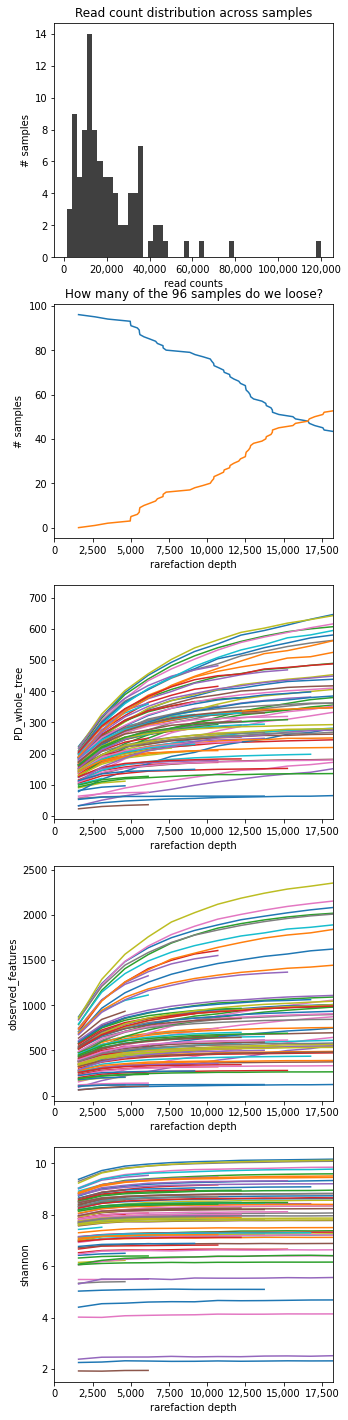

In [53]:
res_deblur = process_study(
    metadata=meta,
    control_samples=set([]),
    fp_deblur_biom=fps['deblur_150']['gsd'],
    fp_insertiontree=fps['workdir']['insertion_tree'],
    #fp_closedref_biom=fps['closedref_150']['gsd'],
    rarefaction_depth=4500,
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-nb-classifier_2020.2.qza',
    tree_insert=insertion_tree,
    is_v4_region=True,
    fix_zero_len_branches=True,
    emperor_fp=fp_generated+'/emperor/',
    emperor_infix='_deblur_',
    dry=False,
    use_grid=True,
    alpha_metrics=ALPHA_METRICS,
    #deblur_remove_features_lessthanXreads=10, # as this is now the default
)

meta['mitochloro_deblur'] = 100 - 100 * res_deblur['counts_plantsremoved'].sum() / res_deblur['counts_plantsStillIn'].sum()
#_ = emperor(meta, res_deblur['beta_diversity']['results'], )

## Compare

In [19]:
mantel(res_silva['beta_diversity']['results']['bray_curtis'], results['beta_diversity']['results']['bray_curtis'])

(0.8750991217673073, 0.001, 93)

(                 0
 0  too few samples,
 {'alpha': {}, 'beta': {}})

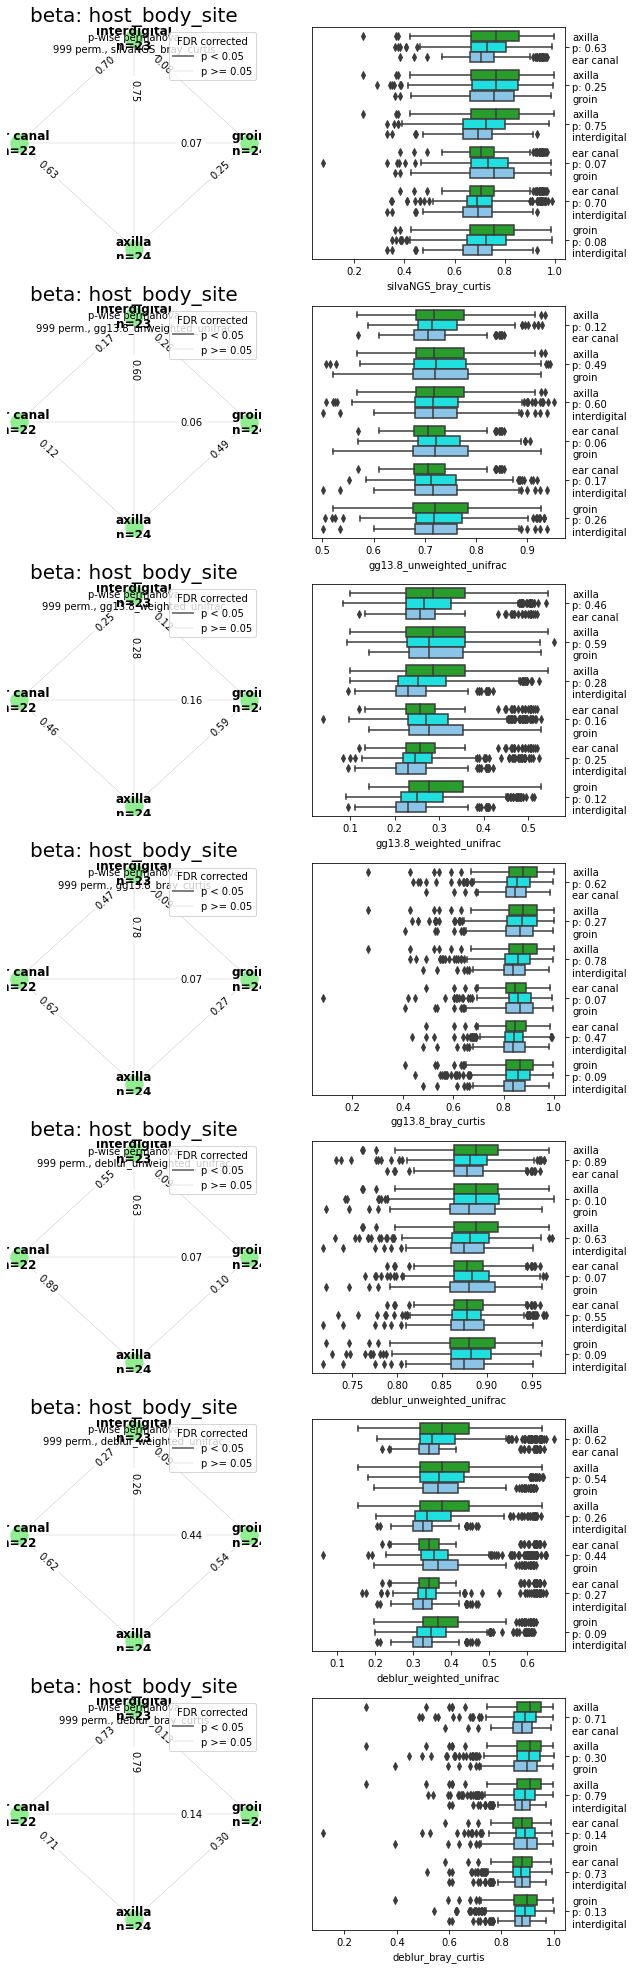

In [25]:
beta = dict()
beta.update({'silvaNGS_%s' % k: v for k,v in res_silva['beta_diversity']['results'].items()})
beta.update({'gg13.8_%s' % k: v for k,v in results['beta_diversity']['results'].items()})
beta.update({'deblur_%s' % k: v for k,v in res_deblur['beta_diversity']['results'].items()})

alpha = dict()
#alpha.update({'silvaNGS_%s' % k: v for k,v in res_alpha['results'].items()})
#alpha.update({'gg13.8_%s' % k: v for k,v in results['alpha_diversity']['results'].items()})

plotNetworks('host_body_site', meta, None, beta)

# Double check statements from manuscript

## Abstract

The bacterial community composition of the skin and ear canals of allergic dogs showed body site specific differences compared to non-allergic dogs.

<font color="orange">very weakly</font>

The ear canal microbiota of non-allergic German shepherd dogs had a reduced diversity compared to the body skin microbiota.

<font color="orange">we have too few samples to make statements about alpha diversity changes!</font>

The bacterial community composition of the skin and ear canals of allergic dogs showed body site specific differences compared to non-allergic dogs.

<font color="blue">yes</font>

The bacteria microbiota of allergic dogs were characterized by a site specific (axilla) lower species richness compared to non-allergic dogs.

<font color="orange">we have too few samples to make statements about alpha diversity changes!</font>

Actinobacteria was the most abundant phylum identified from the non-allergic dogs and Proteobacteria from allergic dogs. 

Macrococcus spp. were more abundant on non-allergic skin while Sphingomonas spp. was more abundant on the allergic skin.

<font color="orange">I would be careful with taxa names</font>

## Material and methods
### Study subjects
The control group included 12 non-allergic GSDs

<font color="blue">yes!</font>

In [26]:
meta.groupby(['host_health_status', 'host_body_site']).size()

host_health_status  host_body_site
allergic            axilla            12
                    ear canal         12
                    groin             12
                    interdigital      12
non-allergic        axilla            12
                    ear canal         12
                    groin             12
                    interdigital      12
dtype: int64

only dogs older than four years old were involved

<font color="red">wait, there are dogs 13 , 22 and 24 (all allergic) that are 2 or 3 years old! Furthermore, dogs 17,18,27,11 are == 4 years old</font>

In [27]:
meta[meta['host_age'].astype(int) <= 4].groupby(['host_health_status','host_subject_id','host_age']).size()

host_health_status  host_subject_id  host_age
allergic            13               2           4
                    17               4           4
                    18               4           4
                    22               2           4
                    24               3           4
                    27               4           4
non-allergic        11               4           4
dtype: int64

two non-allergic GSDs per household were required.

<font color="red">This is **not** true, at least not for the allergic dogs!</font>

In [28]:
meta.groupby(['host_health_status', 'household_id', 'host_subject_id']).size()

host_health_status  household_id  host_subject_id
allergic            10            14                 4
                    11            17                 4
                    12            18                 4
                    13            21                 4
                    14            22                 4
                    15            24                 4
                    16            27                 4
                    7             12                 4
                                  13                 4
                    8             15                 4
                                  16                 4
                    9             9                  4
non-allergic        1             1                  4
                                  2                  4
                    2             5                  4
                                  6                  4
                    3             7                  4
               

Twelve adult allergic GSDs were diagnosed with cAD

<font color="red">Not sure how to "know" which dog is cAD diagnosed, but if this is by canine_atopic_dermatitis_extent_and_severity_index_4 > 0, than we only have 11 not 12 dogs!</font>

In [29]:
meta.groupby(['host_health_status', 'host_subject_id', 'canine_atopic_dermatitis_extent_and_severity_index_4']).size()

host_health_status  host_subject_id  canine_atopic_dermatitis_extent_and_severity_index_4
allergic            12               9                                                       4
                    13               11                                                      4
                    14               2                                                       4
                    15               8                                                       4
                    16               10                                                      4
                    17               7                                                       4
                    18               4                                                       4
                    21               11                                                      4
                    22               4                                                       4
                    24               5                 

All owners filled out a questionnaire regarding their dog’s housing, partner animals, current diseases and treatment, food supplements, frequency of bathing and type of shampoo.

<font color='orange'>where are those data? especially "food supplements", "frequency of bathing" and "type of shampoo"!</font>

score their dog’s pruritic signs using a pruritus visual analogue scale (pVAS)

<font color='orange'>What does it mean, that dogs 27 and 9 had a score of 0 - the same as the non-allergic dogs?</font>

In [30]:
meta.groupby(['host_health_status', 'host_subject_id', 'pruritus_visual_analog_scale']).size()

host_health_status  host_subject_id  pruritus_visual_analog_scale
allergic            12               4                               4
                    13               5                               4
                    14               8                               4
                    15               4                               4
                    16               8                               4
                    17               2                               4
                    18               2                               4
                    21               2                               4
                    22               7                               4
                    24               8                               4
                    27               0                               4
                    9                0                               4
non-allergic        1                0                               4
           

the Canine Atopic Dermatitis Extent and Severity Index (CADESI-4), was performed for the atopic dogs

<font color='darkblue'>yes, we have these data :-)</font>

Skin and ear canal cytology was performed as described [22,23].

<font color='orange'>where can I find these information?</font>

### Sample collection
After physical examination, the left axilla (A), left front dorsal interdigital region (Int), left side of the groin (L) and the left ear canal (O) were sampled.

<font color='darkblue'>yes</font>

In [31]:
meta.groupby(['host_health_status', 'host_body_site']).size()

host_health_status  host_body_site
allergic            axilla            12
                    ear canal         12
                    groin             12
                    interdigital      12
non-allergic        axilla            12
                    ear canal         12
                    groin             12
                    interdigital      12
dtype: int64

### DNA extraction and 16S rRNA gene amplicon sequencing
The 16S rRNA gene sequences of Bacteria were amplified for Illumina amplicon sequencing (LGC Genomics, Berlin, Germany) using a nested PCR approach with a first PCR with the primer system - 341F/1061R (V3-V6) (20 cycles) followed by a second PCR with primer system 515F-Y and 926R-jed (V4-V5) (20 cycles), because according to previous studies, only a low amount of microbial DNA was detected on human skin analyzed by PCR [24,25].

<font color='darkblue'>In fact, the ENA sequencing files are **not** trimmed, i.e. contain adapters. This can be seen by the fact that most reads do not start with the expected TCGA sequence.
I therefore had to manually trim (via spike) and upload trimmed sequences to Qiita and re-process. Not sure how the silvaNGS pipeline handles this.

OK #taxa shrinks from 16805 to 15948. Good.</font>

In [32]:
pd.Series(map(lambda x: x[:4], res_deblur['rarefaction']['results'].index)).value_counts()

TACG    7470
CCGT    4705
CCGC     888
TACA     772
GACG     636
CACG     237
GACA     176
AACG      59
TACC      12
TACT       5
GGAG       4
GTAG       3
GACT       2
TATG       2
AACA       2
TGAC       1
CACT       1
GCCA       1
CACC       1
dtype: int64

## Results
### Study subjects
Overall 29 GSDs were sampled but five were excluded according to the exclusion criteria (Table 1 in S1)

<font color='darkblue'>yes</font>

In [33]:
meta.groupby('host_subject_id').size().shape

(24,)

Twelve non-allergic (6 male, 1 male castrated, 4 intact female and 1 sprayed female) and twelve allergic (2 intact male, 1 male castrated and 9 intact female) GSDs were further analyzed (Table 1 in S1)

<font color='darkblue'>yes</font>

In [34]:
meta.groupby(['host_health_status', 'sex', 'host_subject_id']).size()

host_health_status  sex             host_subject_id
allergic            female          12                 4
                                    13                 4
                                    14                 4
                                    15                 4
                                    17                 4
                                    18                 4
                                    22                 4
                                    24                 4
                                    27                 4
                    male            16                 4
                                    9                  4
                    male castrated  21                 4
non-allergic        female          11                 4
                                    2                  4
                                    28                 4
                                    7                  4
                    female sprayed  

The dogs were living in a radius of max 131 kilometers away from the town of Giessen (Germany).

<font color="red">Nope, dogs 25, 26 and 9 (allergic, great circle distance) are further away!</font>

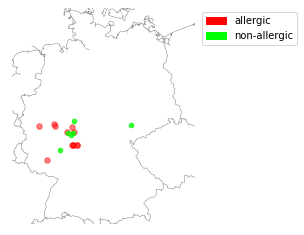

In [35]:
sites = meta.groupby(['host_subject_id']).head(1)[['host_subject_id', 'host_health_status', 'latitude', 'longitude']]
sites['distance_to_giessen_km'] = sites.apply(lambda row: get_great_circle_distance((50.58727, 8.67554), (float(row['latitude']), float(row['longitude']))), axis=1)

sites.head()

map_sites = []
for hs, g in sites.groupby('host_health_status'):
    map_sites.append({
        'coords': g[['latitude', 'longitude']],
        'color': '#00ff00' if hs == 'non-allergic' else '#ff0000',
        'alpha': 0.5,
        'label': hs,
        'size': 20 if hs == 'non-allergic' else 30
    })

_map = Basemap(llcrnrlat=47.3, 
               llcrnrlon=5.8, 
               urcrnrlat=54.9, 
               urcrnrlon=16.3, resolution='i', projection='cass', lat_0=50.7, lon_0=10.3)
x = drawMap(map_sites,
            basemap=_map, color_fill_land='white', color_water='white', color_border_land='gray', draw_country_borders=True)

In [36]:
sites[sites['distance_to_giessen_km'] > 131]

host_subject_id host_health_status   latitude  longitude  \
sample_name                                                            
13434.25A                25       non-allergic  50.862900  12.181160   
13434.26A                26       non-allergic  50.862900  12.181160   
13434.A9A                 9           allergic  49.624222   7.550560   

             distance_to_giessen_km  
sample_name                          
13434.25A                248.468612  
13434.26A                248.468612  
13434.A9A                133.713627

The age of the non- allergic dogs (mean: 7.5 ±1.9 years) was significantly higher (t-Test p< 0.01) than the age of allergic GSDs (mean: 4.8 ±2.2 years).

<font color='darkblue'>yes</font>

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MannwhitneyuResult(statistic=118.5, pvalue=0.0036442175161247553)

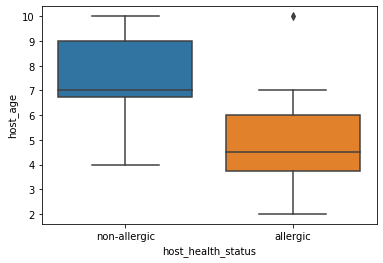

In [37]:
data = meta.groupby('host_subject_id').head(1)
data['host_age'] = data['host_age'].astype(float)
sns.boxplot(data=data, y='host_age', x='host_health_status')
mannwhitneyu(data[data['host_health_status'] == 'non-allergic']['host_age'], 
             data[data['host_health_status'] != 'non-allergic']['host_age'], alternative='greater')

All allergic dogs had mild lesions with a median CADESI-04 score of six (range 0-11) and a median PVAS score of four (range 0-8) (Table 2 in S1).

<font color='orange'>I might not understand those scales, but I assume "0" means none. Dog 9 has CADESI = 0 and PVAS = 0, while dog 27 has "only" PVAS = 0</font>

In [38]:
meta[meta['host_health_status'] == 'allergic'].groupby('host_subject_id').head(1).groupby(['host_subject_id', 'canine_atopic_dermatitis_extent_and_severity_index_4', 'pruritus_visual_analog_scale']).size()

host_subject_id  canine_atopic_dermatitis_extent_and_severity_index_4  pruritus_visual_analog_scale
12               9                                                     4                               1
13               11                                                    5                               1
14               2                                                     8                               1
15               8                                                     4                               1
16               10                                                    8                               1
17               7                                                     2                               1
18               4                                                     2                               1
21               11                                                    2                               1
22               4                                          

Two dogs had a PVAS score of 7/10 and 8/10

<font color='orange'>I don't get this statement: 3 dogs have PVAS=8, one =7. Is the scale maximum 10?</font>

In [39]:
meta[(meta['host_health_status'] == 'allergic') & (meta['pruritus_visual_analog_scale'].isin(['7', '8']))].groupby('host_subject_id').head(1).groupby(['host_subject_id', 'canine_atopic_dermatitis_extent_and_severity_index_4', 'pruritus_visual_analog_scale']).size()

host_subject_id  canine_atopic_dermatitis_extent_and_severity_index_4  pruritus_visual_analog_scale
14               2                                                     8                               1
16               10                                                    8                               1
22               4                                                     7                               1
24               5                                                     8                               1
dtype: int64

Six allergic GSDs received labeled doses of oclacitinib (Apoquel, Zoetis Deutschland GmbH, Berlin, Germany).

<font color='darkblue'>yes</font>

In [40]:
meta[(meta['host_health_status'] == 'allergic')].groupby(['oclacitinib', 'host_subject_id']).size()

oclacitinib      host_subject_id
did not receive  12                 4
                 13                 4
                 14                 4
                 22                 4
                 24                 4
                 27                 4
received         15                 4
                 16                 4
                 17                 4
                 18                 4
                 21                 4
                 9                  4
dtype: int64

### Analysis of the phylogenetic composition of the GSDs microbiota

In total, 4,038,850 paired end sequences with an average sequence length of 373 nucleotides (nt) were obtained.

<font color='orange'>Not clear if this describes the ENA files, or trimmed versions, or stiched versions?
I count 4.148.326 raw reads with an mean length of 288bp. There are 4.114.829 trimmed reads left with mean length of 278bp.
</font>

In [41]:
len_r1 = !zcat Incoming/ENA_sequences/*_1.fastq.gz | awk 'NR%4==2' | awk '{ print length }'
len_r2 = !zcat Incoming/ENA_sequences/*_2.fastq.gz | awk 'NR%4==2' | awk '{ print length }'
np.mean(list(map(lambda x: float(x), len_r1))), np.mean(list(map(lambda x: float(x), len_r2))), len(len_r1), len(len_r2)

(288.4487101544093, 288.429616669471, 4148326, 4148326)

Finally, 4,036,271 sequences (2334-246525 per sample) were further analyzed (Table 3 in S1)

<font color='orange'>I might operate on the wrong feature table, but I get 3.830.015 counts, worst sample has only 2334 best sample 232.445 counts.
</font>

In [42]:
silvangs_counts.sum().sum()

3830015.0

In [43]:
silvangs_counts.sum().describe()

count        96.000000
mean      39895.989583
std       33868.259890
min        2334.000000
25%       18837.750000
50%       27530.500000
75%       56895.750000
max      232445.000000
dtype: float64

### Skin Microbiome of non-allergic German shepherd dogs
#### Alpha diversity of bacterial communities present at skin samples of **non-allergic** GSDs
Richness (Chao1) and diversity (Shannon) of phylogenetic groups at the four sites (axilla, interdigital, groin, ear canal) were not significantly different between the body sites (Kruskal-Wallis for Shannon index, p= 0.6214; for Chao 1, p= 0.4784).

<font color='blue'>agree</font>

(                 0
 0  too few samples,
 {'alpha': {}, 'beta': {}})

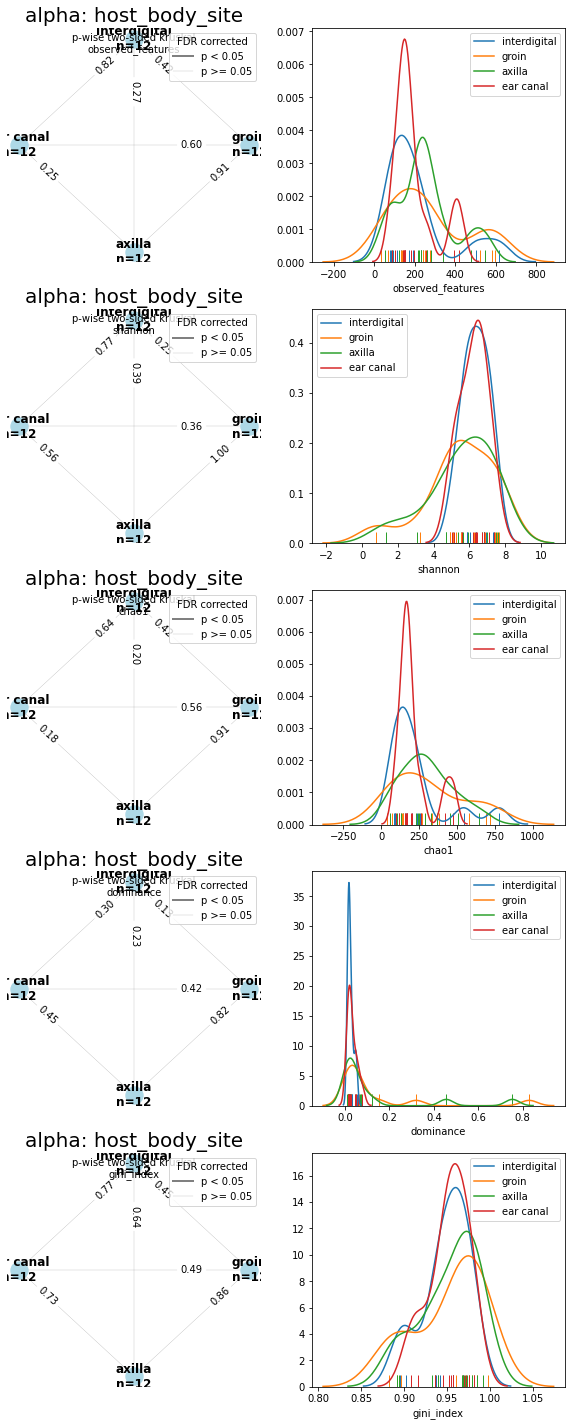

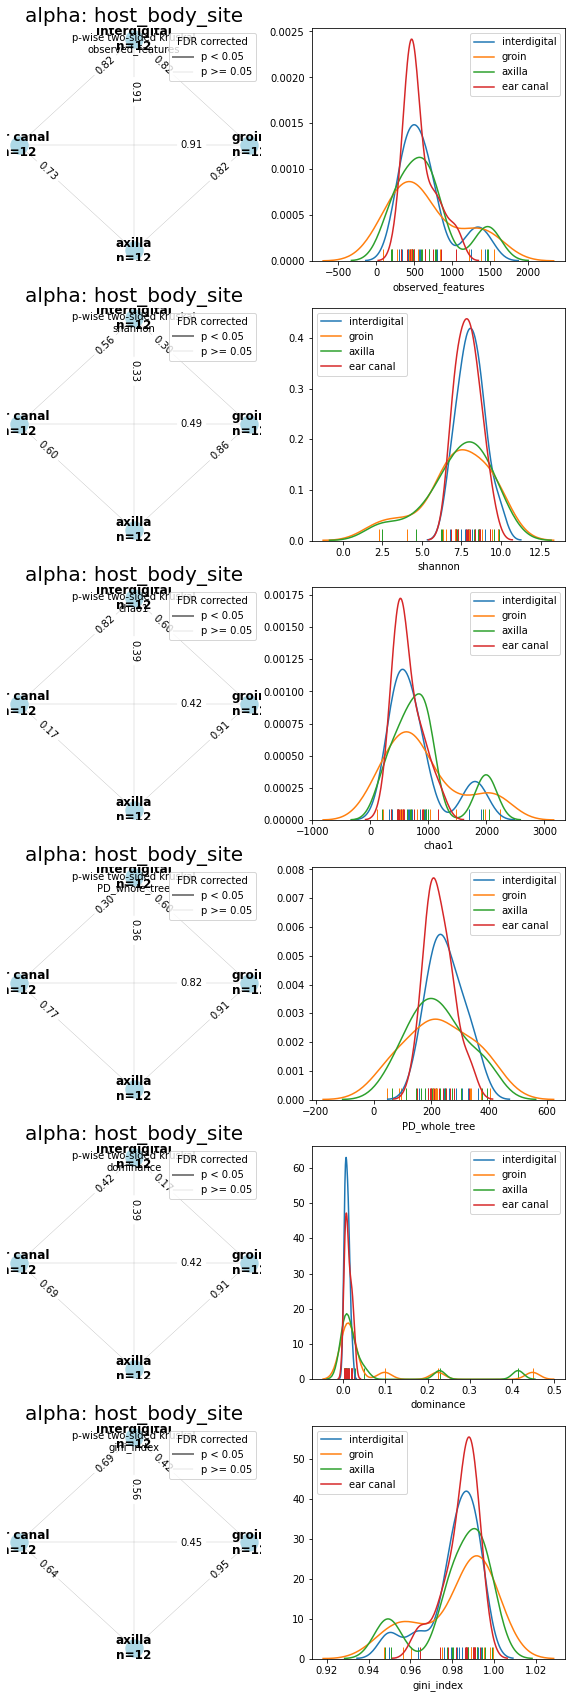

In [44]:
plotNetworks('host_body_site', meta[meta['host_health_status'] == 'non-allergic'], res_silva['alpha_diversity']['results'], beta=None, minnumalpha=0, fct_alpha_test=kruskal)
plotNetworks('host_body_site', meta[meta['host_health_status'] == 'non-allergic'], res_deblur['alpha_diversity']['results'], beta=None, minnumalpha=0, fct_alpha_test=kruskal)

However, a greater number of individual samples from the interdigital region and ear canal had a more homogeneous composition of microbiota, showing a lower richness (Chao 1 values; Fig 1 in S2). 

<font color='red'>one might see this from the plot, but it is **not** significant?</font>

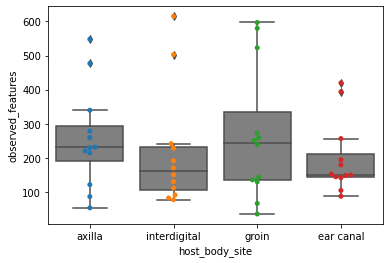

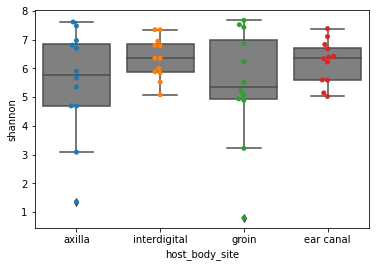

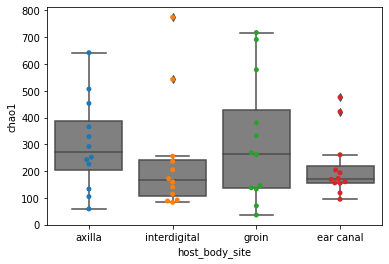

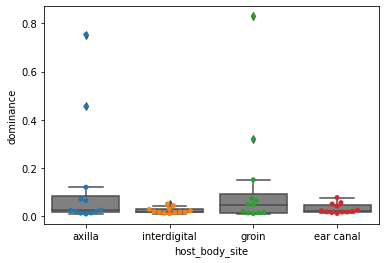

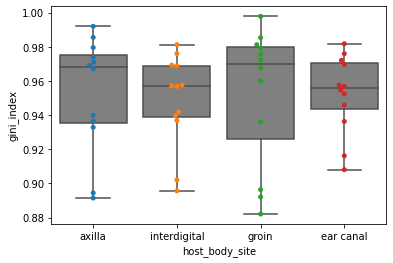

<Figure size 432x288 with 0 Axes>

In [45]:
data = meta[meta['host_health_status'] == 'non-allergic'].merge(res_silva['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_silva['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='host_body_site')
    sns.boxplot(data=data, y=metric, x='host_body_site', color="gray")
    plt.figure()

In [46]:
metric = 'chao1'
for a,b in combinations(data['host_body_site'].unique(), 2):
    print(a,b,mannwhitneyu(data[data['host_body_site'] == a][metric], data[data['host_body_site'] == b][metric], alternative='less'))

axilla interdigital MannwhitneyuResult(statistic=94.0, pvalue=0.9030345738587946)
axilla groin MannwhitneyuResult(statistic=70.0, pvalue=0.46549372327978356)
axilla ear canal MannwhitneyuResult(statistic=95.0, pvalue=0.9125733465533536)
interdigital groin MannwhitneyuResult(statistic=58.0, pvalue=0.21786533001586827)
interdigital ear canal MannwhitneyuResult(statistic=64.0, pvalue=0.33250277105101456)
groin ear canal MannwhitneyuResult(statistic=82.0, pvalue=0.7278149270716952)


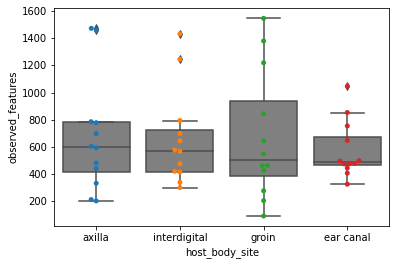

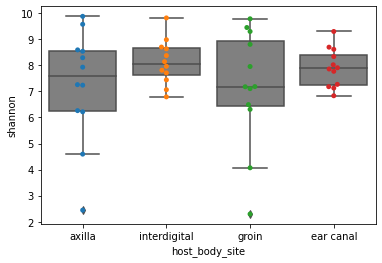

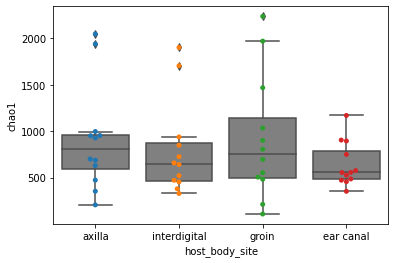

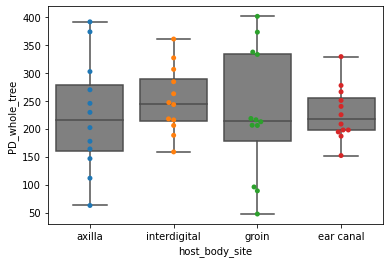

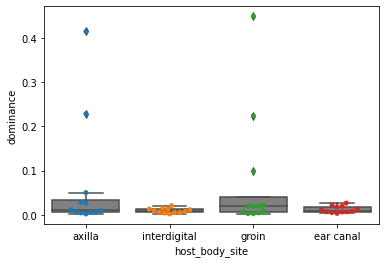

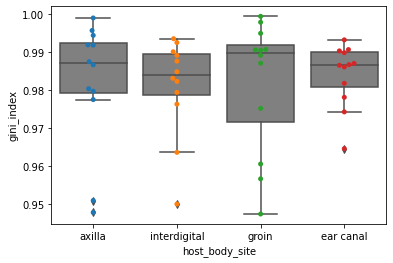

<Figure size 432x288 with 0 Axes>

In [47]:
data = meta[meta['host_health_status'] == 'non-allergic'].merge(res_deblur['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_deblur['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='host_body_site')
    sns.boxplot(data=data, y=metric, x='host_body_site', color="gray")
    plt.figure()

The three skin sites (axilla, interdigital, groin) were evaluated together comparing body skin to ear canal. Shannon values (t-Test, p= 0.889) were similar, but the ear canal showed significant lower bacterial richness (lower Chao-1 values, Figs 1a and 1b) than the body skin sites (t-Test, p= 0.000492; Table 4 in S1) which were more evenly distributed (significantly lower evenness values; t-Test, p= 0.000742; Table 4 in S1, Fig 3 in S2).

These findings were also supported by rarefaction curves, where most of the body skin samples had a higher slope than the curves of the ear canal samples indicating the presence of more complex bacterial communities on the body skin sites (Fig 1c).

<font color='orange'>I used a Mann-Whitny test and could **not** find this difference to be significant! It might be due to the fact that I operate on rarefied feature tables - as I think everything else is not appropriate!</font>

observed_features MannwhitneyuResult(statistic=241.0, pvalue=0.27983446359970576)
shannon MannwhitneyuResult(statistic=195.0, pvalue=0.6956411673505528)
chao1 MannwhitneyuResult(statistic=241.0, pvalue=0.27983446359970576)
dominance MannwhitneyuResult(statistic=225.0, pvalue=0.4198094590513366)
gini_index MannwhitneyuResult(statistic=229.0, pvalue=0.3829969675665112)


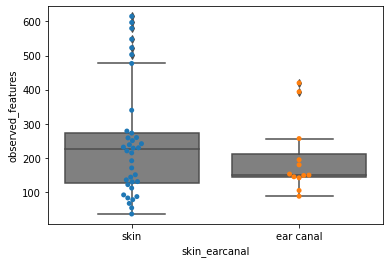

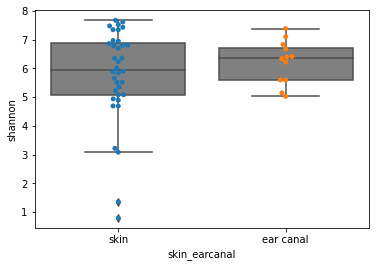

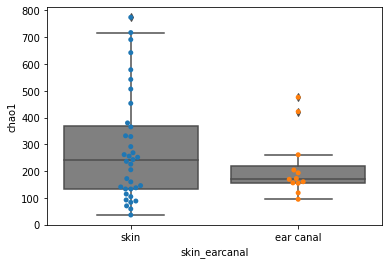

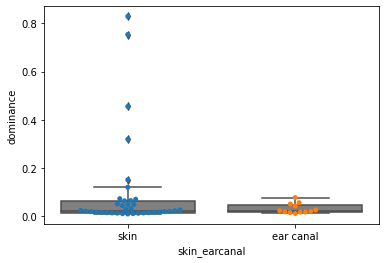

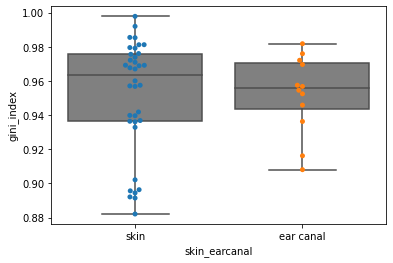

<Figure size 432x288 with 0 Axes>

In [48]:
data = meta[meta['host_health_status'] == 'non-allergic'].merge(res_silva['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_silva['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='skin_earcanal')
    sns.boxplot(data=data, y=metric, x='skin_earcanal', color="gray")
    print(metric, mannwhitneyu(data[data['skin_earcanal'] == 'skin'][metric], data[data['skin_earcanal'] != 'skin'][metric], 
                               alternative='greater'))
    plt.figure()

observed_features MannwhitneyuResult(statistic=224.0, pvalue=0.4291371152737282)
shannon MannwhitneyuResult(statistic=205.0, pvalue=0.6078844978567614)
chao1 MannwhitneyuResult(statistic=258.0, pvalue=0.16155300384038024)
PD_whole_tree MannwhitneyuResult(statistic=233.0, pvalue=0.34721249841586677)
dominance MannwhitneyuResult(statistic=223.0, pvalue=0.43850451244441147)
gini_index MannwhitneyuResult(statistic=230.0, pvalue=0.37394281702678533)


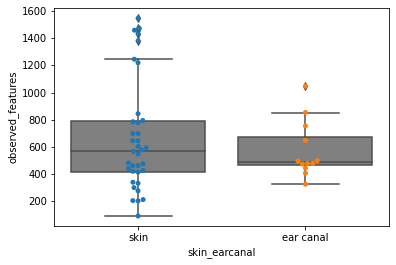

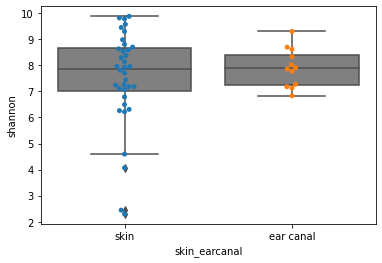

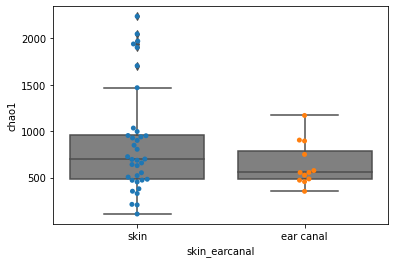

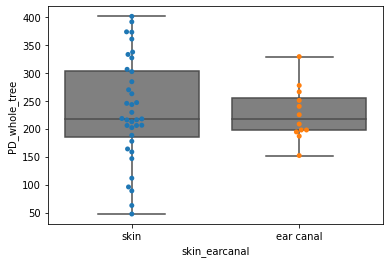

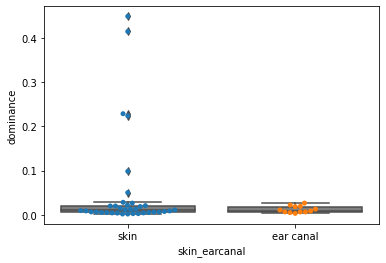

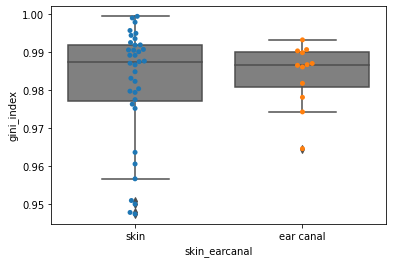

<Figure size 432x288 with 0 Axes>

In [49]:
data = meta[meta['host_health_status'] == 'non-allergic'].merge(res_deblur['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_deblur['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='skin_earcanal')
    sns.boxplot(data=data, y=metric, x='skin_earcanal', color="gray")
    print(metric, mannwhitneyu(data[data['skin_earcanal'] == 'skin'][metric], data[data['skin_earcanal'] != 'skin'][metric], 
                               alternative='greater'))
    plt.figure()

#### Skin microbial composition of non-allergic GSDs
One way ANOSIM analysis (p= 0.17) and One way PERMANOVA analysis (p= 0.1808) did not reveal significant differences between the four different body sites (axilla, interdigital, groin and ear canal) of the non-allergic GSDs.

<font color='blue'>agree, although "ear canal" and "groin" is relatively distant</font>

(                 0
 0  too few samples,
 {'alpha': {}, 'beta': {}})

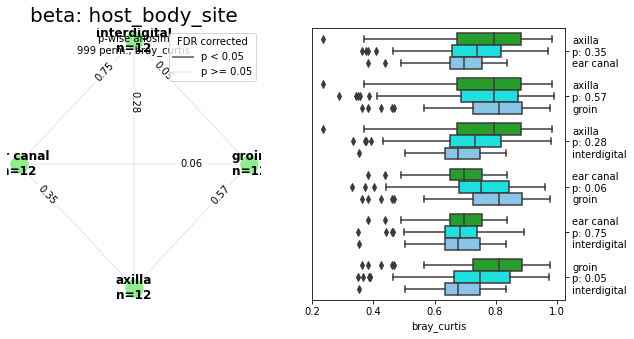

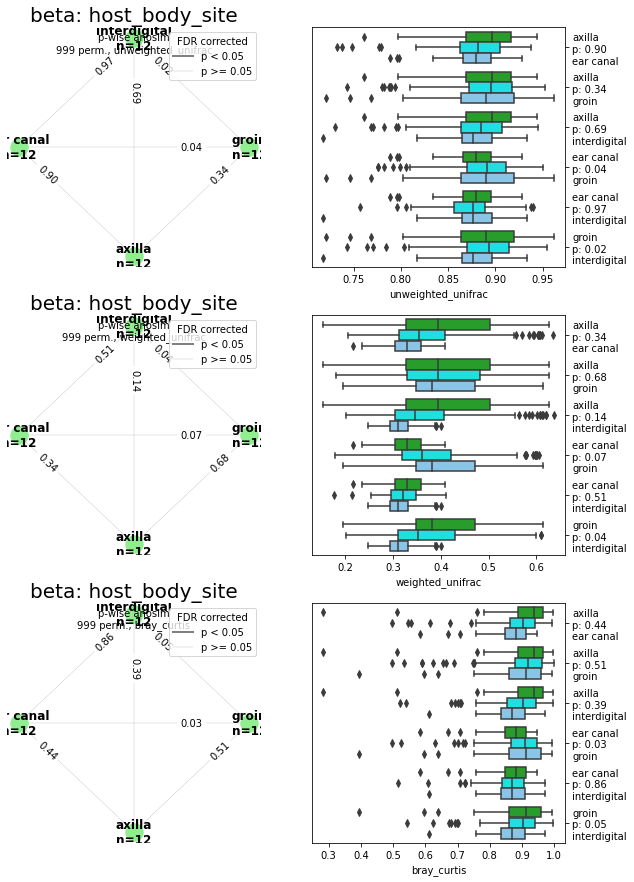

In [50]:
plotNetworks('host_body_site', meta[meta['host_health_status'] == 'non-allergic'], alpha=None, beta=res_silva['beta_diversity']['results'], fct_beta_test=anosim)#, fct_alpha_test=kruskal)
plotNetworks('host_body_site', meta[meta['host_health_status'] == 'non-allergic'], alpha=None, beta=res_deblur['beta_diversity']['results'], fct_beta_test=anosim)#, fct_alpha_test=kruskal)

the factor home had the strongest impact on the bacteria community composition (largest relative length of biplot vector; Fig. 2).

<font color='blue'>agree, this is by far the strongest effect when looking at all data via forward step redundancy analysis</font>

In [102]:
cols_constant = {col 
                 for col in meta.columns
                 if len(meta[col].unique()) == 1}
cols_alldifferent = {col 
                     for col in meta.columns
                     if meta.shape[0] == len(meta[col].unique())}
cols_categorials = {'household_id', 
                    # does not correlate with the microbiome! 'skin_earcanal', 
                    'oclacitinib', 
                    'sex', 
                    'host_health_status', 
                    'host_subject_id', 
                    # in principle, should highly correlate with household_id and latitude 'geo_loc_name', 
                    # does not correlate with the microbiome! 'host_body_site'
                   }
cols_dates = dict({'collection_timestamp': '%Y-%m-%d'})

cols_ordinals = {}
cols_intervals = [
    # does not correlate with the microbiome! 'longitude', 
    # in principle, should highly correlate with household_id and latitude 'latitude', 
    # does not correlate with the microbiome! 'host_age', 
    'mitochloro_deblur', 
    # does not correlate with the microbiome! 'host_weight', 
    # does not correlate with the microbiome! 'pruritus_visual_analog_scale', 
    # does not correlate with the microbiome! 'canine_atopic_dermatitis_extent_and_severity_index_4'
]

if True:
    corr_diversity_deblur = correlation_diversity_metacolumns(
        meta[sorted(list(cols_categorials | set(cols_dates.keys()) | set(cols_ordinals.keys()) | set(cols_intervals)))].fillna('NaN'),
        list(sorted(cols_categorials | set(cols_ordinals.keys()))),
        res_deblur['alpha_diversity']['results'], 
        res_deblur['beta_diversity']['results'],
        dry=False, wait=False, use_grid=False)
    corr_diversity_silva = correlation_diversity_metacolumns(
        meta[sorted(list(cols_categorials | set(cols_dates.keys()) | set(cols_ordinals.keys()) | set(cols_intervals)))].fillna('NaN'),
        list(sorted(cols_categorials | set(cols_ordinals.keys()))),
        res_silva['alpha_diversity']['results'], 
        res_silva['beta_diversity']['results'],
        dry=False, wait=False, use_grid=False)
if corr_diversity_silva['results'] is not None:
    display(corr_diversity_silva['results'].groupby('column')['p-value'].min().sort_values())
if corr_diversity_deblur['results'] is not None:
    display(corr_diversity_deblur['results'].groupby('column')['p-value'].min().sort_values())

Reducing analysis to 93 samples.
found matching working dir "/tmp/17828.1.jupyter.q/ana_corr-divmeta_hu993uog"
 Was removed.
Reducing analysis to 93 samples.
found matching working dir "/tmp/17828.1.jupyter.q/ana_corr-divmeta_2bzzjrv3"
 Was removed.


column
household_id            0.000356
collection_timestamp    0.000512
host_health_status      0.001000
host_subject_id         0.001000
sex                     0.001000
mitochloro_deblur       0.002900
oclacitinib             0.011000
__fake_qiime2_numcol    0.084600
Name: p-value, dtype: float64

column
collection_timestamp    0.000410
household_id            0.000516
host_health_status      0.001000
host_subject_id         0.001000
sex                     0.001000
oclacitinib             0.009000
mitochloro_deblur       0.009800
__fake_qiime2_numcol    0.284600
Name: p-value, dtype: float64

<font color="blue">I wonder why the same household_id (1,4,5,7 and 9) has different lat/long entries!</font>

Solved, Nekoles did mix up some samples:

"Bei der Tabelle die ich für Dr Jannsen gemacht habe, sind 3 cells mit Home ID falls. Diese habe ich jetzt korrigiert und markiert. Als comment habe ich notiert welcehs ID stand und was ist richtig. Tut mir Leid.
Das sollte aber nur bei Ihre messungen bzgl Household falls sein. Ich habe für meine die tabelle nicht benutzt.

Und ein kleines Fehler ist aufgetretten in die tabelle Metagenome. environmental. Da habe ich gefunden dass die probe a9Int und a12Int umgekehrt waren.  Diesewurde von Stefanie benutzt um die DAten beim NCBI hochzuladen. Nur diese sind für die Publikation eigentlich falsch.  kann man es vielleicht korrigieren?"

In [103]:
meta.groupby(['household_id', 'latitude', 'longitude']).size()

household_id  latitude   longitude
1             50.583832  8.677890     8
10            50.178720  8.919170     4
11            50.621760  8.596850     4
12            50.626190  9.028190     4
13            50.826640  7.948740     4
14            50.812380  7.039120     4
15            50.897350  7.876370     4
16            50.819030  8.918060     4
2             50.592500  8.958210     8
3             50.520771  8.816620     8
4             51.026930  8.972260     8
5             50.862900  12.181160    8
6             49.992863  8.247253     8
7             50.163380  8.978340     8
8             50.186930  9.196090     8
9             49.624222  7.550560     4
dtype: int64

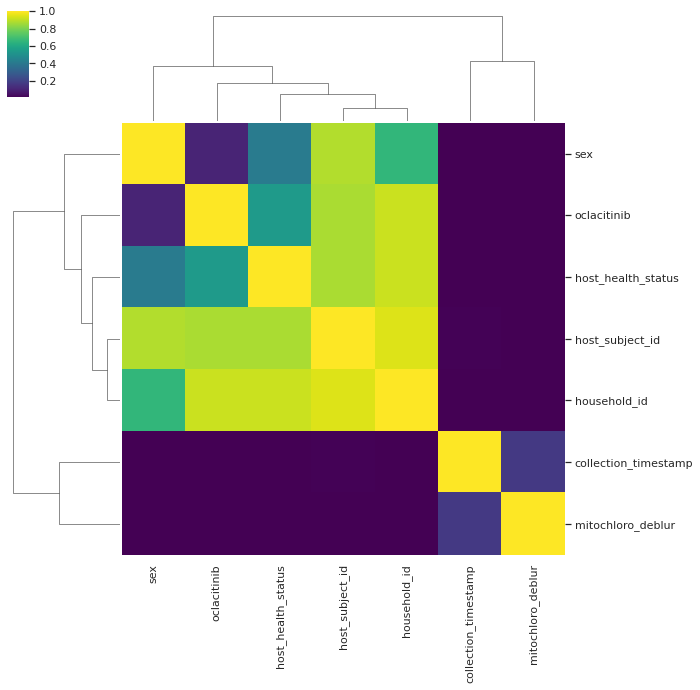

In [104]:
heatmap, correlations, cluster = correlate_metadata(
    meta[sorted(list(cols_categorials | set(cols_dates.keys()) | set(cols_ordinals.keys()) | set(cols_intervals)))].fillna('NaN'),
    categorials=list(cols_categorials),
    ordinals=cols_ordinals,
    intervals=cols_intervals,
    dates=cols_dates,
)

Using existing results from '.anacache/dcc943ef2cc185d81210e82552e56daf.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/723516c22e8daa9ff612dd834d5a86e1.fRDAalpha'. 
Using existing results from '.anacache/9d208f9fc9db243e518de327118d00ee.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/e8d380bca488df6258c56b33aeedf454.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/9e5dddf8d8581b53e46975e2aad0b58b.fRDAalpha'. 
Using existing results from '.anacache/5b3abe7778a25730ef420578215b7b19.fRDAbeta'. 


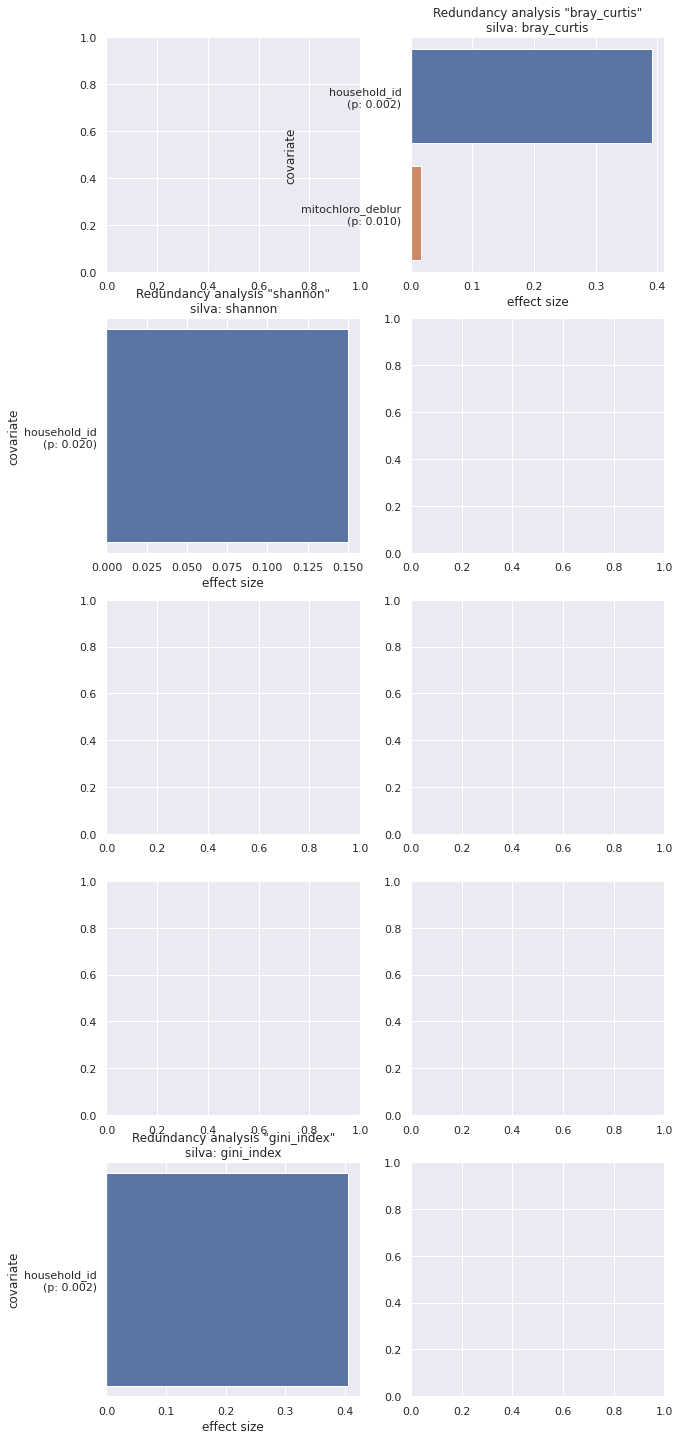

In [127]:
c_cat = ['host_health_status', 
         # host_subject_id overshadows the signal, thus I exclude it here 'host_subject_id', 
         'household_id', 
         #'host_body_site',
         #'sex',
         'oclacitinib'
        ]
c_int = [
    'mitochloro_deblur'
]
c_dat = {
    'collection_timestamp': '%Y-%m-%d'
}

usegrid = False
if False:
    max_rows = max(len(res_deblur['alpha_diversity']['results'].keys()), len(res_deblur['beta_diversity']['results'].keys()))
    fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
    for i, metric in enumerate(res_deblur['alpha_diversity']['results'].keys()):
        redundancy_analysis_alpha(meta, res_deblur['alpha_diversity']['results'][metric],
                                  categorials=c_cat, intervals=c_int, dates=c_dat,
                                  ax=axes[i][0], title='deblur: %s' % metric,
                                  dry=False, wait=False, use_grid=usegrid)
    for i, metric in enumerate(res_deblur['beta_diversity']['results'].keys()):
        redundancy_analysis_beta(meta, res_deblur['beta_diversity']['results'][metric], metric,
                                 categorials=c_cat, intervals=c_int, dates=c_dat,
                                 ax=axes[i][1], title='deblur: %s' % metric,
                                 dry=False, wait=False, use_grid=usegrid)

max_rows = max(len(res_silva['alpha_diversity']['results'].keys()), len(res_silva['beta_diversity']['results'].keys()))
fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
for i, metric in enumerate(res_silva['alpha_diversity']['results'].keys()):
    redundancy_analysis_alpha(meta, res_silva['alpha_diversity']['results'][metric],
                              categorials=c_cat, intervals=c_int, dates=c_dat,
                              ax=axes[i][0], title='silva: %s' % metric,
                              dry=False, wait=False, use_grid=usegrid)
for i, metric in enumerate(res_silva['beta_diversity']['results'].keys()):
    redundancy_analysis_beta(meta, res_silva['beta_diversity']['results'][metric], metric,
                             categorials=c_cat, intervals=c_int, dates=c_dat,
                             ax=axes[i][1], title='silva: %s' % metric,
                             dry=False, wait=False, use_grid=usegrid)
#fig.suptitle(c_cat)

No significant difference was found for the three body sites examined as body skin (axilla, interdigital, groin) versus ear canal (One way ANOSIM p= 0.8903; One way PERMANOVA p= 0.3098).

<font color='blue'>agree</font>

(                 0
 0  too few samples,
 {'alpha': {}, 'beta': {}})

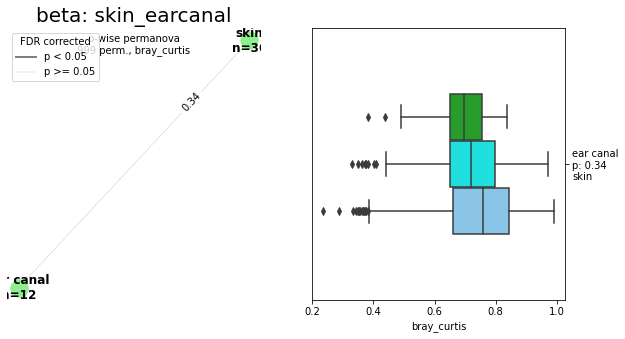

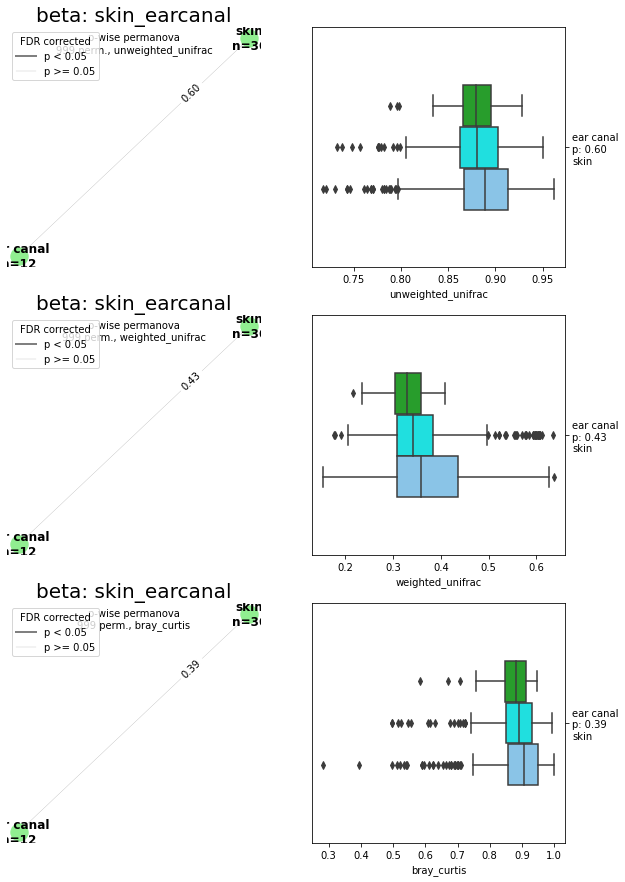

In [65]:
plotNetworks('skin_earcanal', meta[meta['host_health_status'] == 'non-allergic'], alpha=None, beta=res_silva['beta_diversity']['results'])#, fct_alpha_test=kruskal)
plotNetworks('skin_earcanal', meta[meta['host_health_status'] == 'non-allergic'], alpha=None, beta=res_deblur['beta_diversity']['results'])#, fct_alpha_test=kruskal)

However, significant differences in community composition were identified when grouping by sex (male versus female; One way ANOSIM and One way PERMANOVA p<0.001; R=0.1337) was conducted.

<font color="blue">I cannot confirm, but I am also not sure which samples to include exaclty: also castrated/sprayed. Across all bodysites? fsr-analysis could not pick up sex being significant.</font>

This might have been my fault as there were some issues with metadata for sex. Here is the corrected result and it is a very strong signal for differences in sex!

(                 0
 0  too few samples,
 {'alpha': {}, 'beta': {}})

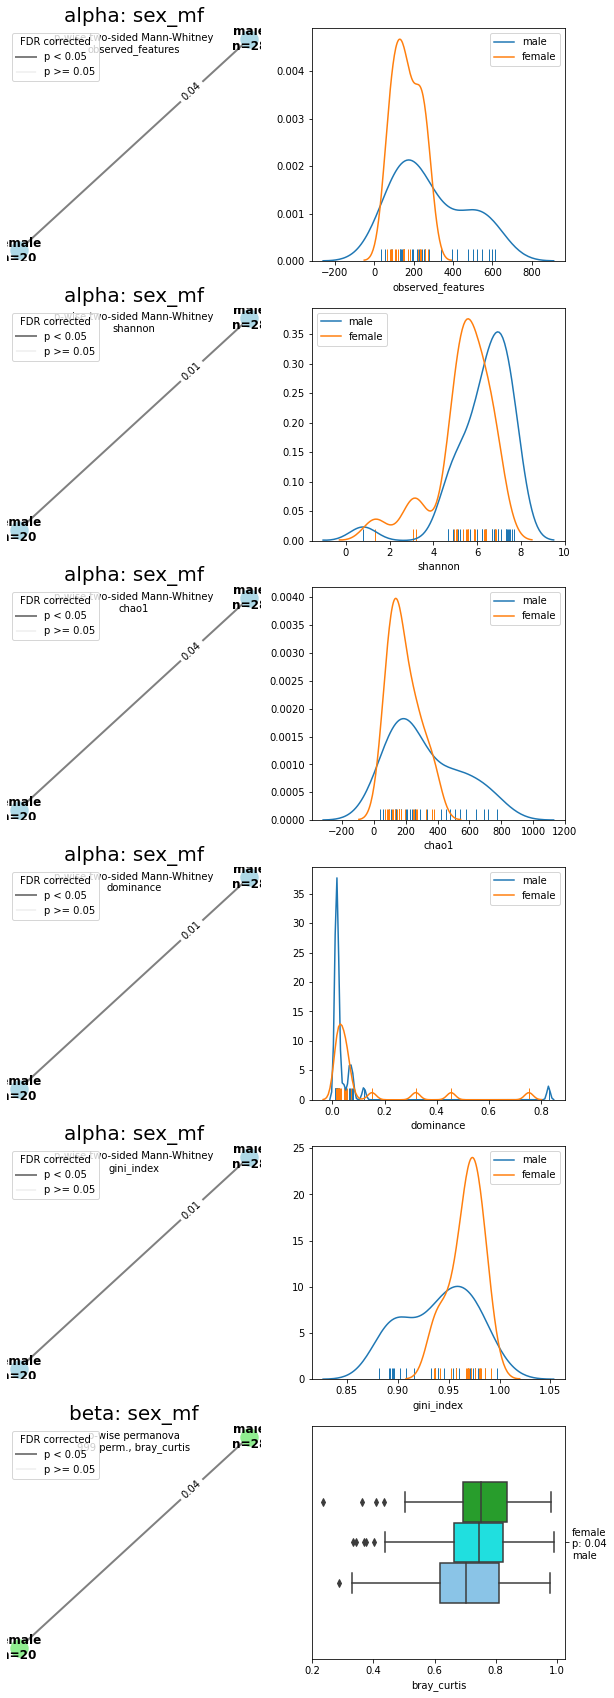

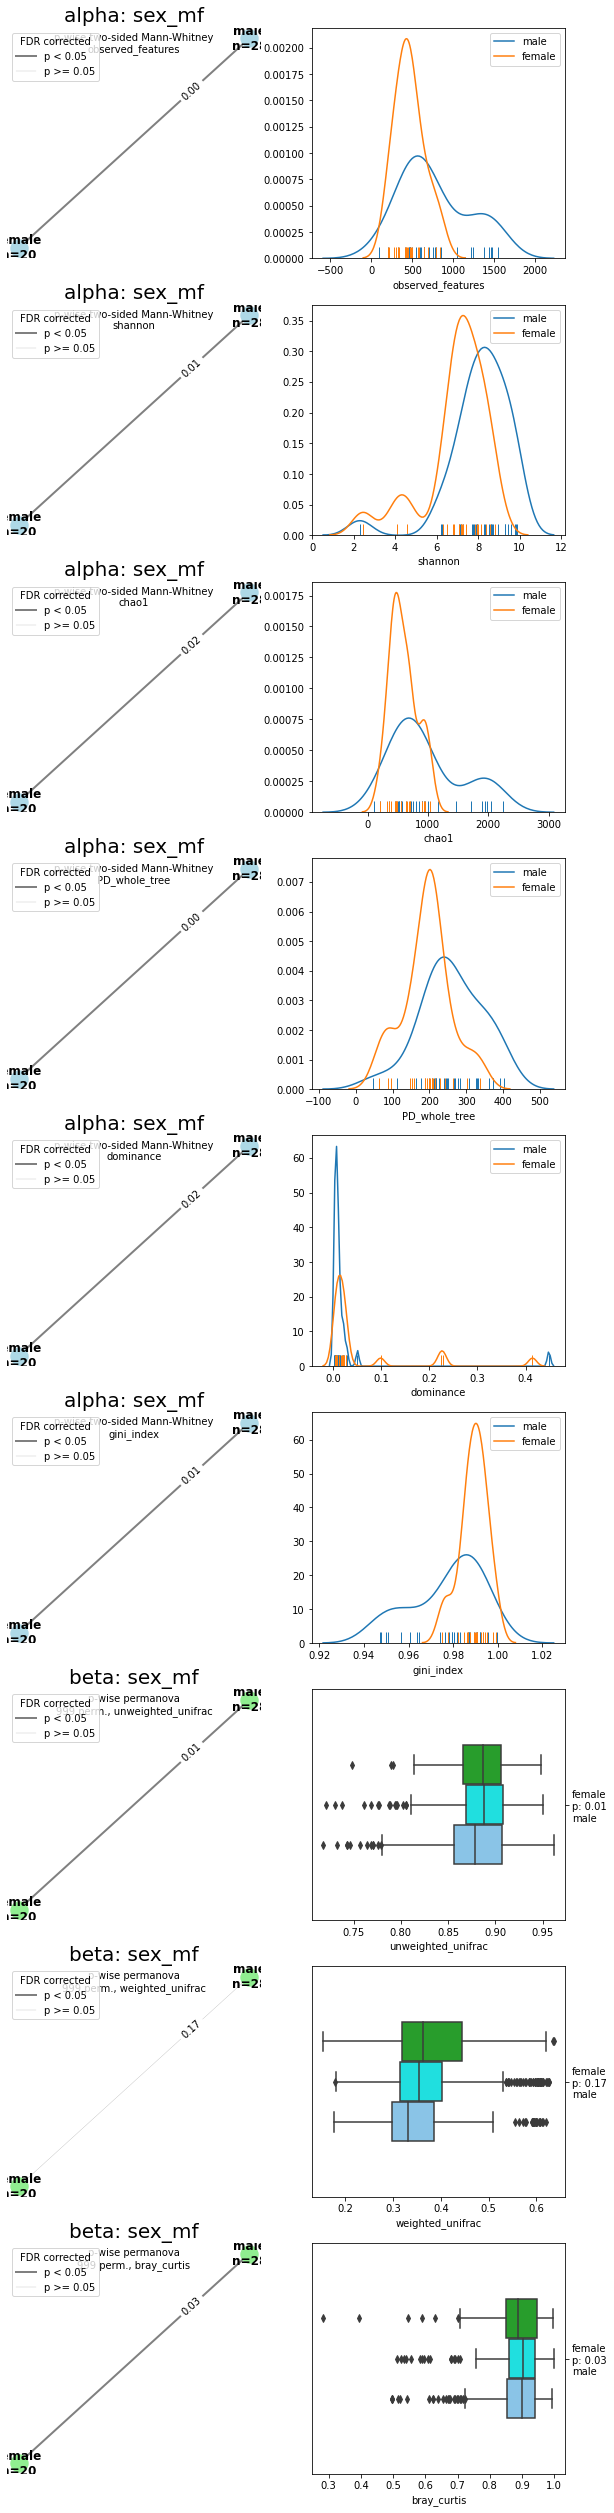

In [66]:
plotNetworks('sex_mf', meta[(meta['host_health_status'] == 'non-allergic')], alpha=res_silva['alpha_diversity']['results'], beta=res_silva['beta_diversity']['results'], minnumalpha=0)#, fct_alpha_test=kruskal)
plotNetworks('sex_mf', meta[(meta['host_health_status'] == 'non-allergic')], alpha=res_deblur['alpha_diversity']['results'], beta=res_deblur['beta_diversity']['results'], minnumalpha=0)#, fct_alpha_test=kruskal)

Significant differences in the bacterial community composition were also observed when grouped by homes (both One way ANOSIM and One way PERMANOVA p<0.003; R=0.1337; Fig 2 in S2; homes Table 1 in S1).

<font color="blue">yes! See fsr analysis</font>

#### Composition (most abundant taxa) of the skin of non-allergic GSDs
Forty-four phyla in total were identified from the four sample sites (axilla, interdigital, groin, ear canal) taken from the non-allergic dogs, of which 30 phyla had a relative abundance lower than 1%. The ten most abundant phyla of non-allergic dogs were Actinobacteria (mean relative abundance 29.1 ±14.7%) Proteobacteria (27.4 ±10.1%), Firmicutes (20.3 ±18.7%) and Bacteroides (10.8 ±5.4%), Cyanobacteria, Acidobacteria (both 2.0 ±1.6%), Chloroflexi (1.8 ±1.6%), Planctomycetes (1.7 ±1.4%), Deinococcus-Thermus (1.5 ±1.2%) and Verrucomicrobia (1.1 ±1.0%) (Fig 3b).

<font color="blue">yes! looks like silvaNGS and deblur+naive Bayes are not too different on Phylum level.</font>

43 taxa left after collapsing to Phylum.
48 samples left with metadata and counts.
25 taxa left after filtering low abundant.
raw counts: 93
raw meta: 48
meta with counts: 48 samples x 41 fields
counts with meta: 48


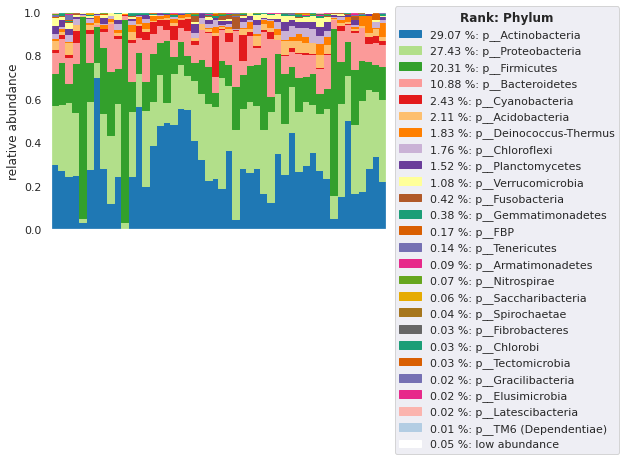

In [67]:
p = plotTaxonomy(res_silva['rarefaction']['results'], meta[(meta['host_health_status'] == 'non-allergic')], 
                 file_taxonomy=silvangs_taxonomy, print_meanrelabunances=True)

38 taxa left after collapsing to Phylum.
48 samples left with metadata and counts.
22 taxa left after filtering low abundant.
raw counts: 93
raw meta: 48
meta with counts: 48 samples x 41 fields
counts with meta: 48


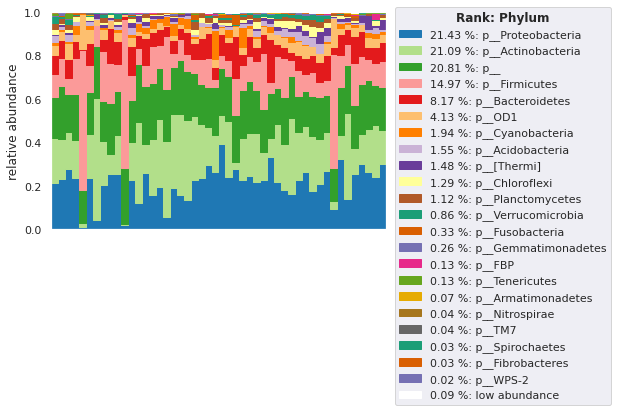

In [68]:
p = plotTaxonomy(res_deblur['rarefaction']['results'], meta[(meta['host_health_status'] == 'non-allergic')], 
                 file_taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'], print_meanrelabunances=True, )

In samples from the interdigital region and the ear canal Proteobacteria were most abundant followed by Actinobacteria, Firmicutes, Bacteroides and Cyanobacteria. Groin samples were dominated by Actinobacteria followed Proteobacteria, Firmicutes, Bacteroides and Cyanobacteria.

Ιn the samples from the axilla Firmicutes was most abundant followed by Actinobacteria, Proteobacteria, Bacteroides and Cyanobacteria (Fig 3b; Table 5 in S1).

<font color="blue">looks correct, although I have not checked all ranks. We already found that there is no sig. body site difference, therefore these results are not too important.</font>

43 taxa left after collapsing to Phylum.
48 samples left with metadata and counts.
25 taxa left after filtering low abundant.
raw counts: 93
raw meta: 48
meta with counts: 4 samples x 3 fields
counts with meta: 4


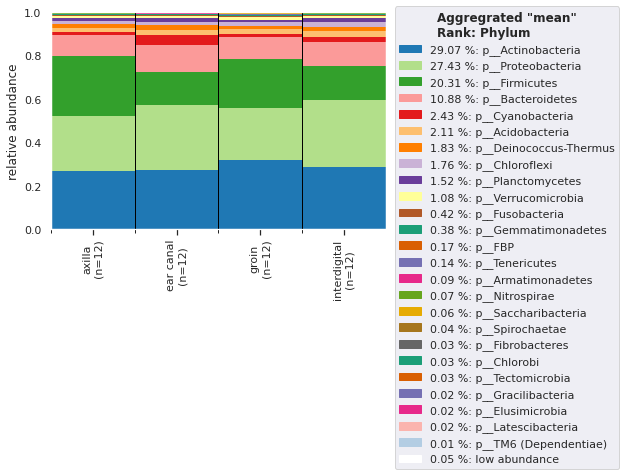

In [69]:
p = plotTaxonomy(res_silva['rarefaction']['results'], meta[(meta['host_health_status'] == 'non-allergic')], 
                 file_taxonomy=silvangs_taxonomy, print_meanrelabunances=True,
                 group_l1='host_body_site', fct_aggregate=np.mean)

38 taxa left after collapsing to Phylum.
48 samples left with metadata and counts.
22 taxa left after filtering low abundant.
raw counts: 93
raw meta: 48
meta with counts: 4 samples x 3 fields
counts with meta: 4


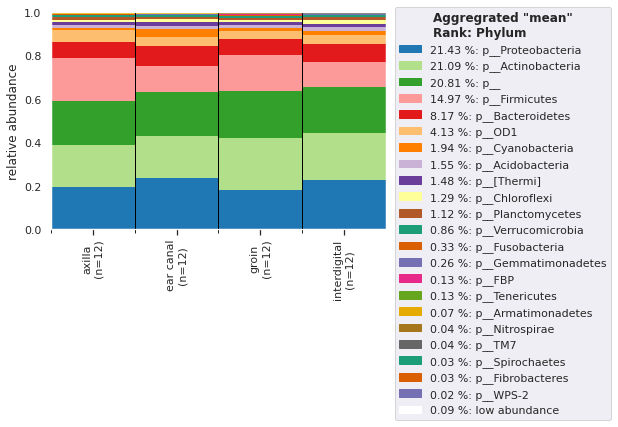

In [70]:
p = plotTaxonomy(res_deblur['rarefaction']['results'], meta[(meta['host_health_status'] == 'non-allergic')], 
                 file_taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'], print_meanrelabunances=True, 
                 group_l1='host_body_site', fct_aggregate=np.mean)

The skin of the axilla was mostly colonized by Macroccocus (mean relative abundance 13.8 ± 29.8%) followed by
Brevibacterium, Staphylococcus,Clostridium sensu stricto 7, Nocardioides, Sphingomonas and others.

<font color="blue">looks correct, but see above</font>

1103 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
195 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


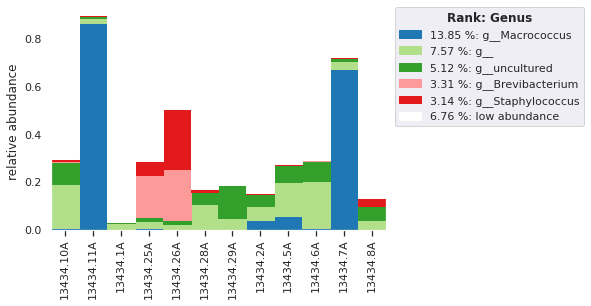

In [71]:
p = plotTaxonomy(res_silva['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'axilla')], 
                 file_taxonomy=silvangs_taxonomy, 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

519 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
79 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


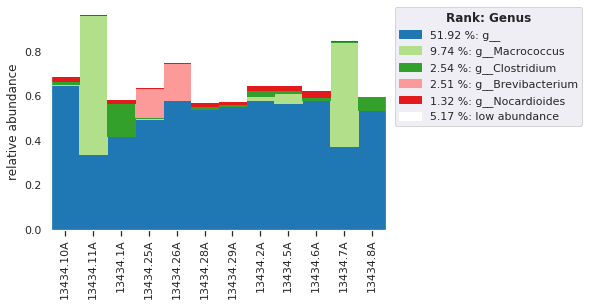

In [72]:
p = plotTaxonomy(res_deblur['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'axilla')], 
                 file_taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'], 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

The interdigital area was dominated by Clostridium sensu stricto 7 (mean relative abundance 3.5 ± 2.7%) followed by Nocardioides, Pelomonas, Sphingomonas, Vibrionimonas,Psychrobacter,Bravibacterium and Staphylococcus.

<font color="blue">looks correct, but see above</font>

1103 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
233 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


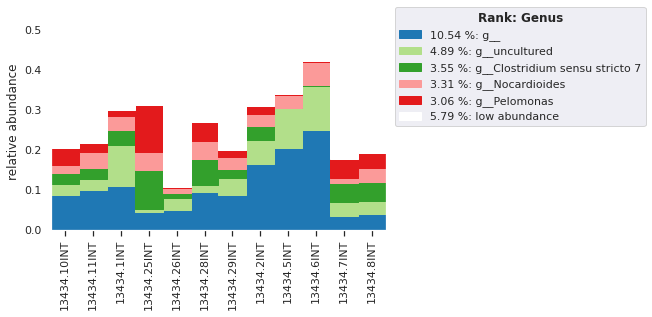

In [73]:
p = plotTaxonomy(res_silva['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'interdigital')], 
                 file_taxonomy=silvangs_taxonomy, 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

519 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
87 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


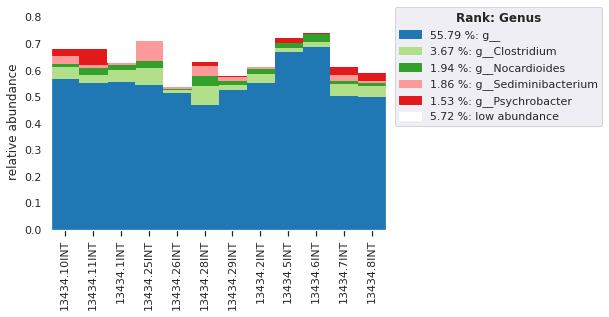

In [74]:
p = plotTaxonomy(res_deblur['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'interdigital')], 
                 file_taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'], 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

The groin was mostly colonized by Staphylococcus (mean relative abundance 10.8 +/- 25.5%), followed by Corynebacterium1, Conchiformibius, Nocardiodes, Brevibacterium, Macrococcus and Porphyromonas.

<font color="blue">looks correct, but see above</font>

1103 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
176 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


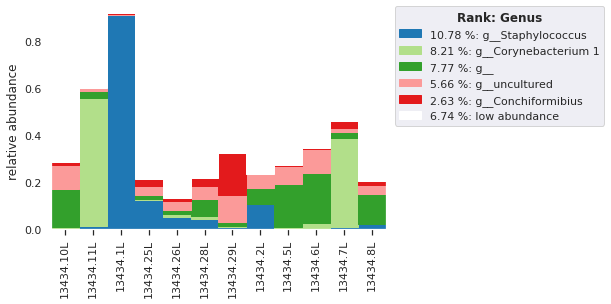

In [75]:
p = plotTaxonomy(res_silva['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'groin')], 
                 file_taxonomy=silvangs_taxonomy, 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

519 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
78 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


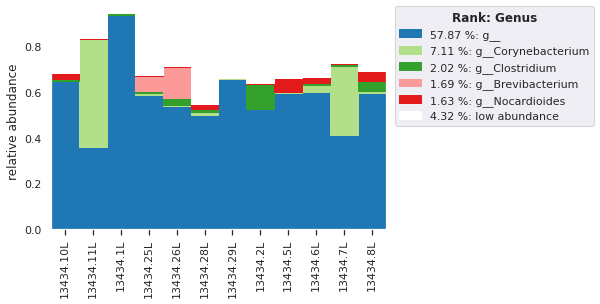

In [76]:
p = plotTaxonomy(res_deblur['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'groin')], 
                 file_taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'], 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

in the ear canal followed by Clostridium sensu stricto 7, Sphingomonas,
353 Psychrobacter, Pelomonas, Flavobacterium, Deinococcus and Pseudomonas.

<font color="blue">looks correct, but see above</font>

1103 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
221 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


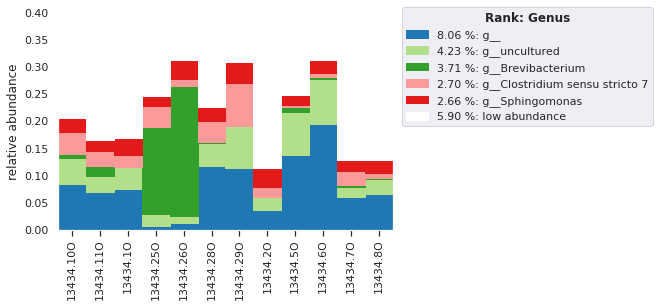

In [77]:
p = plotTaxonomy(res_silva['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'ear canal')], 
                 file_taxonomy=silvangs_taxonomy, 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

519 taxa left after collapsing to Genus.
12 samples left with metadata and counts.
83 taxa left after filtering low abundant.
6 taxa left after restricting to top 6.
raw counts: 93
raw meta: 12
meta with counts: 12 samples x 41 fields
counts with meta: 12


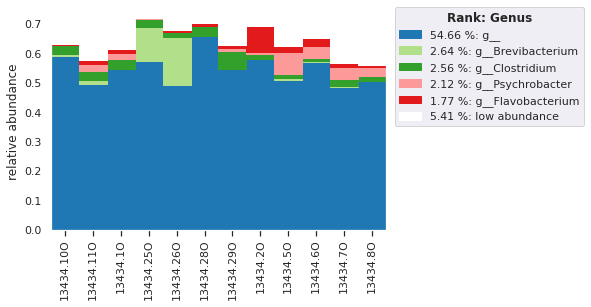

In [78]:
p = plotTaxonomy(res_deblur['rarefaction']['results'], 
                 meta[(meta['host_health_status'] == 'non-allergic') & (meta['host_body_site'] == 'ear canal')], 
                 file_taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'], 
                 print_meanrelabunances=True, plotTopXtaxa=6, rank='Genus', print_sample_labels=True)

Subsequently, each of the four taxa with the highest mean relative abundance per body site Staphylococcus; ear canal: Brevibacterium) was evaluated individually for significant different abundance between the four body sites. None of these taxa had a significantly different relative abundance between the four body sites (normality failed; Kruskal-Wallis-test for axilla vs interdigital vs groin vs ear canal; Macroccocus: p=0.975; Clostridium sensu stricto 7: p= 0.085; Staphylococcus: p= 0.288; Brevibacterium: p=0.406).

<font color="red">This is totally inappropriate! 1. we did NOT find significant differences between body sites, thus it is very unlikely that specific features should be significantly different. 2. you cannot test this for individual taxa because you did not correct for multiple testing. 3. you did not consider compositionallity!</font>

In [79]:
fp_tmp_counts = 'counts_calour.tmp'
fp_metadata_calour = 'metadata_calour.tmp'
meta.to_csv(fp_metadata_calour, sep="\t", index=True)
pandas2biom(fp_tmp_counts, res_silva['rarefaction']['results'])

e = ca.read_amplicon(fp_tmp_counts, fp_metadata_calour, min_reads=10, normalize=10000)

field = 'host_body_site'
res_ca_silvangs = find_diff_taxa(e, meta[meta['host_health_status'] == 'non-allergic'], [field])

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'host_body_site'  (n=93)
     0 (of  1518) taxa different between 'groin' (n=12) vs. 'axilla' (n=12)
     0 (of  1518) taxa different between 'groin' (n=12) vs. 'interdigital' (n=12)
     0 (of  1518) taxa different between 'groin' (n=12) vs. 'ear canal' (n=12)
     0 (of  1518) taxa different between 'axilla' (n=12) vs. 'interdigital' (n=12)
     0 (of  1518) taxa different between 'axilla' (n=12) vs. 'ear canal' (n=12)
     0 (of  1518) taxa different between 'interdigital' (n=12) vs. 'ear canal' (n=12)



In [80]:
fp_tmp_counts = 'counts_calour.tmp'
pandas2biom(fp_tmp_counts, res_deblur['rarefaction']['results'])

e = ca.read_amplicon(fp_tmp_counts, fp_metadata_calour, min_reads=10, normalize=10000)

field = 'host_body_site'
res_ca_deblur = find_diff_taxa(e, meta[meta['host_health_status'] == 'non-allergic'], [field])

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'host_body_site'  (n=93)
     0 (of  14977) taxa different between 'groin' (n=12) vs. 'axilla' (n=12)
     0 (of  14977) taxa different between 'groin' (n=12) vs. 'interdigital' (n=12)
     0 (of  14977) taxa different between 'groin' (n=12) vs. 'ear canal' (n=12)
     0 (of  14977) taxa different between 'axilla' (n=12) vs. 'interdigital' (n=12)
     0 (of  14977) taxa different between 'axilla' (n=12) vs. 'ear canal' (n=12)
     0 (of  14977) taxa different between 'interdigital' (n=12) vs. 'ear canal' (n=12)



In [81]:
if len(res_ca_deblur.values()) > 0:
    p = plot_diff_taxa(res_deblur['rarefaction']['results'], 
                       meta[(meta['host_health_status'] == "non-allergic")][field], 
                       res_ca_deblur, 
                       min_mean_abundance=0, 
                       title='sOTUs',
                       taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'])

### Changes in the Skin Microbiome of allergic German shepherd dogs
#### Diversity and richness of skin microbiota of allergic versus non-allergic GSDs
A significantly lower bacterial community richness was determined at the skin of the axilla of allergic GSDs (A; Chao 1 index; p= 0.032; Fig 5a).

<font color="blue">correct for silvaNGS, NOT in deblurred data</font>

observed_features MannwhitneyuResult(statistic=47.0, pvalue=0.07860637667000193)
shannon MannwhitneyuResult(statistic=72.0, pvalue=0.5115148723390122)
chao1 MannwhitneyuResult(statistic=40.0, pvalue=0.03448216666952704)
dominance MannwhitneyuResult(statistic=67.0, pvalue=0.39750608598211906)
gini_index MannwhitneyuResult(statistic=77.0, pvalue=0.6245840579554416)


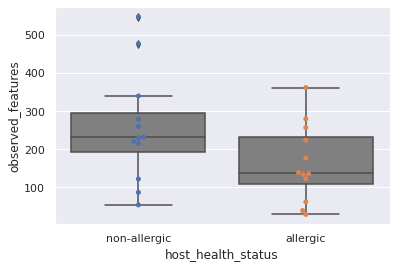

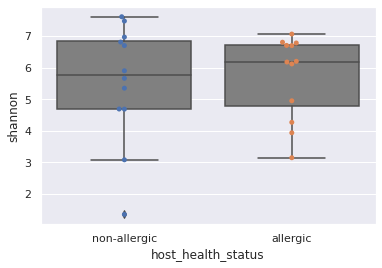

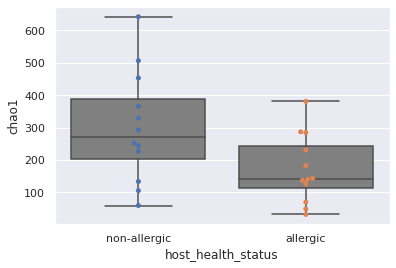

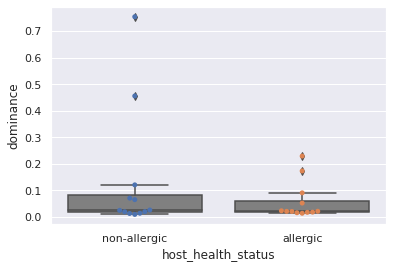

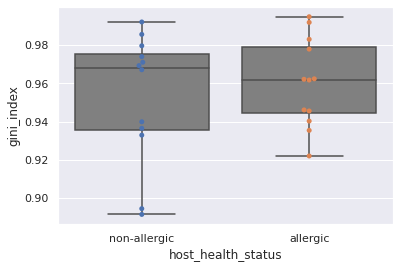

<Figure size 432x288 with 0 Axes>

In [82]:
data = meta[meta['host_body_site'] == 'axilla'].merge(res_silva['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_silva['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='host_health_status')
    sns.boxplot(data=data, y=metric, x='host_health_status', color="gray")
    print(metric, mannwhitneyu(data[data['host_health_status'] == 'allergic'][metric],
                       data[data['host_health_status'] != 'allergic'][metric], alternative='less'))
    plt.figure()

observed_features MannwhitneyuResult(statistic=62.0, pvalue=0.2916802333513516)
shannon MannwhitneyuResult(statistic=75.0, pvalue=0.5800700137299983)
chao1 MannwhitneyuResult(statistic=51.0, pvalue=0.11829204666093807)
PD_whole_tree MannwhitneyuResult(statistic=73.0, pvalue=0.5345062767202164)
dominance MannwhitneyuResult(statistic=62.0, pvalue=0.2916802333513516)
gini_index MannwhitneyuResult(statistic=74.0, pvalue=0.5573830427633992)


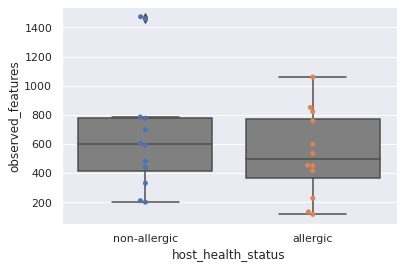

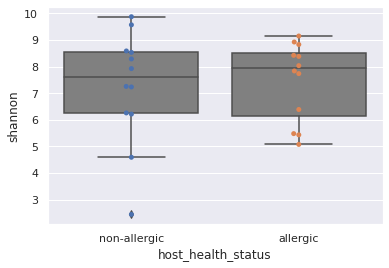

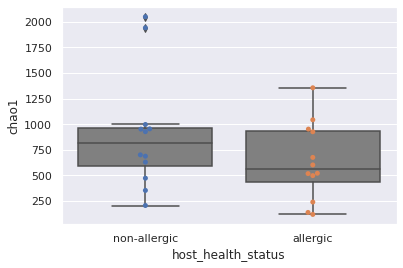

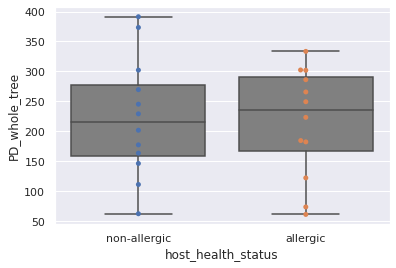

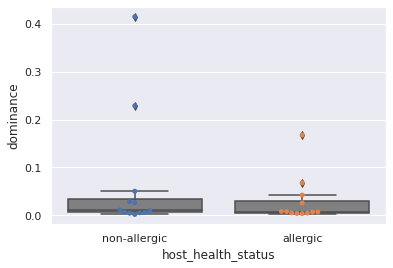

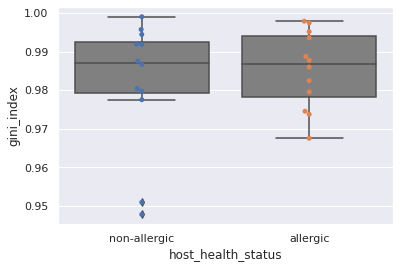

<Figure size 432x288 with 0 Axes>

In [83]:
data = meta[meta['host_body_site'] == 'axilla'].merge(res_deblur['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_deblur['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='host_health_status')
    sns.boxplot(data=data, y=metric, x='host_health_status', color="gray")
    print(metric, mannwhitneyu(data[data['host_health_status'] == 'allergic'][metric],
                       data[data['host_health_status'] != 'allergic'][metric], alternative='less'))
    plt.figure()

This finding was supported by respective rarefaction curves showing that the samples from the axilla of non- allergic dogs had a higher slope than the curves from the samples of allergic dogs indicating the presence of more complex bacterial communities in non-allergic dogs (Fig 6).

<font color="orange">I am still not sure if we should operate on non-rarefied feature tables</font>

The evenness of the skin microbiota in the groin of allergic dogs was significantly lower because of the high abundance of individual phylogenetic groups (Evenness index values, Table 9 in S1; Fig 4 in S2).

<font color="red">no</font>

observed_features MannwhitneyuResult(statistic=58.0, pvalue=0.21786533001586827)
shannon MannwhitneyuResult(statistic=83.0, pvalue=0.7466397425610708)
chao1 MannwhitneyuResult(statistic=55.0, pvalue=0.1703893067814773)
dominance MannwhitneyuResult(statistic=57.0, pvalue=0.20125191189100178)
gini_index MannwhitneyuResult(statistic=65.0, pvalue=0.35372698385103735)


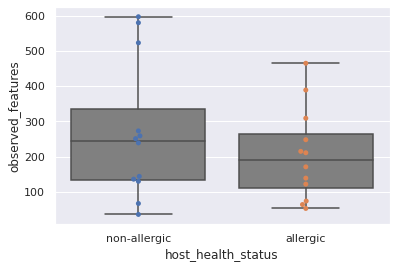

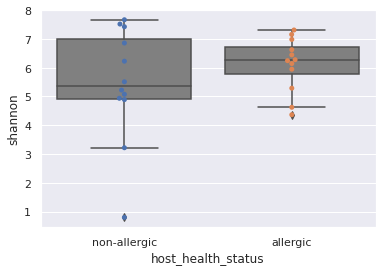

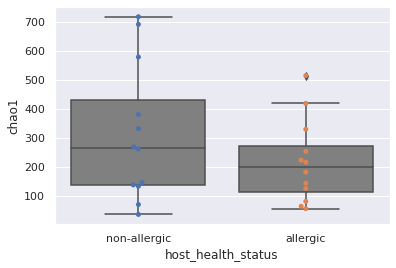

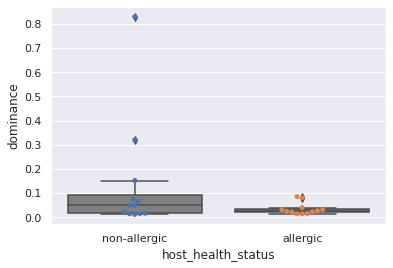

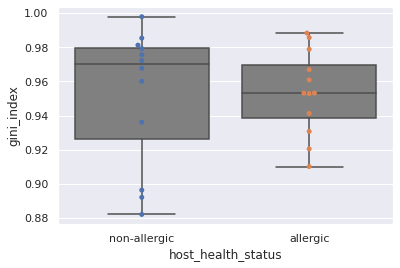

<Figure size 432x288 with 0 Axes>

In [84]:
data = meta[meta['host_body_site'] == 'groin'].merge(res_silva['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_silva['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='host_health_status')
    sns.boxplot(data=data, y=metric, x='host_health_status', color="gray")
    print(metric, mannwhitneyu(data[data['host_health_status'] == 'allergic'][metric],
                       data[data['host_health_status'] != 'allergic'][metric], alternative='less'))
    plt.figure()

observed_features MannwhitneyuResult(statistic=78.0, pvalue=0.37541594204455847)
shannon MannwhitneyuResult(statistic=83.0, pvalue=0.2721850729283049)
chao1 MannwhitneyuResult(statistic=71.0, pvalue=0.5345062767202164)
PD_whole_tree MannwhitneyuResult(statistic=85.0, pvalue=0.23524321102939483)
dominance MannwhitneyuResult(statistic=55.0, pvalue=0.843839289161892)
gini_index MannwhitneyuResult(statistic=62.0, pvalue=0.7278149270716952)


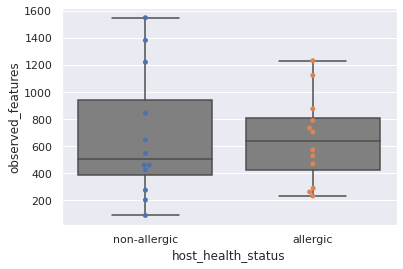

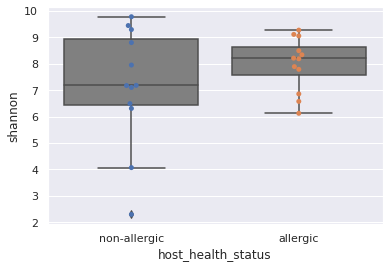

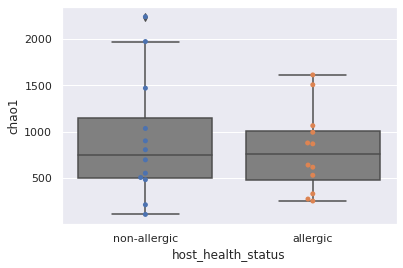

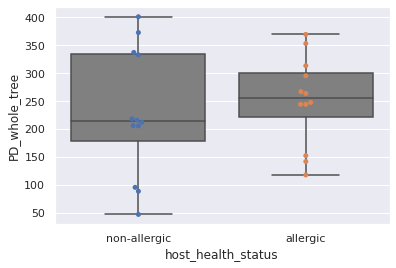

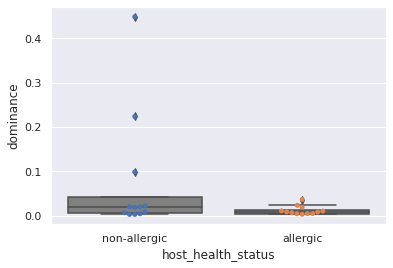

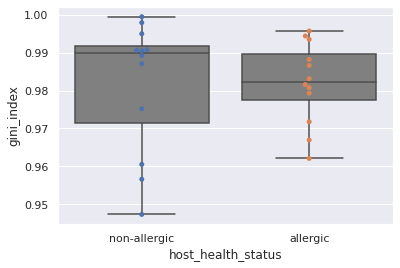

<Figure size 432x288 with 0 Axes>

In [85]:
data = meta[meta['host_body_site'] == 'groin'].merge(res_deblur['alpha_diversity']['results'], left_index=True, right_index=True)
for metric in res_deblur['alpha_diversity']['results'].keys():
    sns.swarmplot(data=data, y=metric, x='host_health_status')
    sns.boxplot(data=data, y=metric, x='host_health_status', color="gray")
    print(metric, mannwhitneyu(data[data['host_health_status'] == 'allergic'][metric],
                       data[data['host_health_status'] != 'allergic'][metric], alternative='greater'))
    plt.figure()

#### Differences in the composition of bacterial communities of allergic versus non-allergic GSDs

Significant differences were obtained for the axilla (A; One way ANOSIM p=0.048, R=0.1001; One way PERMANOVA p=0.0256), ...

<font color="blue">yes, even stronger in deblur</font>

...groin  (L; One way ANOSIM p=0.036, R=0.00386; One way PERMANOVA p= 0.0264) ...

<font color="blue">yes, even stronger in deblur</font>

...and ear canal (O; One way ANOSIM p=0.0012, R=0.1842; One way PERMANOVA p=0.0025), ...

<font color="blue">yes</font>

but not for the interdigital area (Int; One way ANOSIM p=0.1548; One way PERMANOVA p= 0.1171).

<font color="blue">yes</font>

In [86]:
site = 'axilla'
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_silva['alpha_diversity']['results'], beta=res_silva['beta_diversity']['results'], summarize=True)[0])
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_deblur['alpha_diversity']['results'], beta=res_deblur['beta_diversity']['results'], summarize=True)[0])

group name diversity       metric   group x       group y  p-value  \
0  host_health_status      beta  bray_curtis  allergic  non-allergic    0.029   

   test-statistic  num samples x  num samples y   avgdist  test name  \
0        1.830944             12             12  0.771045  permanova   

   min_group_size  num_permutations  
0               5               999

group name diversity              metric   group x       group y  \
2  host_health_status      beta         bray_curtis  allergic  non-allergic   
0  host_health_status      beta  unweighted_unifrac  allergic  non-allergic   
1  host_health_status      beta    weighted_unifrac  allergic  non-allergic   

   p-value  test-statistic  num samples x  num samples y   avgdist  test name  \
2    0.023        1.552107             12             12  0.907207  permanova   
0    0.028        1.261716             12             12  0.891840  permanova   
1    0.110        1.596231             12             12  0.396106  permanova   

   min_group_size  num_permutations  
2               5               999  
0               5               999  
1               5               999

In [87]:
site = 'groin'
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_silva['alpha_diversity']['results'], beta=res_silva['beta_diversity']['results'], summarize=True)[0])
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_deblur['alpha_diversity']['results'], beta=res_deblur['beta_diversity']['results'], summarize=True)[0])

group name diversity       metric   group x       group y  p-value  \
0  host_health_status      beta  bray_curtis  allergic  non-allergic     0.02   

   test-statistic  num samples x  num samples y   avgdist  test name  \
0        1.722086             12             12  0.760712  permanova   

   min_group_size  num_permutations  
0               5               999

group name diversity              metric   group x       group y  \
2  host_health_status      beta         bray_curtis  allergic  non-allergic   
0  host_health_status      beta  unweighted_unifrac  allergic  non-allergic   
1  host_health_status      beta    weighted_unifrac  allergic  non-allergic   

   p-value  test-statistic  num samples x  num samples y   avgdist  test name  \
2    0.036        1.376196             12             12  0.895202  permanova   
0    0.024        1.234402             12             12  0.885664  permanova   
1    0.005        1.947716             12             12  0.393490  permanova   

   min_group_size  num_permutations  
2               5               999  
0               5               999  
1               5               999

In [88]:
site = 'ear canal'
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_silva['alpha_diversity']['results'], beta=res_silva['beta_diversity']['results'], summarize=True)[0])
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_deblur['alpha_diversity']['results'], beta=res_deblur['beta_diversity']['results'], summarize=True)[0])

group name diversity       metric   group x       group y  p-value  \
0  host_health_status      beta  bray_curtis  allergic  non-allergic    0.002   

   test-statistic  num samples x  num samples y   avgdist  test name  \
0        1.769349             10             12  0.733678  permanova   

   min_group_size  num_permutations  
0               5               999

group name diversity              metric   group x       group y  \
2  host_health_status      beta         bray_curtis  allergic  non-allergic   
0  host_health_status      beta  unweighted_unifrac  allergic  non-allergic   
1  host_health_status      beta    weighted_unifrac  allergic  non-allergic   

   p-value  test-statistic  num samples x  num samples y   avgdist  test name  \
2    0.005        1.438372             10             12  0.888119  permanova   
0    0.004        1.210948             10             12  0.883692  permanova   
1    0.013        1.506739             10             12  0.368172  permanova   

   min_group_size  num_permutations  
2               5               999  
0               5               999  
1               5               999

In [89]:
site = 'interdigital'
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_silva['alpha_diversity']['results'], beta=res_silva['beta_diversity']['results'], summarize=True)[0])
display(plotNetworks('host_health_status', meta[meta['host_body_site'] == site], 
             alpha=res_deblur['alpha_diversity']['results'], beta=res_deblur['beta_diversity']['results'], summarize=True)[0])

group name diversity       metric   group x       group y  p-value  \
0  host_health_status      beta  bray_curtis  allergic  non-allergic     0.11   

   test-statistic  num samples x  num samples y   avgdist  test name  \
0        1.347306             11             12  0.698603  permanova   

   min_group_size  num_permutations  
0               5               999

group name diversity              metric   group x       group y  \
2  host_health_status      beta         bray_curtis  allergic  non-allergic   
0  host_health_status      beta  unweighted_unifrac  allergic  non-allergic   
1  host_health_status      beta    weighted_unifrac  allergic  non-allergic   

   p-value  test-statistic  num samples x  num samples y   avgdist  test name  \
2    0.078        1.237323             11             12  0.877380  permanova   
0    0.128        1.091705             11             12  0.877616  permanova   
1    0.162        1.239730             11             12  0.329940  permanova   

   min_group_size  num_permutations  
2               5               999  
0               5               999  
1               5               999

Sample a18O (ear canal of the allergic dog a18) was excluded from the NMDS plot because the community was too different (Fig 5 in S2). The strong difference of the community profile was due to the high relative abundance of the genus Staphylococcus (91.3%) compared to 0.02-6.4% in the other samples (Table 6 in S1).

<font color="red">wow, totally inappropriate!!!</font>

In order to determine which taxa (phylogenetic groups/genera) had the main contribution to the community differences among allergic versus non-allergic GSD for each body site, SIMPER analysis was performed. Phylogenetic groups with the highest contributions (>2%) are listed in S1 Table 10. The genus Macrococcus (9.0% contribution) was the major contributor for the differences in the samples from the axilla (A), followed by Staphylococcus (4.7% contribution).

<font color="blue">yes for Macrococcus, but not sure about the others</font>

In [90]:
fp_tmp_counts_silva = 'counts_calour_silva.tmp'
fp_tmp_counts_deblur = 'counts_calour_deblur.tmp'
pandas2biom(fp_tmp_counts_silva, res_silva['rarefaction']['results'])
pandas2biom(fp_tmp_counts_deblur, res_deblur['rarefaction']['results'])

e_silva = ca.read_amplicon(fp_tmp_counts_silva, fp_metadata_calour, min_reads=10, normalize=10000)
e_deblur = ca.read_amplicon(fp_tmp_counts_deblur, fp_metadata_calour, min_reads=10, normalize=10000)

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'host_health_status'  (n=93)
    34 (of  1518) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=12)

'host_health_status'  (n=93)


/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


   123 (of  14977) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=12)



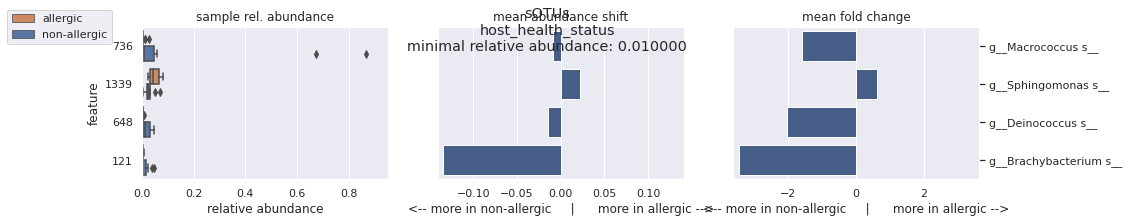

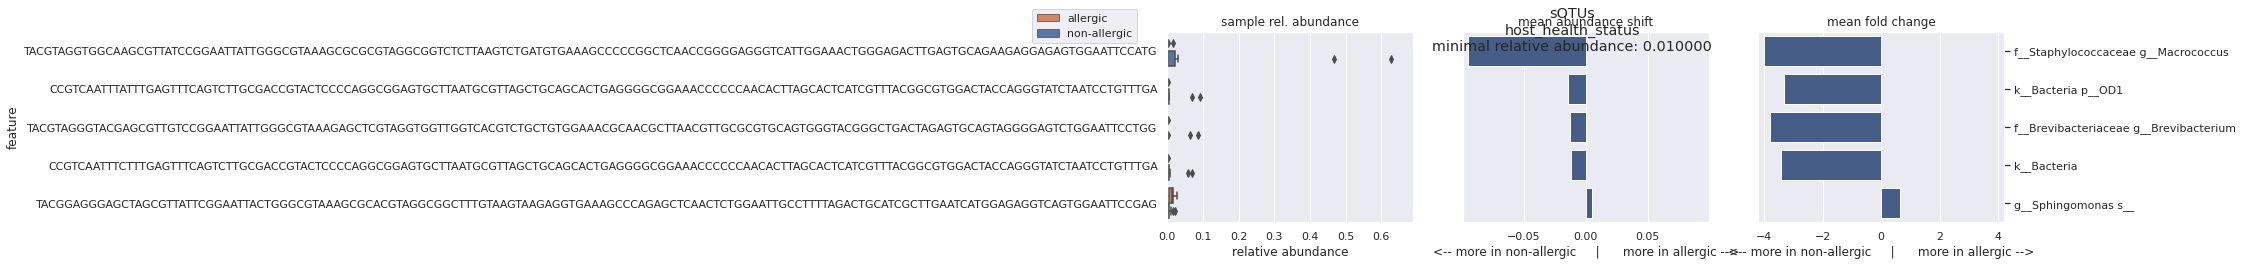

In [91]:
field = 'host_health_status'
site = 'axilla'
res_ca_silva = find_diff_taxa(e_silva, meta[meta['host_body_site'] == site], [field])
res_ca_deblur = find_diff_taxa(e_deblur, meta[meta['host_body_site'] == site], [field])
if len(res_ca_silva.values()) > 0:
    p = plot_diff_taxa(res_silva['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_silva, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_silva['taxonomy']['RDP']['results']['Taxon'])
if len(res_ca_deblur.values()) > 0:
    p = plot_diff_taxa(res_deblur['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_deblur, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'])    

For the samples from the groin (L) the genus Staphylococcus contributed the most (7.0% contribution). 

<font color="orange">other taxa found</font>

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'host_health_status'  (n=93)
    27 (of  1518) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=12)

'host_health_status'  (n=93)


/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


    92 (of  14977) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=12)



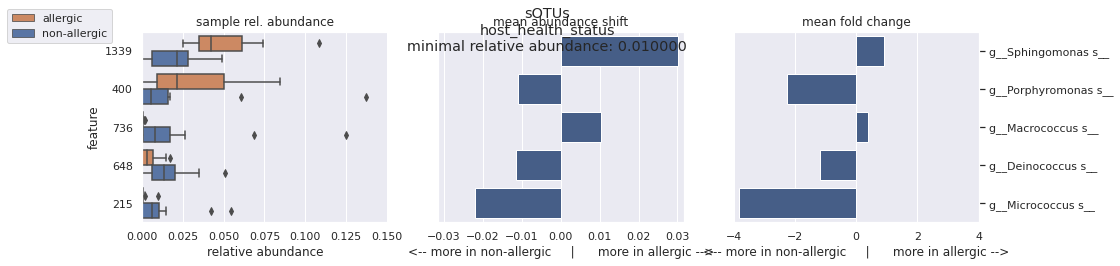

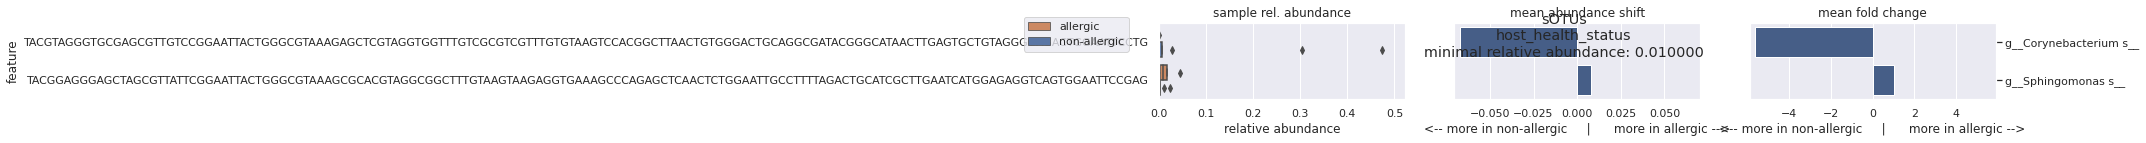

In [92]:
field = 'host_health_status'
site = 'groin'
res_ca_silva = find_diff_taxa(e_silva, meta[meta['host_body_site'] == site], [field])
res_ca_deblur = find_diff_taxa(e_deblur, meta[meta['host_body_site'] == site], [field])
if len(res_ca_silva.values()) > 0:
    p = plot_diff_taxa(res_silva['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_silva, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_silva['taxonomy']['RDP']['results']['Taxon'])
if len(res_ca_deblur.values()) > 0:
    p = plot_diff_taxa(res_deblur['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_deblur, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'])    

For the ear canal (O), Brevibacterium contributed the most to the differences (2.5% contribution) with Staphylococcus of the sample a18O being excluded as dominated all the other, as mentioned above, affecting the comparison.

<font color="blue">other taxa</font>

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'host_health_status'  (n=93)
    26 (of  1518) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=10)

'host_health_status'  (n=93)


/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


   104 (of  14977) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=10)



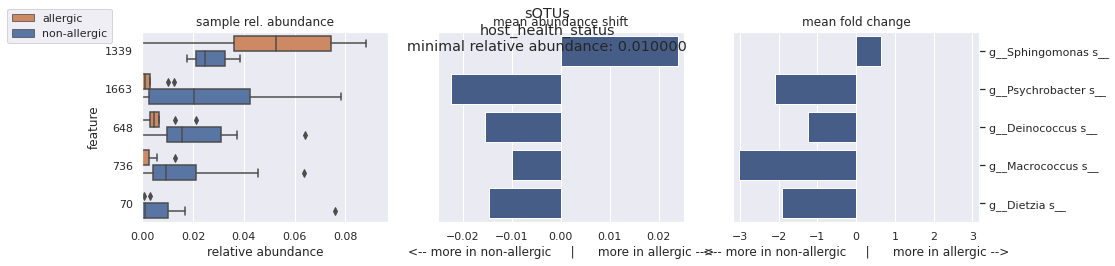

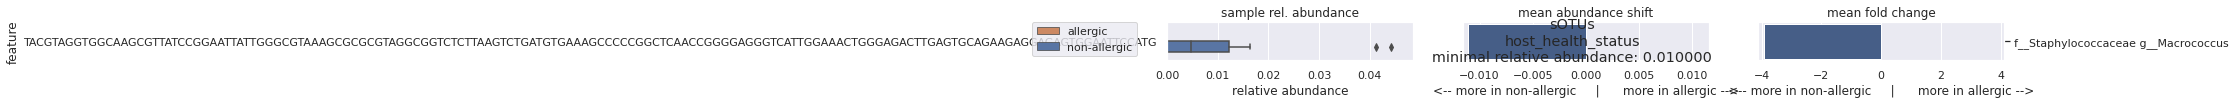

In [93]:
field = 'host_health_status'
site = 'ear canal'
res_ca_silva = find_diff_taxa(e_silva, meta[meta['host_body_site'] == site], [field])
res_ca_deblur = find_diff_taxa(e_deblur, meta[meta['host_body_site'] == site], [field])
if len(res_ca_silva.values()) > 0:
    p = plot_diff_taxa(res_silva['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_silva, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_silva['taxonomy']['RDP']['results']['Taxon'])
if len(res_ca_deblur.values()) > 0:
    p = plot_diff_taxa(res_deblur['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_deblur, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'])    

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'host_health_status'  (n=93)
    28 (of  1518) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=11)

'host_health_status'  (n=93)


/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


   116 (of  14977) taxa different between 'non-allergic' (n=12) vs. 'allergic' (n=11)

Warnings: no taxa left!


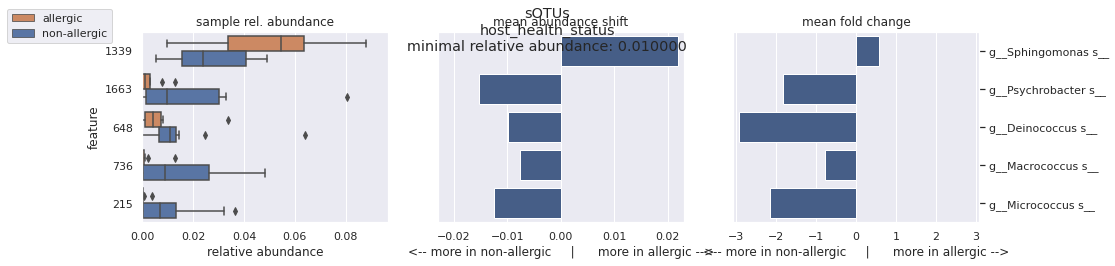

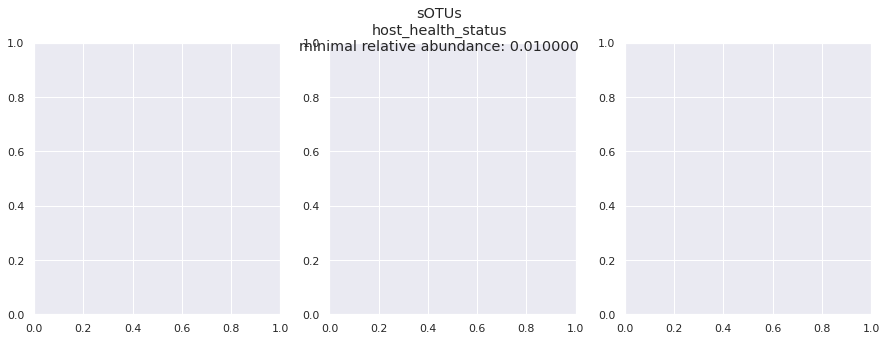

In [94]:
field = 'host_health_status'
site = 'interdigital'
res_ca_silva = find_diff_taxa(e_silva, meta[meta['host_body_site'] == site], [field])
res_ca_deblur = find_diff_taxa(e_deblur, meta[meta['host_body_site'] == site], [field])
if len(res_ca_silva.values()) > 0:
    p = plot_diff_taxa(res_silva['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_silva, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_silva['taxonomy']['RDP']['results']['Taxon'])
if len(res_ca_deblur.values()) > 0:
    p = plot_diff_taxa(res_deblur['rarefaction']['results'], 
                       meta[(meta['host_body_site'] == site)][field], 
                       res_ca_deblur, 
                       min_mean_abundance=0.01, 
                       title='sOTUs',
                       taxonomy=res_deblur['taxonomy']['RDP']['results']['Taxon'])    

In order to evaluate if oclacitinib had an effect in the composition of the skin microbiota of the allergic dogs, we compared the bacterial communities’ composition, as described above for the subgroups allergic with oclacitinib (n=6) and without oclacitinib (n=6). No significant difference was obtained, proposing that oclacitinib did not affected the cutaneous and ear canal microbiota composition (One way ANOSIM p-values; axilla: p= 0.2777; interdigital: p= 0.2949; groin: p=0.1494; ear canal: p=0.9022) among the allergic dogs, given the small number of the subgroup population. 

<font color="blue">yes. This variable did also not show up in effect size quantification.</font>

On this basis we assume that apoquel did not affect the comparison between allergic and non-allergic dogs.

<font color="red">YOU CANNOT DO THIS! Correct: we don't know and thus don't make a statement!</font>

(                 0
 0  too few samples,
 {'alpha': {}, 'beta': {}})

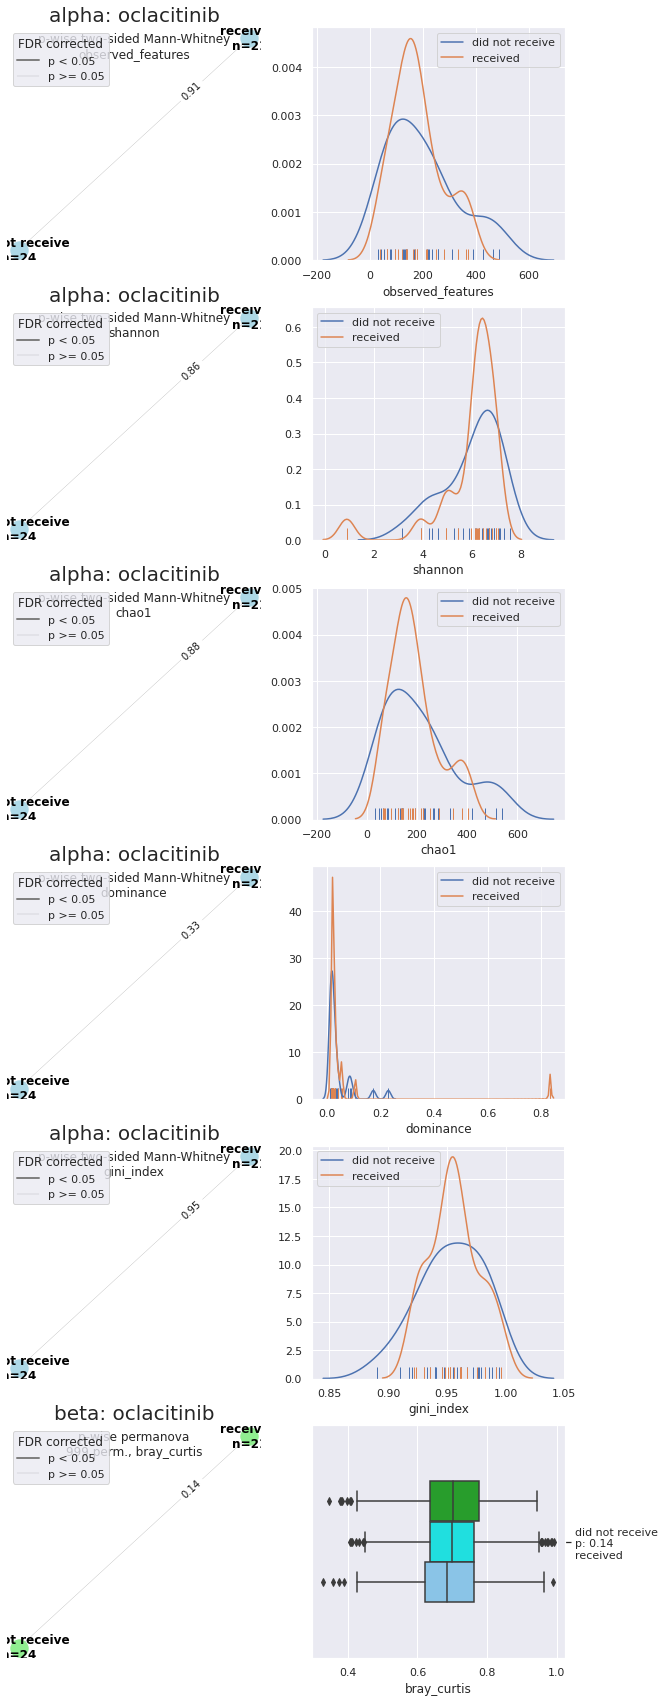

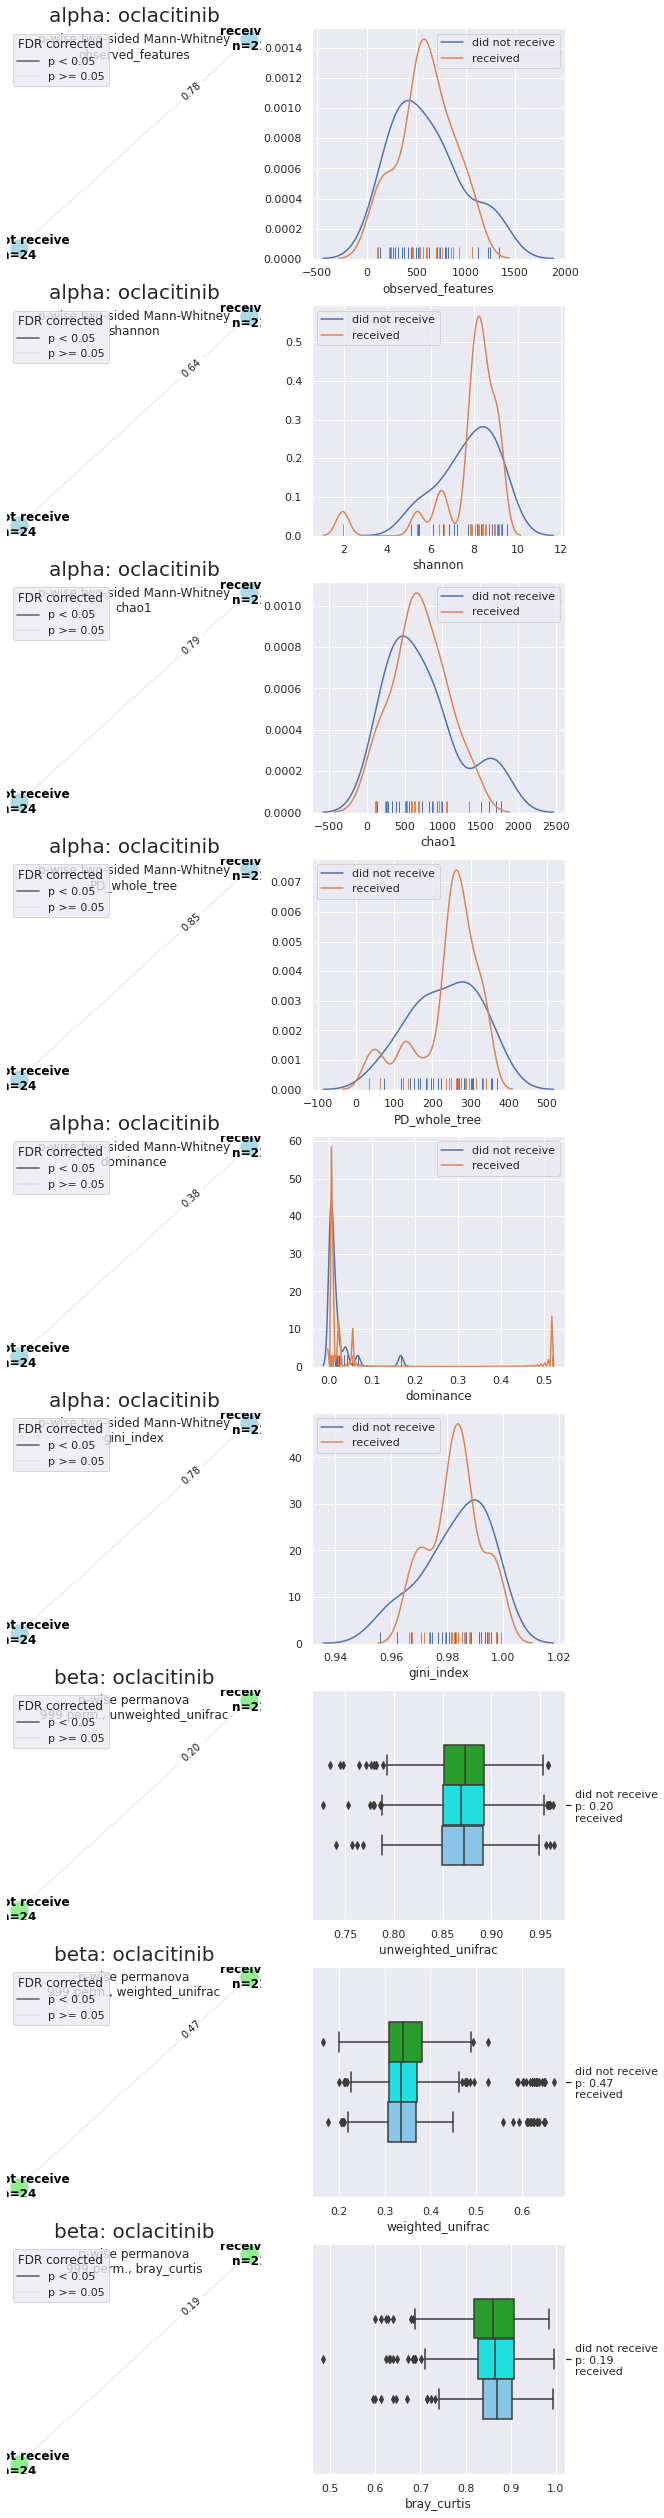

In [95]:
plotNetworks('oclacitinib', meta[meta['host_health_status'] == 'allergic'], res_silva['alpha_diversity']['results'], beta=res_silva['beta_diversity']['results'], minnumalpha=0)
plotNetworks('oclacitinib', meta[meta['host_health_status'] == 'allergic'], res_deblur['alpha_diversity']['results'], beta=res_deblur['beta_diversity']['results'], minnumalpha=0)

#### Composition (most abundant taxa) of the skin of allergic versus non-allergic GSDs
<font color="orange">
I omit these statements, since I don't think it is relevant. We already tested for sig. different abundant taxa. Looking at taxonomy plots won't help much.</font>

## Discussion
These studies used different techniques, from sample collection and storage, to DNA extraction and analysis and as shown before, methodology influences results [42–44]. Therefore, a direct side by side comparison of studies is difficult [42].

<font color="orange">can we get their sequencing data and run a meta analysis?</font>

and body site variability between the different study subjects

<font color="red">no</font>

<font color="orange">Let's talk about discussion contents once we agree on results :-)</font>

# Messed up data?

<font color="orange">I am a bit worried about potential sample swaps or at least meta data swaps. Looks like dogs 25 and 26 stick out a lot (but not with all their samples?) same with household_id, which otherwise shows a nice pattern</font>

5 changes in metadata fixed the household ID issue.
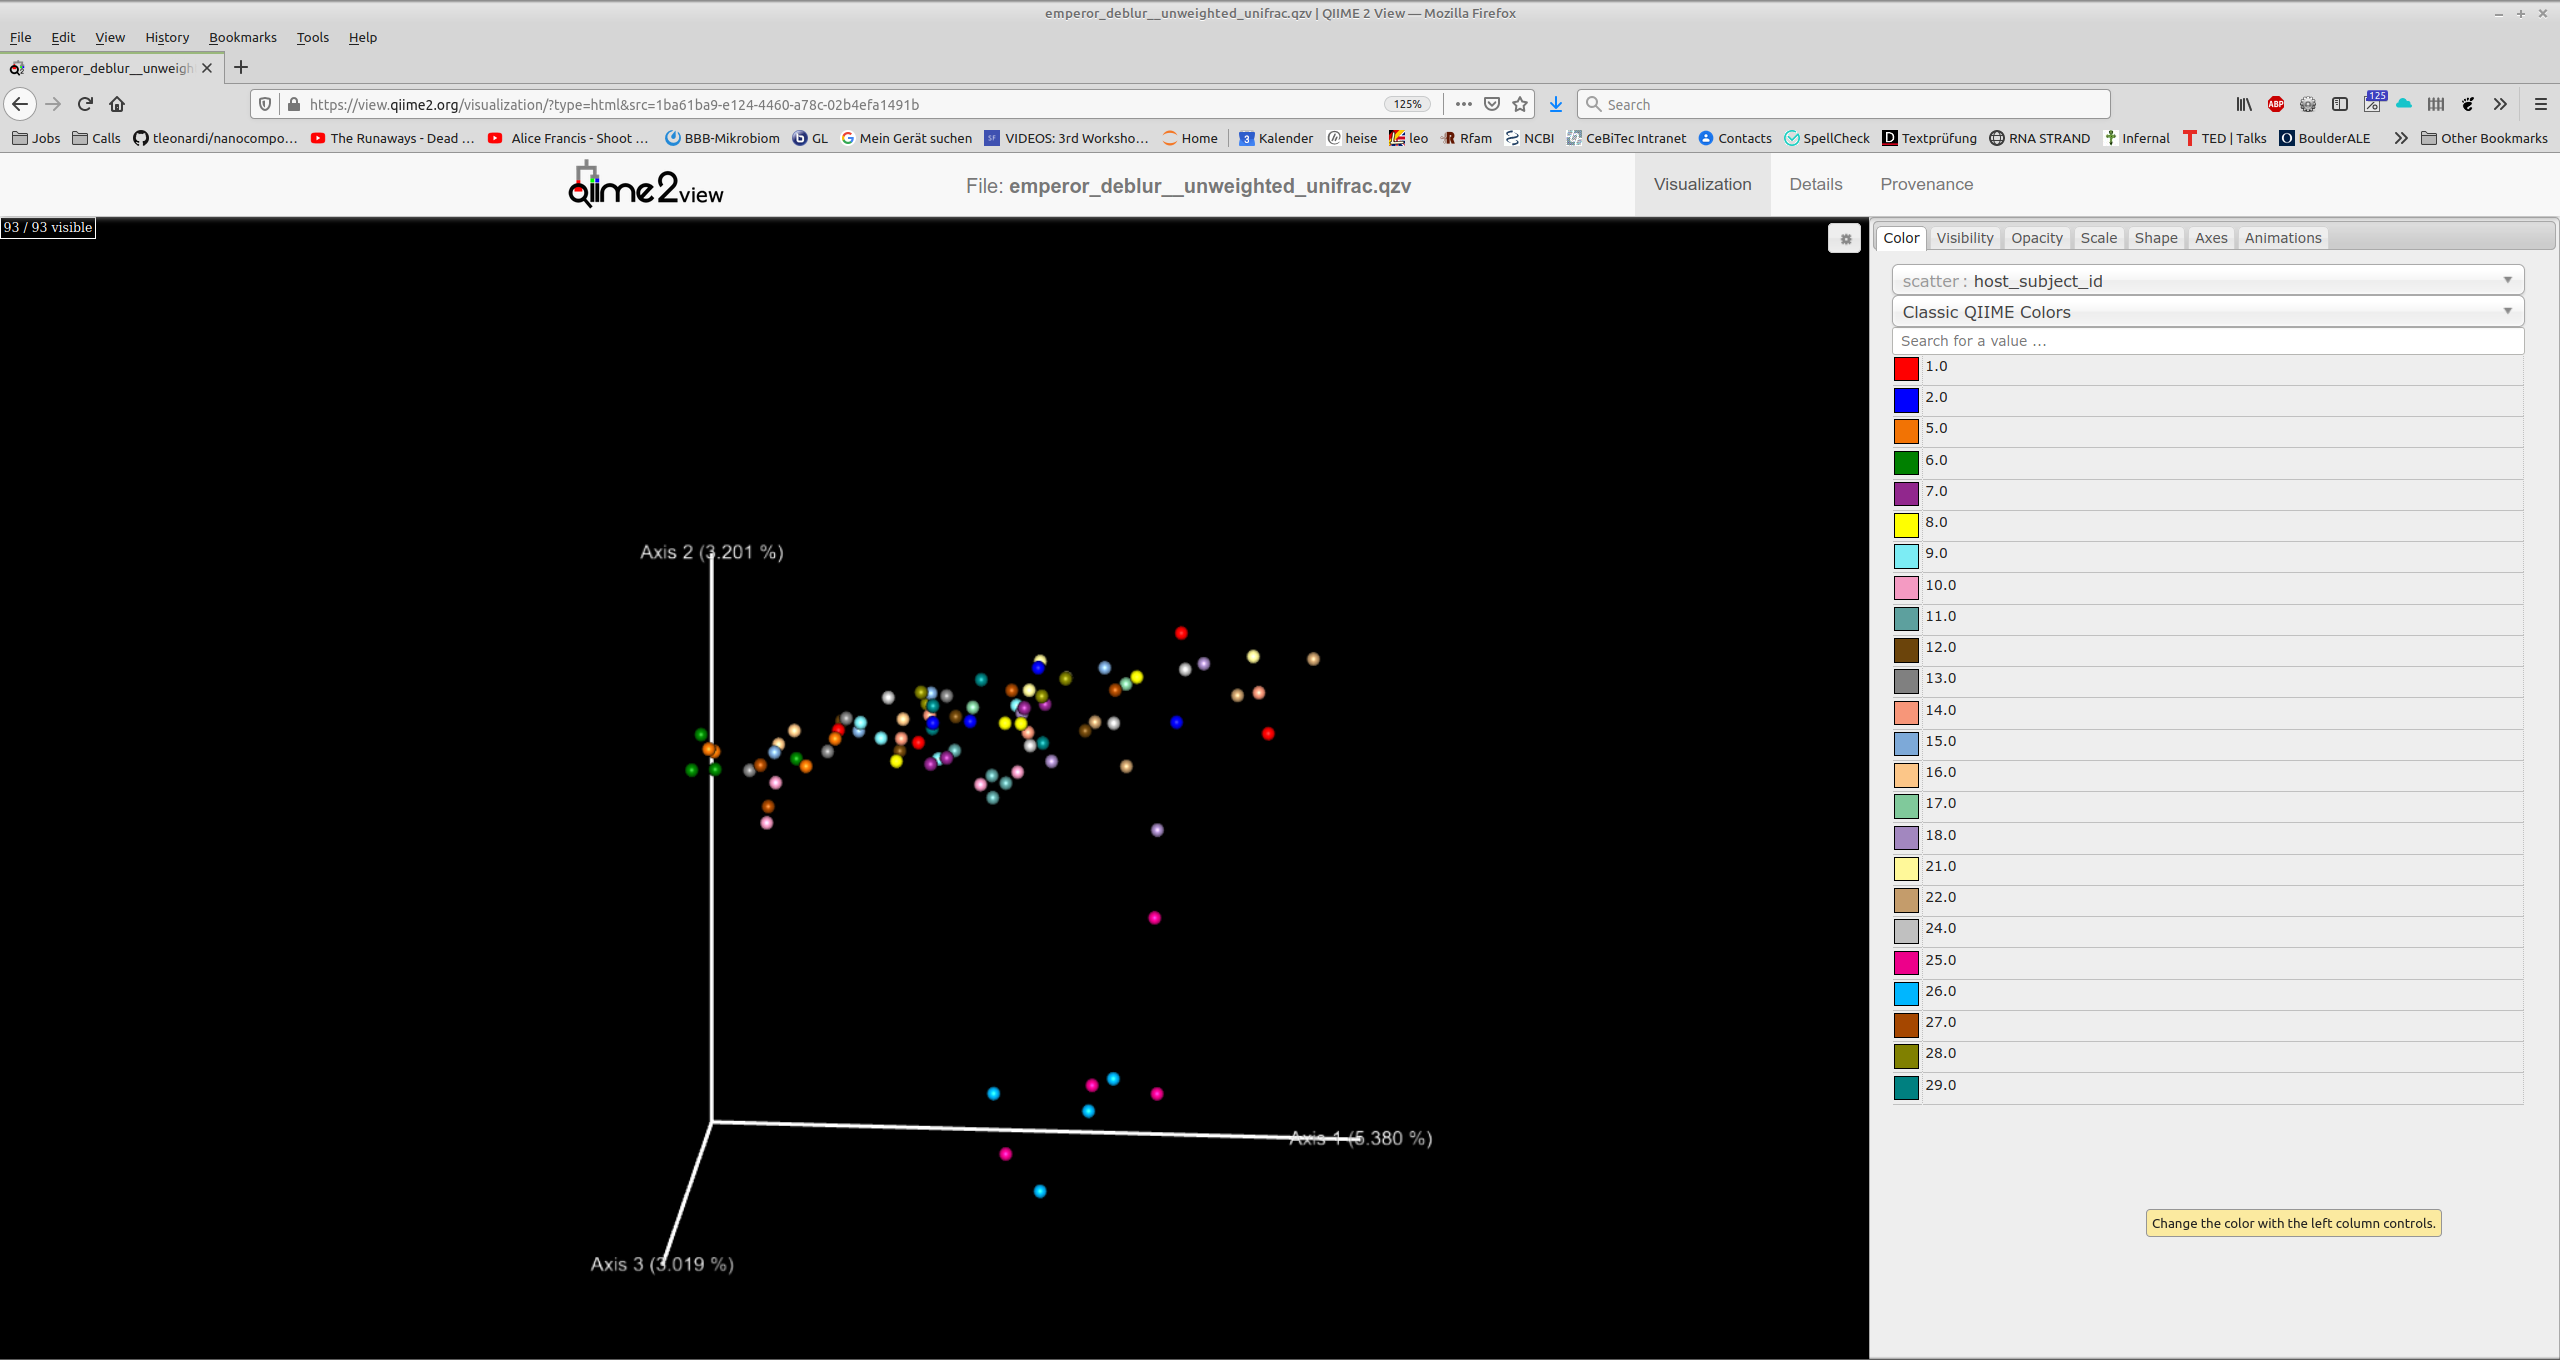

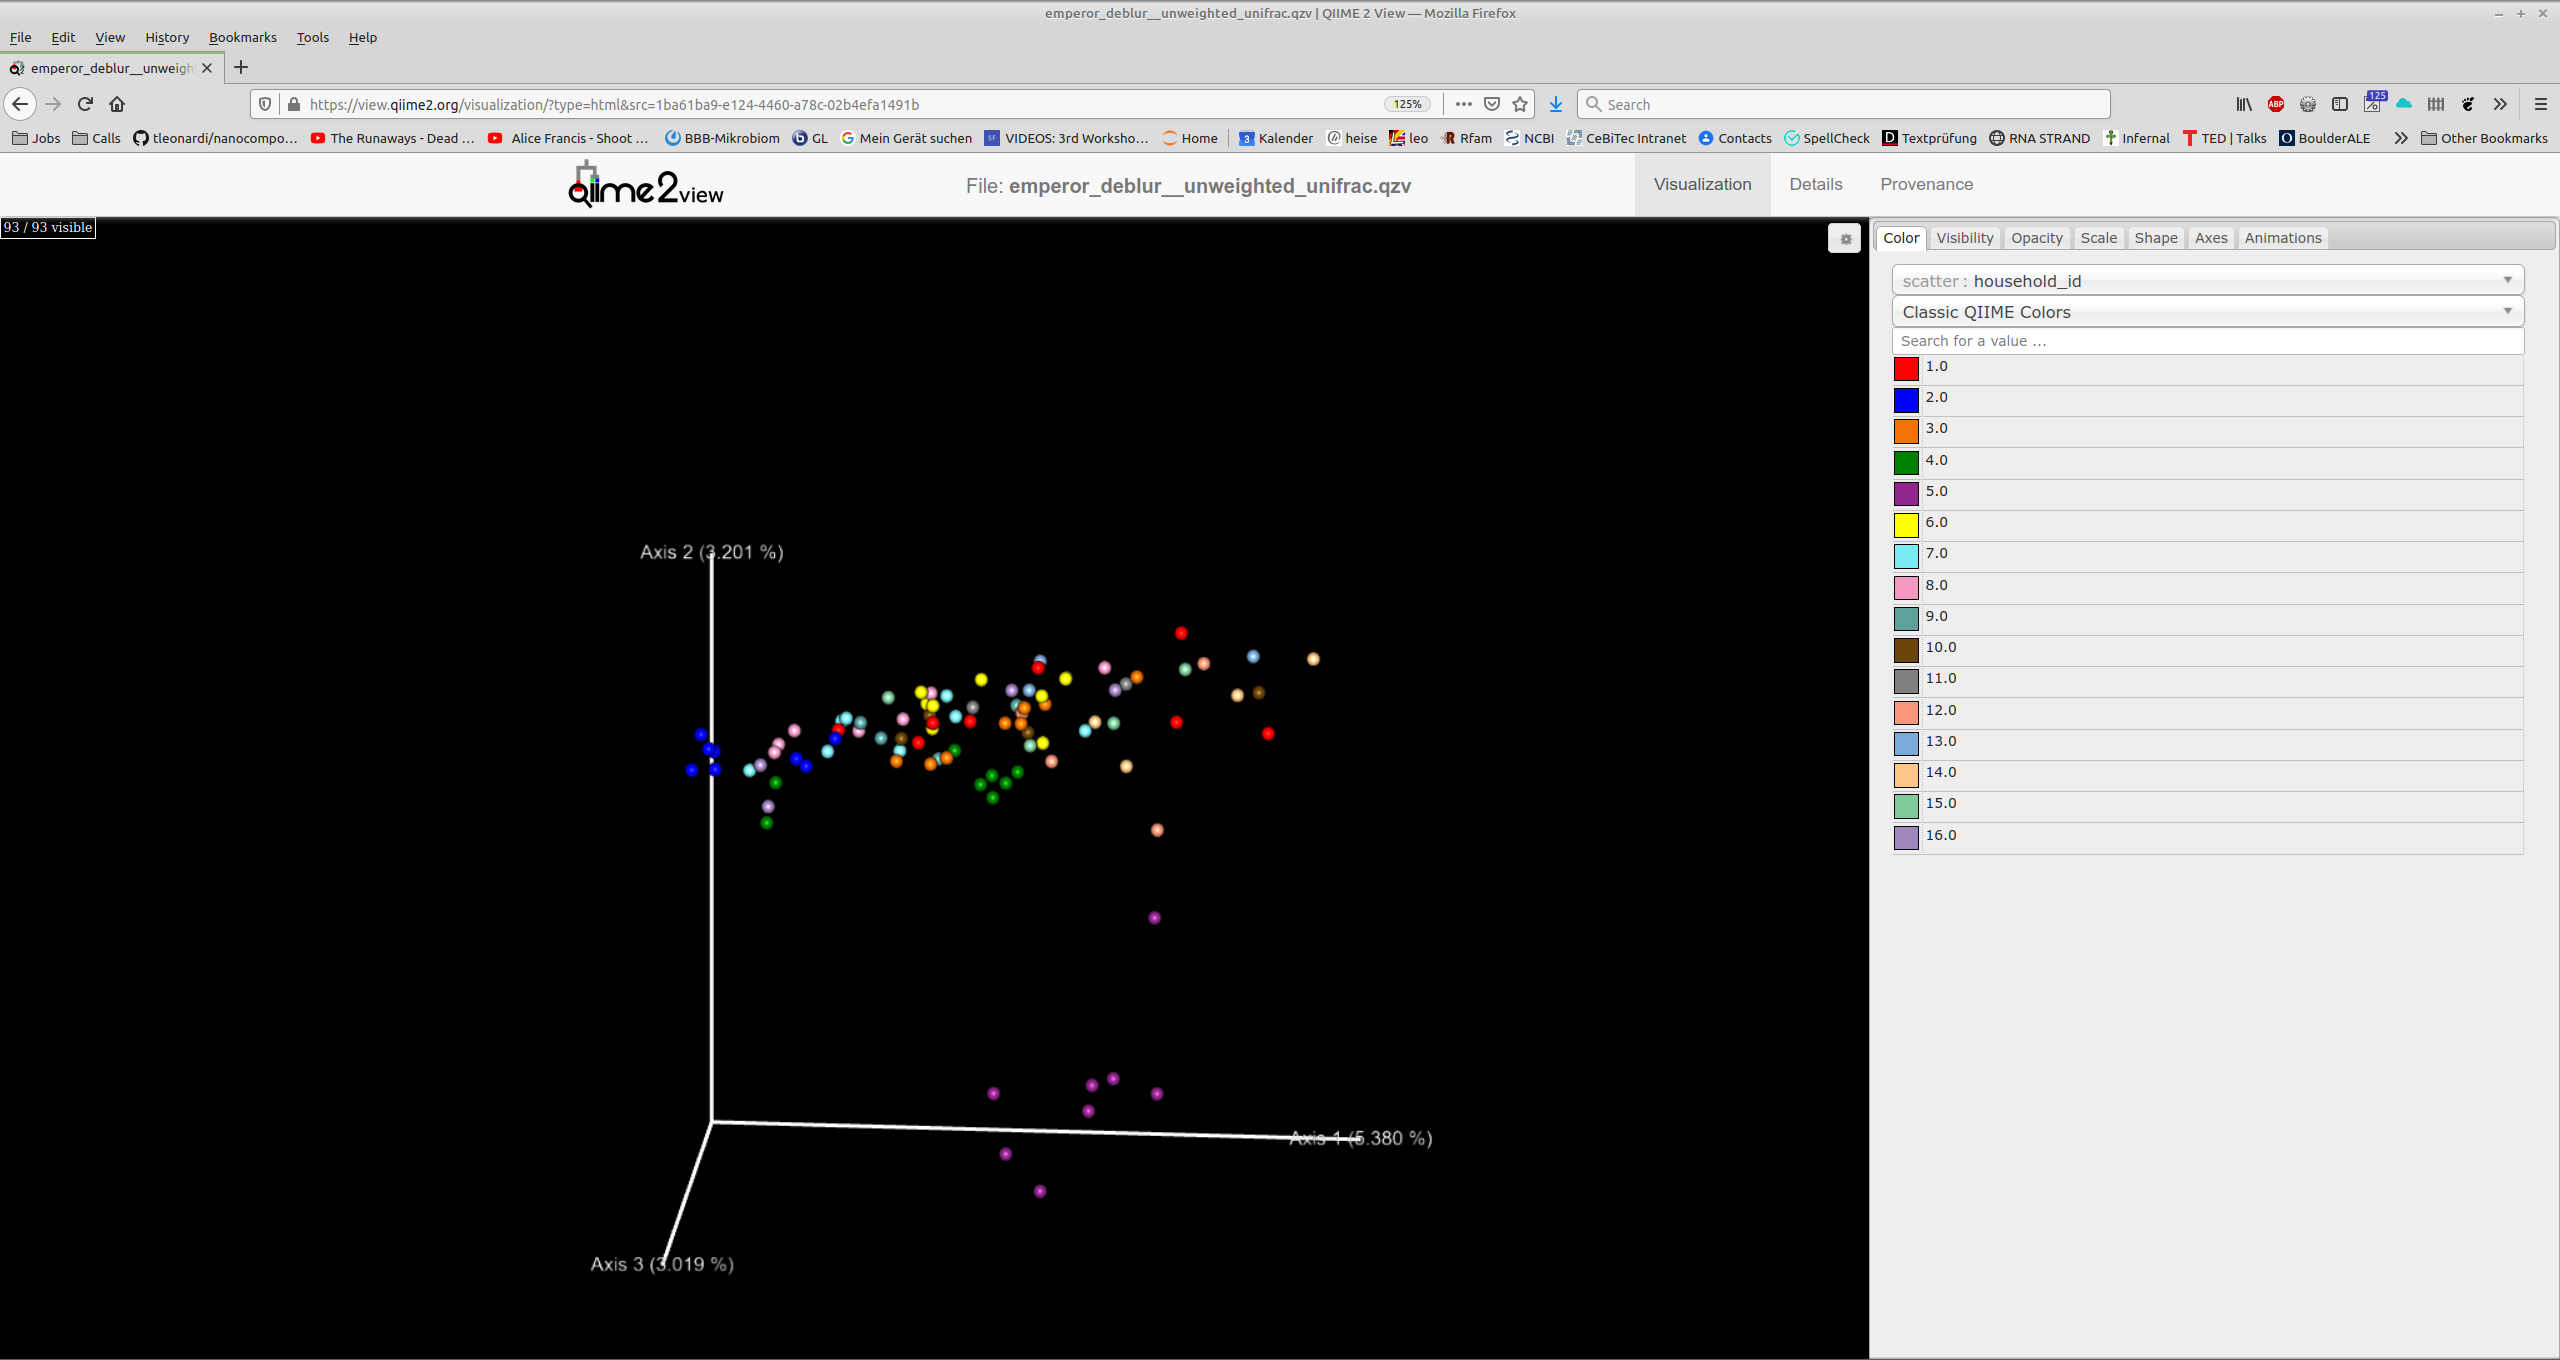

# Addressing reviewers comments
Please submit your revised manuscript by Oct 02 2020 11:59PM. If you will need more time than this to complete your revisions, please reply to this message or contact the journal office at plosone@plos.org.

<font color="orange">Did we ask for an extension?</font>

### Reviewer 1
We are sure that mistakes like that can happen to anyone especially to someone busy as you.

<font color="red">Very impolite!</font>


- line 103-105: by specifically mentioning the need for 2 non-allergic GSDs per household I was triggered. Why 2 and not more? Maybe better to replace 'required' by 'included'? And if this is required in non-allergic dogs, why not in allergic dogs? I realize that it will not be feasible to include two allergic dogs per household, but this sentence triggered me.

<font color="orange">From effect size estimation, we know that household plays a major role in the microbiome. We can also see this by PCoA (clustering by household). It remains unclear if this in fact is not clustering by individual (as we observed in the Skin Cosmetics study for human: https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-019-0660-6). I feel we need to better argue for this requirement. I would have thought ideal scenario is one allergic and one non-allergic dog per household to exclude the environmental exposure difference, like different diet, different amount of activity, bathing frequency, .... since one might assume that care takes treat dogs similarly.</font>

### Reviewer 2

I found the authors’ approach of testing variables (disease state, body site, etc.) singly rather than in a multi-factor model an uncommon choice, and I think the paper needs either a revised statistical approach or a strong a priori explanation and justification of this choice. 

For the alpha diversity metrics and microbial community composition, I am not convinced that the approach of testing factors singly (body site, allergic state) is the most appropriate choice. Why not a more traditional 2-factor or 3-factor test or a linear mixed model (to account for samples from the same animal), followed pairwise testing as appropriate? As written, it is difficult to compare the relative importance of body site and allergic status in alpha diversity or community composition, which in my opinion is an interesting question.

<font color="orange">I agree. My recommendation is to first to forward step redundancy analysis with generalized linear models and from thereon stratefy by major effect sizes.</font>

For differential abundance of specific taxa, it appears that not all taxa were tested, i.e., there was some selection process applied to the taxa. I think this section needs at minimum a more explicit explanation and justification for how the taxa for testing were selected, or (preferably) a method such as ANCOM (Mandal et al 2015, Microbial Ecology in Health and Disease), gneiss (Morton et al 2017, mSystems), corncob (Martin et al 2020, Annals of Applied Statistics), or similar, that accounts for the characteristics of microbiome data and tests all taxa. Also, there is no language here (lines 242-244) about multiple test correction where multiple taxa were tested, was this applied? If not, it absolutely should be.

<font color="orange">A qualified reviewer :-) He/She is absolutely right. There is no good reason to limit rel. abundance tests to just the four most dominant taxa. I cannot think of a reason why only those dominant guys should tend to be different. ANCOM is relatively conservative, I therefore choose discrete false discovery rate (https://msystems.asm.org/content/2/6/e00092-17.short), which is basically a multiple hypthesis testing correction + t-tests per feature</font>

Is there evidence that skin microbiome studies are replicable across time in the same animal, either in dogs or other species? What have studies in other animals shown about the consistency of skin microbiomes between different studies, using different techniques? Is the level of disagreement between studies that is discussed here typical of skin microbiome studies, or is it unique to dogs?

<font color="orange">Very good questions. But answering them would require a whole set of new studies and a lot more samples. From the mentioned skin study in human, I know that the skin microbiome is very different between individuals. Thus, I think a major cause of different results are different sampled animals. A time series for same individuals between flares and remissions might be a better study design. Future work ;-)</font>

Regarding the significant difference in the age of healthy vs. allergic dogs, I appreciate this being discussed as a caveat. It might be useful to add more detail: when does this transition to an “older” skin microbiome start to happen, based on the literature? Is this a similar life stage to either group of dogs in the study For example, are skin microbiome changes only observed in geriatric humans? Dogs in the healthy group are not yet (on average) geriatric.

<font color="orange">Another good question. It is accepted that the gut microbiome "matures" in human and reaches relative stability within the first three years of life. I see similar trends in mice and other animals. However, this is all GUT microbiome. I am not aware (but haven't search for) similar studies regarding the development of skin microbiome. But it is very likely that there are major changes in the first life stages. Can we consider all dogs as adults? If so - my gut feeling says - that the skin microbiome should already have established to a relatively stable form.</font>

Is count data meant by “absolute abundance data”? It seems like the absolute abundance of microbes is not possible to measure with the methods described, because there is no normalization of read counts to amount of DNA, biomass, etc. Please clarify.

<font color="orange">I agree. Bacterial load would be great to have, but with amplicon sequencing we cannot obtain it. Thus, everything is always relative. I would use the term "frequency" or "unnormalized abundance"</font>

Becauses chloroplasts and other removed taxa made up ~20% of the reads, I’d like to see how many reads there were per sample (or at least a min and max) after filtering out these taxa and no-relative reads.

In [96]:
(res_deblur['counts_plantsStillIn'].sum() - res_deblur['counts_plantsremoved'].sum()).sort_values()

13434.A21INT       0
13434.1L           0
13434.2L           0
13434.A18O        47
13434.A16O        50
                ... 
13434.A17L      2450
13434.A12L      2814
13434.A9L       3687
13434.A13O      3831
13434.A12INT    4384
Length: 96, dtype: int64

# Metaanalyses
 - Hoffmann AR, Patterson AP, Diesel A, Lawhon SD, Ly HJ, Stephenson CE, et al. The Skin Microbiome in Healthy and Allergic Dogs. PLOS ONE. 2014; 9: e83197. doi: 10.1371/journal.pone.0083197.
   - = reference 13
   - data available: SRP028524 
   - platform 454 
 - Bradley CW, Morris DO, Rankin SC, Cain CL, Misic AM, Houser T, et al. Longitudinal Evaluation of the Skin Microbiome and Association with Microenvironment and Treatment in Canine Atopic Dermatitis. J Invest Dermatol. 2016; 136: 1182-1190. doi: 10.1016/j.jid.2016.01.023.
   - = reference 14
   - data available: PRJNA302288 
   - platform: Illumina MiSeq
   - fragment: V1-V3 
   - 2x346 readfiles
   - primers 27F (5′-AGAGTTTGATCCTGGCTCAG-3′) and 534R (5′-ATTACCGCGGCTGCTGG-3′). 
   - metadata: https://www.ncbi.nlm.nih.gov/biosample/SAMN04274486

In [ ]:
#for f in `cat ../filereport_read_run_PRJNA302288_tsv.txt | grep -v "^study_accession"  | cut -f 30 | tr ";" "\n"`; do echo $f; bf=`basename $f`; test -f $bf || wget $f;  done

In [ ]:
md5_is = pd.read_csv('Incoming/ENA_Bradley/md5.sums', sep="  ", header=None).set_index(1).rename(columns={0: 'is'})
md5_should = pd.read_csv('Incoming/filereport_read_run_PRJNA302288_tsv.txt', sep="\t")[['fastq_md5', 'fastq_ftp']]
md5_should = pd.Series(index=pd.concat([md5_should['fastq_ftp'].apply(lambda x: basename(x.split(';')[p])) for p in [0,1]]).values,
                       data=pd.concat([md5_should['fastq_md5'].apply(lambda x: basename(x.split(';')[p])) for p in [0,1]]).values).to_frame().rename(columns={0: 'should'})
md5 = pd.concat([md5_is, md5_should], sort=False, axis=1)
assert(md5[md5['is'] != md5['should']].shape[0] == 0)

pre = pd.Series(md5.index).apply(lambda x: x[:7]).value_counts().index[0]
suf = pd.Series(md5.index).apply(lambda x: x[12:]).value_counts().index[0]
inf = ','.join(sorted(pd.Series(md5.index).apply(lambda x: x[7:10]).value_counts().index))

"/homes/sjanssen/Git/sjanssen2/spike/DATA/Intermediate/041_remove_16s_primer/ENA_Bradley/%s{%s}_R{1,2}%s" % (pre, inf, suf)

In [ ]:
meta_prep_grice = pd.read_csv('Incoming/filereport_read_run_PRJNA302288_tsv.txt', sep="\t").set_index('sample_title')[["tax_id","scientific_name","instrument_platform","instrument_model",'fastq_ftp']].rename(columns={'instrument_platform': 'platform'})

meta_prep_grice['primer'] = 'FWD: AGAGTTTGATCCTGGCTCAG; RWV: ATTACCGCGGCTGCTGG'
meta_prep_grice['sequencing_method'] = 'Sequencing by synthesis'
meta_prep_grice['target_gene'] = '16S rRNA'
meta_prep_grice['target_fragment'] = 'V1-V3'
meta_prep_grice['run_prefix'] = meta_prep_grice['fastq_ftp'].apply(lambda x: basename(x.split(';')[0])[:10])
del meta_prep_grice['fastq_ftp']

meta_prep_grice['description'] = 'grice dog skin'

meta_prep_grice[['platform','instrument_model','primer', 'sequencing_method','target_gene','target_fragment','run_prefix']].to_csv('grice_prep.txt', sep="\t", index_label='sample_name')
#meta_prep_grice[['description','scientific_name','tax_id']].to_csv('grice_sample.txt', sep="\t", index_label='sample_name')

In [ ]:
root = ET.parse('Incoming/biosample_result.xml').getroot()
samples = []
for tag_sample in root.findall('BioSample'):
    m = dict()
    for tag_ids in tag_sample.findall('Ids'):
        for tag_id in tag_ids.findall('Id'):
            if ('db_label' in tag_id.keys()) and (tag_id.attrib['db_label'] == 'Sample name'):
                m['sample_name'] = tag_id.text
    for tag_l1 in tag_sample.findall('Description'):
        for tag_l2 in tag_l1.findall('Organism'):
            if ('taxonomy_id' in tag_l2.keys()):
                m['taxid'] = tag_l2.attrib['taxonomy_id']
            if ('taxonomy_name' in tag_l2.keys()):
                m['common name'] = tag_l2.attrib['taxonomy_name']
    for tag_l1 in tag_sample.findall('Package'):        
        if ('display_name' in tag_l1.keys()):
            m['env_package'] = tag_l1.attrib['display_name'].split(',')[1].split(';')[0].strip()
    for tag_l1 in tag_sample.findall('Attributes'):
        for tag_l2 in tag_l1.findall('Attribute'):
            m[tag_l2.attrib['attribute_name']] = tag_l2.text
    
    samples.append(m)
m_grice = pd.DataFrame(samples).set_index('sample_name').rename(columns={
    'collection_date': 'collection_timestamp',
    'common name': 'scientific_name',
    'host': 'host_scientific_name',
    'SiteID': 'host_body_site',
    'Age': 'host_age_days',
    'Sex': 'sex',
    'well': 'plate_well'
})

del m_grice['lat_lon']
del m_grice['run']
del m_grice['SampleID']
#del m_grice['SubjectNumber_Timepoint_SiteID']
del m_grice['Title']
del m_grice['RunName']
del m_grice['WellPosition']

m_grice['description'] = 'grice dog skin'

m_grice['empo_1'] = 'Host-associated'
m_grice['empo_2'] = 'Animal-associated'
m_grice['empo_3'] = 'Animal surface'
m_grice['env_biome'] = 'urban biome'
m_grice['env_feature'] = 'animal-associated habitat'
m_grice['env_material'] = 'sebum'
m_grice['env_package'] = 'host-associated'

m_grice['host_age_units'] = 'years'
m_grice['host_age'] = m_grice['host_age_days'].apply(lambda x: int(int(x)/365))
m_grice['host_body_habitat'] = 'UBERON:skin'
m_grice['host_body_product'] = 'UBERON:sebum'
m_grice['sample_type'] = 'skin'
m_grice['host_subject_id'] = m_grice['SubjectNumber_Timepoint_SiteID'].apply(lambda x: x.split('v')[0])
del m_grice['SubjectNumber_Timepoint_SiteID']

m_grice.to_csv('grice_sample.txt', sep="\t", index_label='sample_name')

m_grice.T

## Post Qiita

In [ ]:
meta_grice = pd.concat([
    # read metadata
    pd.concat([pd.read_csv('FromQiita/13491_20201128-064501.txt', sep="\t", dtype=str, na_values=na_values).set_index('sample_name') for file in fps['meta'].values()], axis=0, sort=False),
    # read prep data
    pd.concat([pd.read_csv('FromQiita/13491_prep_9895_20201127-074841.txt', sep="\t", dtype=str, na_values=na_values).set_index('sample_name') for file in fps['prep'].values()], axis=0, sort=False).rename(columns={'description': 'description_prep'})
], sort=False, axis=1)
meta_grice.head()

## Deblur

In [ ]:
meta_both = pd.concat([meta, meta_grice], sort=False)

fp_deblur_both = '%s/counts_deblur_both.biom' % fp_workdir
counts_both_deblur = pd.concat([biom2pandas(fps['deblur_150']['gsd']), biom2pandas("FromQiita/reference-hit.biom")], axis=1, sort=False).fillna(0)
pandas2biom(fp_deblur_both, counts_both_deblur)

fp_both_insertiontree = '%s/insertion_both.newick' % fp_workdir

# create one shared insertion tree
res_sepp_both = sepp(counts_both_deblur, chunksize=3000000, dry=False, wait=False, ppn=50, use_grid=False)
if not os.path.exists(fp_both_insertiontree):
    with open(fp_both_insertiontree, 'w') as f:
        f.write(res_sepp_both['results']['tree'].replace('k__Bacteria)', 'k__Bacteria:0.0)')+"\n")
%time insertion_tree_both = TreeNode.read(fp_both_insertiontree)

In [ ]:
res_both = process_study(
    metadata=meta_both,
    control_samples=set([]),
    fp_deblur_biom=fp_deblur_both,
    fp_insertiontree=fp_both_insertiontree,
    fp_closedref_biom=None,
    rarefaction_depth=4500,
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-nb-classifier_2020.2.qza',
    tree_insert=insertion_tree_both,
    is_v4_region=False,
    fix_zero_len_branches=False,
    emperor_fp=fp_generated+'/Emperor/',
    emperor_infix='_both_',
    dry=False,
    use_grid=True,
)

print('Overall, the study recovered %s sOTUs (from %s samples)' % res_both['rarefaction']['results'].shape)

In [ ]:
tax_gg138 = pd.read_csv('/vol/jlab/MicrobiomeAnalyses/References/gg_13_5_otus/taxonomy/97_otu_taxonomy.txt', sep="\t", index_col=0, header=None).rename(columns={1: 'Taxon'})
tax_gg138.index = list(map(str, tax_gg138.index))

In [ ]:
taxonomy = []
for i, fragment in enumerate(counts_both_deblur.index):
    if i % 2000 == 0:
        print(i, file=sys.stderr)
    # for every inserted fragment we now try to find the closest OTU tip
    # in the tree and available mapping from the OTU-ID to a lineage
    # string:
    lineage_str = np.nan
    # first, let us check if the fragment has been inserted at all ...
    try:
        curr_node = insertion_tree_both.find(fragment)
    except skbio.tree.MissingNodeError:
        continue
    # if yes, we start from the inserted node and traverse the tree as less
    # as possible towards the root and check at every level if one or
    # several OTU-tips are within the sub-tree.
    if curr_node is not None:
        foundOTUs = []
        # Traversal is stopped at a certain level, if one or more OTU-tips
        # have been found in the sub-tree OR ... (see break below)
        while len(foundOTUs) == 0:
            # SEPP insertion - especially for multiple very similar
            # sequences - can result in a rather complex topology change
            # if all those sequences are inserted into the same branch
            # leading to one OTU-tip. Thus, we cannot simply visit only
            # all siblings or decendents and rather need to traverse the
            # whole sub-tree. Average case should be well behaved,
            # thus I think it is ok.
            for node in curr_node.postorder():
                if (node.name is not None) and \
                   (node.name in tax_gg138.index):
                    # if a suitable OTU-tip node is found AND this OTU-ID
                    # has a mapping in the user provided reference_taxonomy
                    # we store the OTU-ID in the growing result list
                    foundOTUs.append(node.name)
            # ... if the whole tree has been traversed without success,
            # e.g. if user provided reference_taxonomy did not contain any
            # matching OTU-IDs.
            if curr_node.is_root():
                break
            # prepare next while iteration, by changing to the parent node
            curr_node = curr_node.parent

        if len(foundOTUs) > 0:
            # If the above method has identified exactly one OTU-tip,
            # resulting lineage string would simple be the one provided by
            # the user reference_taxonomy. However, if the inserted
            # fragment cannot unambiguously places into the reference tree,
            # the above method will find multiple OTU-IDs, which might have
            # lineage strings in the user provided reference_taxonomy that
            # are similar up to a certain rank and differ e.g. for genus
            # and species.
            # Thus, we here find the longest common prefix of all lineage
            # strings. We don't operate per character, but per taxonomic
            # rank. Therefore, we first "convert" every lineage sting into
            # a list of taxa, one per rank.
            split_lineages = []
            for otu in foundOTUs:
                # find lineage string for OTU
                lineage = tax_gg138.loc[otu, 'Taxon']
                # necessary to split lineage apart to ensure that
                # the longest common prefix operates on atomic ranks
                # instead of characters
                split_lineages.append(list(
                    map(str.strip, lineage.split(';'))))
            # find the longest common prefix rank-wise and concatenate to
            # one lineage string, separated by ;
            lineage_str = "; ".join(os.path.commonprefix(split_lineages))
        taxonomy.append({'Feature ID': fragment,
                         'Taxon': lineage_str})
pd_taxonomy = pd.DataFrame(taxonomy)

### Voom SNM Deblur

In [ ]:
c = pickle.load(open('.anacache/11a29f615b60a4db33352415add60c39.rarefy','rb'))['results']
c.loc[:, set(meta_both.index) & set(c.columns)].to_csv('%s/voom/counts.csv' % fp_workdir, sep=",", index_label='feature')
#res_both['rarefaction']['results'].to_csv('%s/voom/counts.csv' % fp_workdir, sep=",", index_label='feature')

meta_both['qiita_study_id'] = meta_both['qiita_study_id'].apply(lambda x: 'study_' + x)
meta_both['host_age'] = meta_both['host_age'].apply(lambda x: 'years_' + x)

meta_both.loc[set(meta_both.index) & set(c.columns),:].to_csv('%s/voom/metadata.csv' % fp_workdir, sep=",", index_label='sample_name', quoting=csv.QUOTE_ALL)

In [ ]:
import os, warnings
import pandas as pd
import csv
import seaborn as sns
import numpy as np

os.environ['R_HOME'] = '/homes/sjanssen/miniconda3/envs/tcga/lib/R'
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython

In [ ]:
%%R
require(ggplot2)
require(snm)
require(limma)
require(edgeR)
require(dplyr)
require(edgeR)
require(pvca)
require(lme4)
require(ggsci)
require(cowplot)
require(doMC)
require(ggbiplot)

pcaPlotting <- function(pcaObject,pcChoices, dataLabels, factorString, titleString){
  #theme_update(plot.title = element_text(hjust = 0.5))
  g <- ggbiplot(pcaObject,pcChoices, obs.scale = 1, var.scale = 1,
                groups = dataLabels, ellipse = TRUE,
                alpha = 0.2,
                circle = TRUE,var.axes=FALSE) + 
    scale_color_nejm(name = factorString) +
    theme_bw() + 
    #theme(legend.direction = "horizontal", legend.position = "top") +
    ggtitle(titleString) + theme(plot.title = element_text(hjust = 0.5))
  
  print(g)
}

In [ ]:
%%R
qcMetadata <- read.table("Workdir/voom/metadata.csv", sep=",", header=TRUE) # metadataSamplesAllQCAML
print("Shape Metadata...")
print(dim(qcMetadata))

qcData <- read.csv("Workdir/voom/counts.csv", sep=",", row.names=1) # vbDataBarnDFReconciledQCAML
print("Shape counts...")
print(dim(qcData))


# Set up design matrix
covDesignNorm <- model.matrix(~0 + qiita_study_id
                                 + breed
                                 + host_age
                                 + host_body_site
                                 + sex
                              ,data = qcMetadata)

# Set up counts matrix
counts <- qcData

# Normalize using edgeR and then plug into voom
dge <- DGEList(counts = counts)
keep <- filterByExpr(dge, covDesignNorm)
dge <- dge[keep,,keep.lib.sizes=FALSE]
print("counts after keep")
print(dim(dge))

print("Now normalizing data...")
dge <- calcNormFactors(dge, method = "TMM")
print("Now applying voom on normalized data...")
vdge <- voom(dge, design = covDesignNorm, plot = TRUE, save.plot = TRUE, normalize.method="none")

In [ ]:
%%R
library(ggbiplot)
unnormalizedPCAPlotFA <- pcaPlotting(pcaObject = prcomp(t(vdge$E)),
                                   pcChoices = c(1,2),
                                   dataLabels = qcMetadata$age,
                                   factorString = "Batch",
                                   titleString = "PCA w/o Batch Correction")

In [ ]:
%%R
bio.var.sample.type <- model.matrix(~host_body_site+sex, data=qcMetadata)
adj.var <- model.matrix(~qiita_study_id, data=qcMetadata)

snmDataObjSampleTypeWithExpStrategyFA <- snm(raw.dat = vdge$E, 
                                             bio.var = bio.var.sample.type,
                                             adj.var = adj.var,
                                             rm.adj=TRUE,
                                             verbose = TRUE,
                                             diagnose = TRUE)
snmDataSampleTypeWithExpStrategyFA <- t(snmDataObjSampleTypeWithExpStrategyFA$norm.dat)

snmPCAPlotSampleTypeFA <- pcaPlotting(pcaObject = prcomp(snmDataSampleTypeWithExpStrategyFA),
                          pcChoices = c(1,2),
                          dataLabels = qcMetadata$experiment_number,
                          factorString = "Sequencing Center",
                          titleString = "PCA w/ SNM Correction\n(Target: Sample Type)")

In [ ]:
%%R
write.csv(snmDataSampleTypeWithExpStrategyFA,"Workdir/voom/voomsnm_counts.csv", row.names = colnames(vdge$E), col.names=TRUE)

In [ ]:
voom_counts = pd.read_csv('Workdir/voom/voomsnm_counts.csv', sep=",", index_col=0).T
voom_counts.columns = list(map(lambda x: x[1:], voom_counts.columns))
#voom_counts

res_voombeta = beta_diversity(voom_counts, reference_tree=fp_both_insertiontree, fix_zero_len_branches=True, dry=False, wait=False)
if res_voombeta['results'] is not None:
    res_voomemperor = emperor(meta_both, res_voombeta['results'], fp_results="./", infix='_voom', dry=False, wait=False)
#res_voomalpha = alpha_diversity(voom_counts, rarefaction_depth=rarefaction_depth, reference_tree=fp_insertiontree, fix_zero_len_branches=True, dry=False, wait=False)    


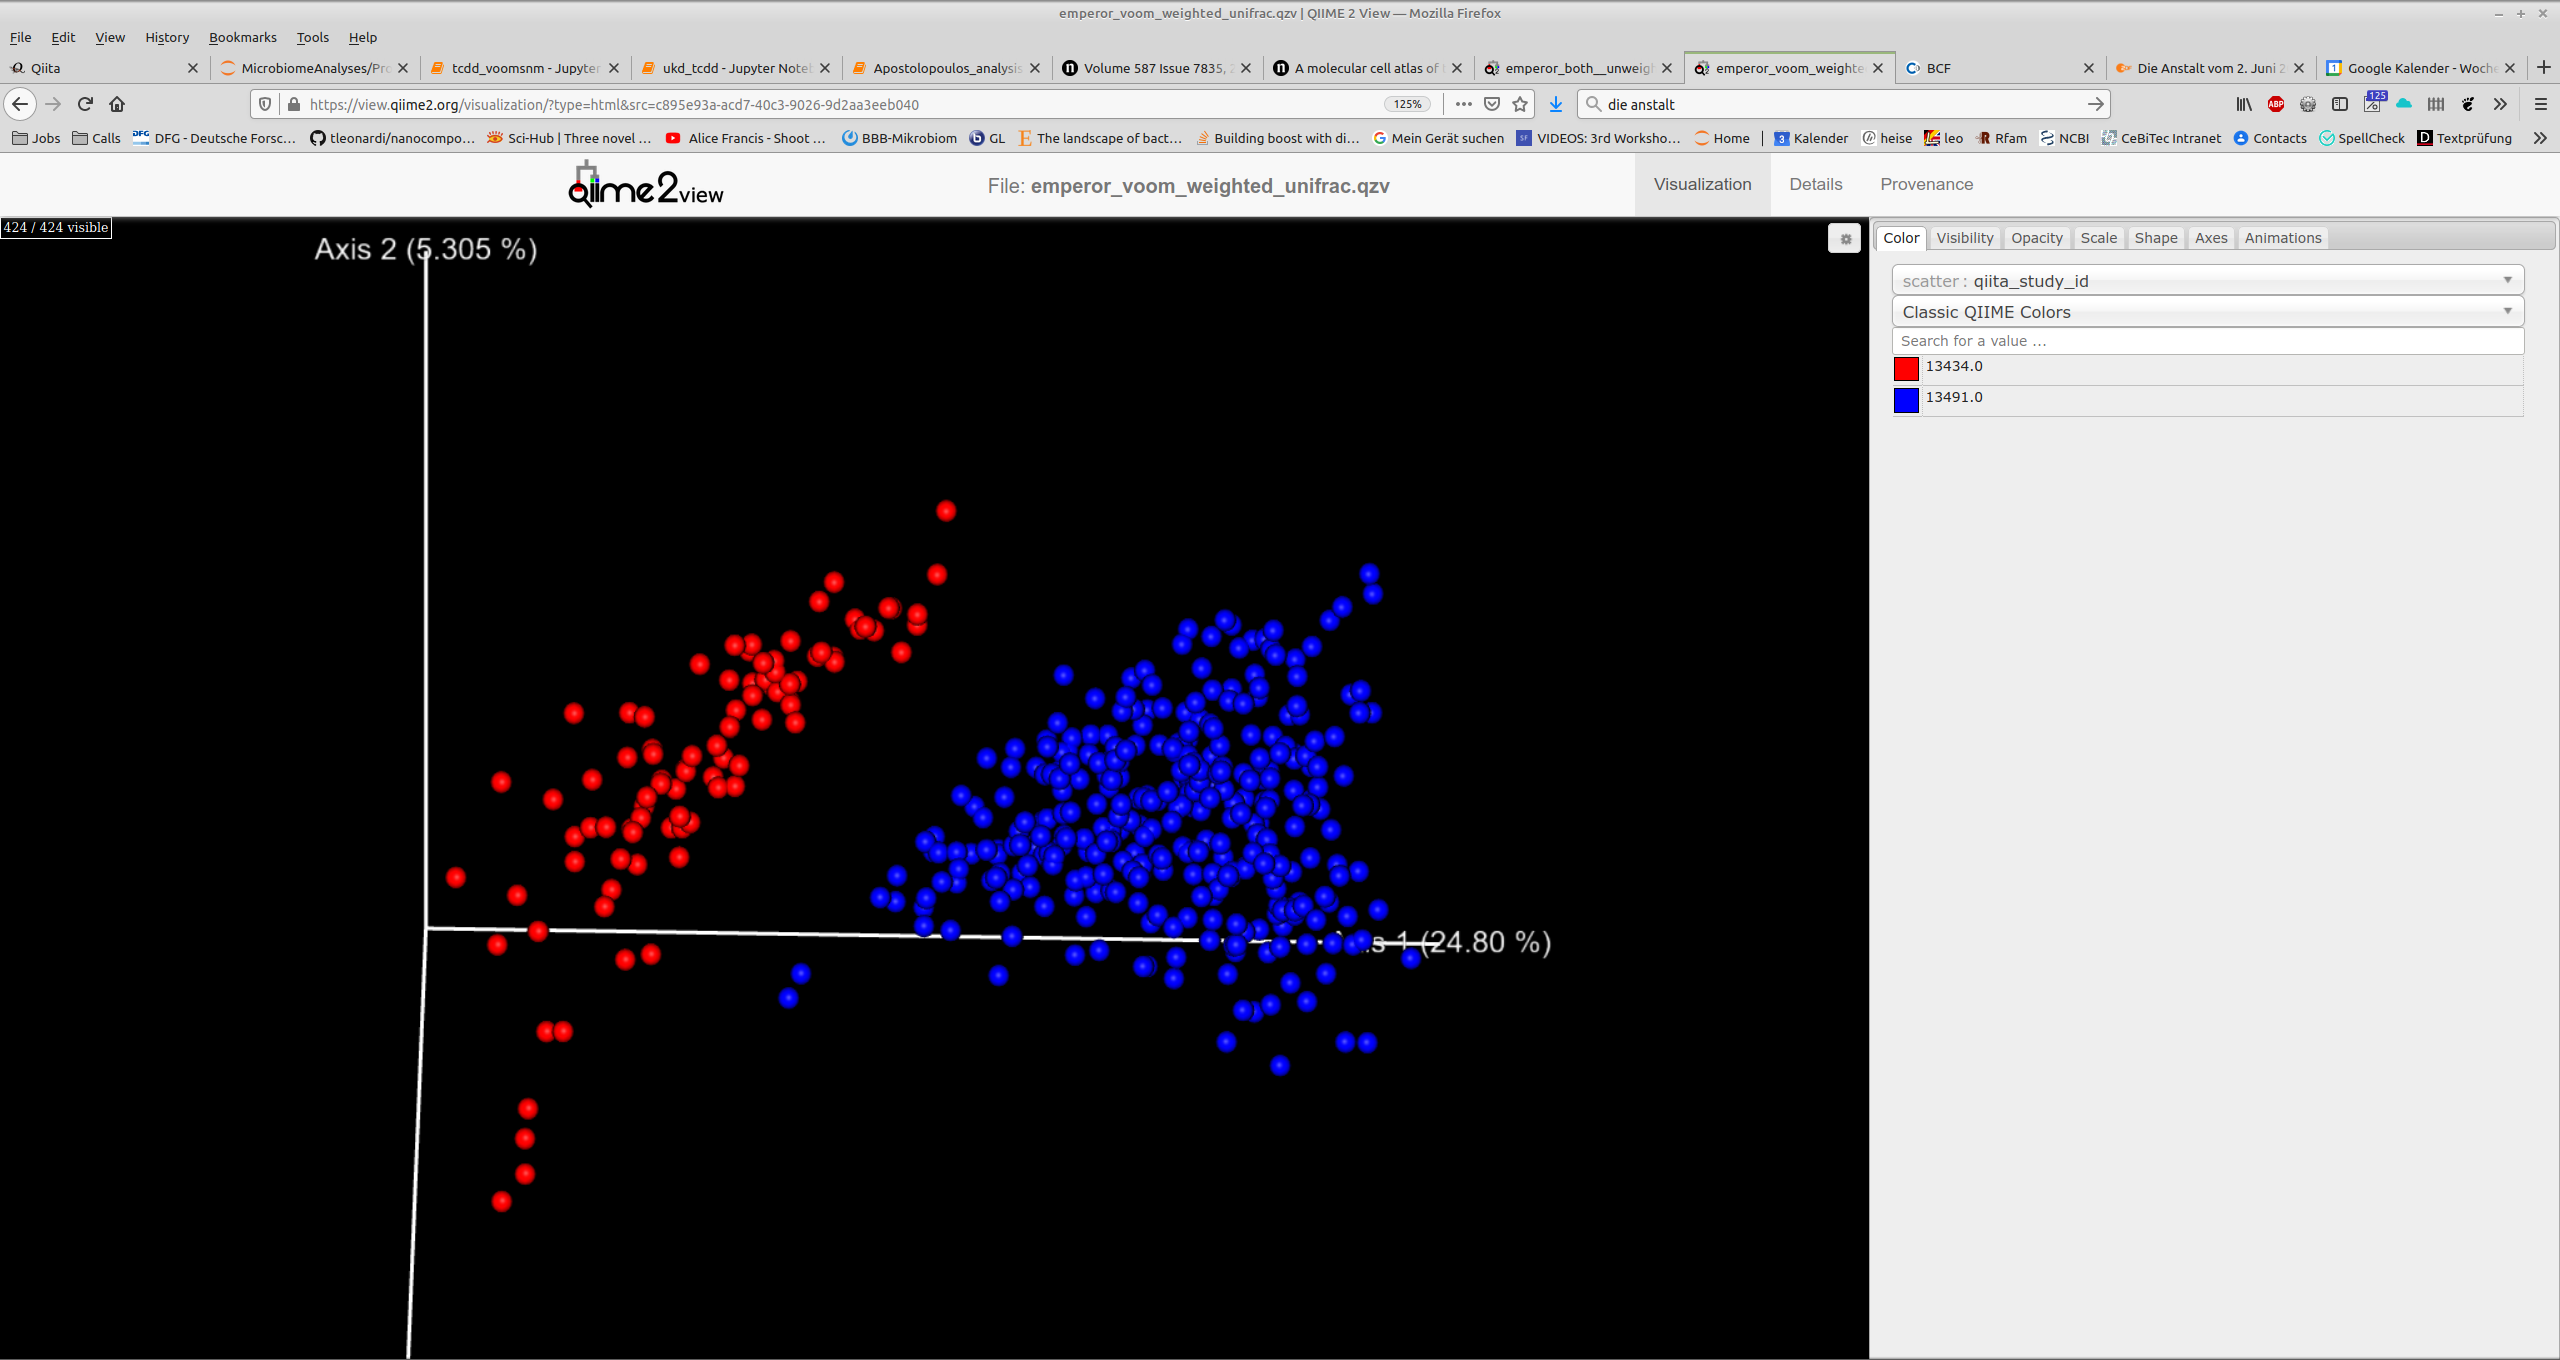

## ClosedRef GG 13.8
loosing way too many samples due to rarefaction!

In [ ]:
counts_both_gg13 = pd.concat([biom2pandas('FromQiita/103138_otu_table.biom'), biom2pandas('FromQiita/103116_otu_table.biom')], sort=False, axis=1).fillna(0)
taxonomy = pd.read_csv('/vol/jlab/MicrobiomeAnalyses/References/gg_13_5_otus/taxonomy/97_otu_taxonomy.txt', sep="\t", header=None, dtype=str).set_index(0)

# filter < 10 taxa
counts_both_gg13 = counts_both_gg13[counts_both_gg13.sum(axis=1) >= 10]

# filter chloro/mito
counts_both_gg13_taxonomy = counts_both_gg13.merge(taxonomy, left_index=True, right_index=True, how='left')
idx_chloroplast_mitochondria = counts_both_gg13_taxonomy[1].apply(lambda lineage: 'c__Chloroplast' in lineage or 'f__mitochondria' in lineage)
idx_chloroplast_mitochondria = idx_chloroplast_mitochondria[idx_chloroplast_mitochondria].index
counts_both_gg13 = counts_both_gg13.loc[sorted(list(set(counts_both_gg13.index) - set(idx_chloroplast_mitochondria))), :]

res_both_gg138 = dict()
res_both_gg138['rarefaction_curves'] = rarefaction_curves(counts_both_gg13, max_depth=3000, min_depth=10, reference_tree='/vol/jlab/MicrobiomeAnalyses/References/gg_13_5_otus/trees/97_otus.tree', dry=False, wait=False, use_grid=True, fix_zero_len_branches=True, dirty=True, nocache=True)
res_both_gg138['rarefaction'] = rarefy(counts_both_gg13, rarefaction_depth=2000, dry=False, wait=False, use_grid=True)
res_both_gg138['beta_diversity'] = beta_diversity(res_both_gg138['rarefaction']['results'].fillna(0), reference_tree='/vol/jlab/MicrobiomeAnalyses/References/gg_13_5_otus/trees/97_otus.tree', dry=False, wait=False, use_grid=True, fix_zero_len_branches=True)
res_both_gg138['emperor'] = emperor(meta_both, res_both_gg138['beta_diversity']['results'], fp_generated+'/Emperor/', infix='_both_', dry=False, wait=False, use_grid=True, walltime='00:20:00', pmem='8GB')

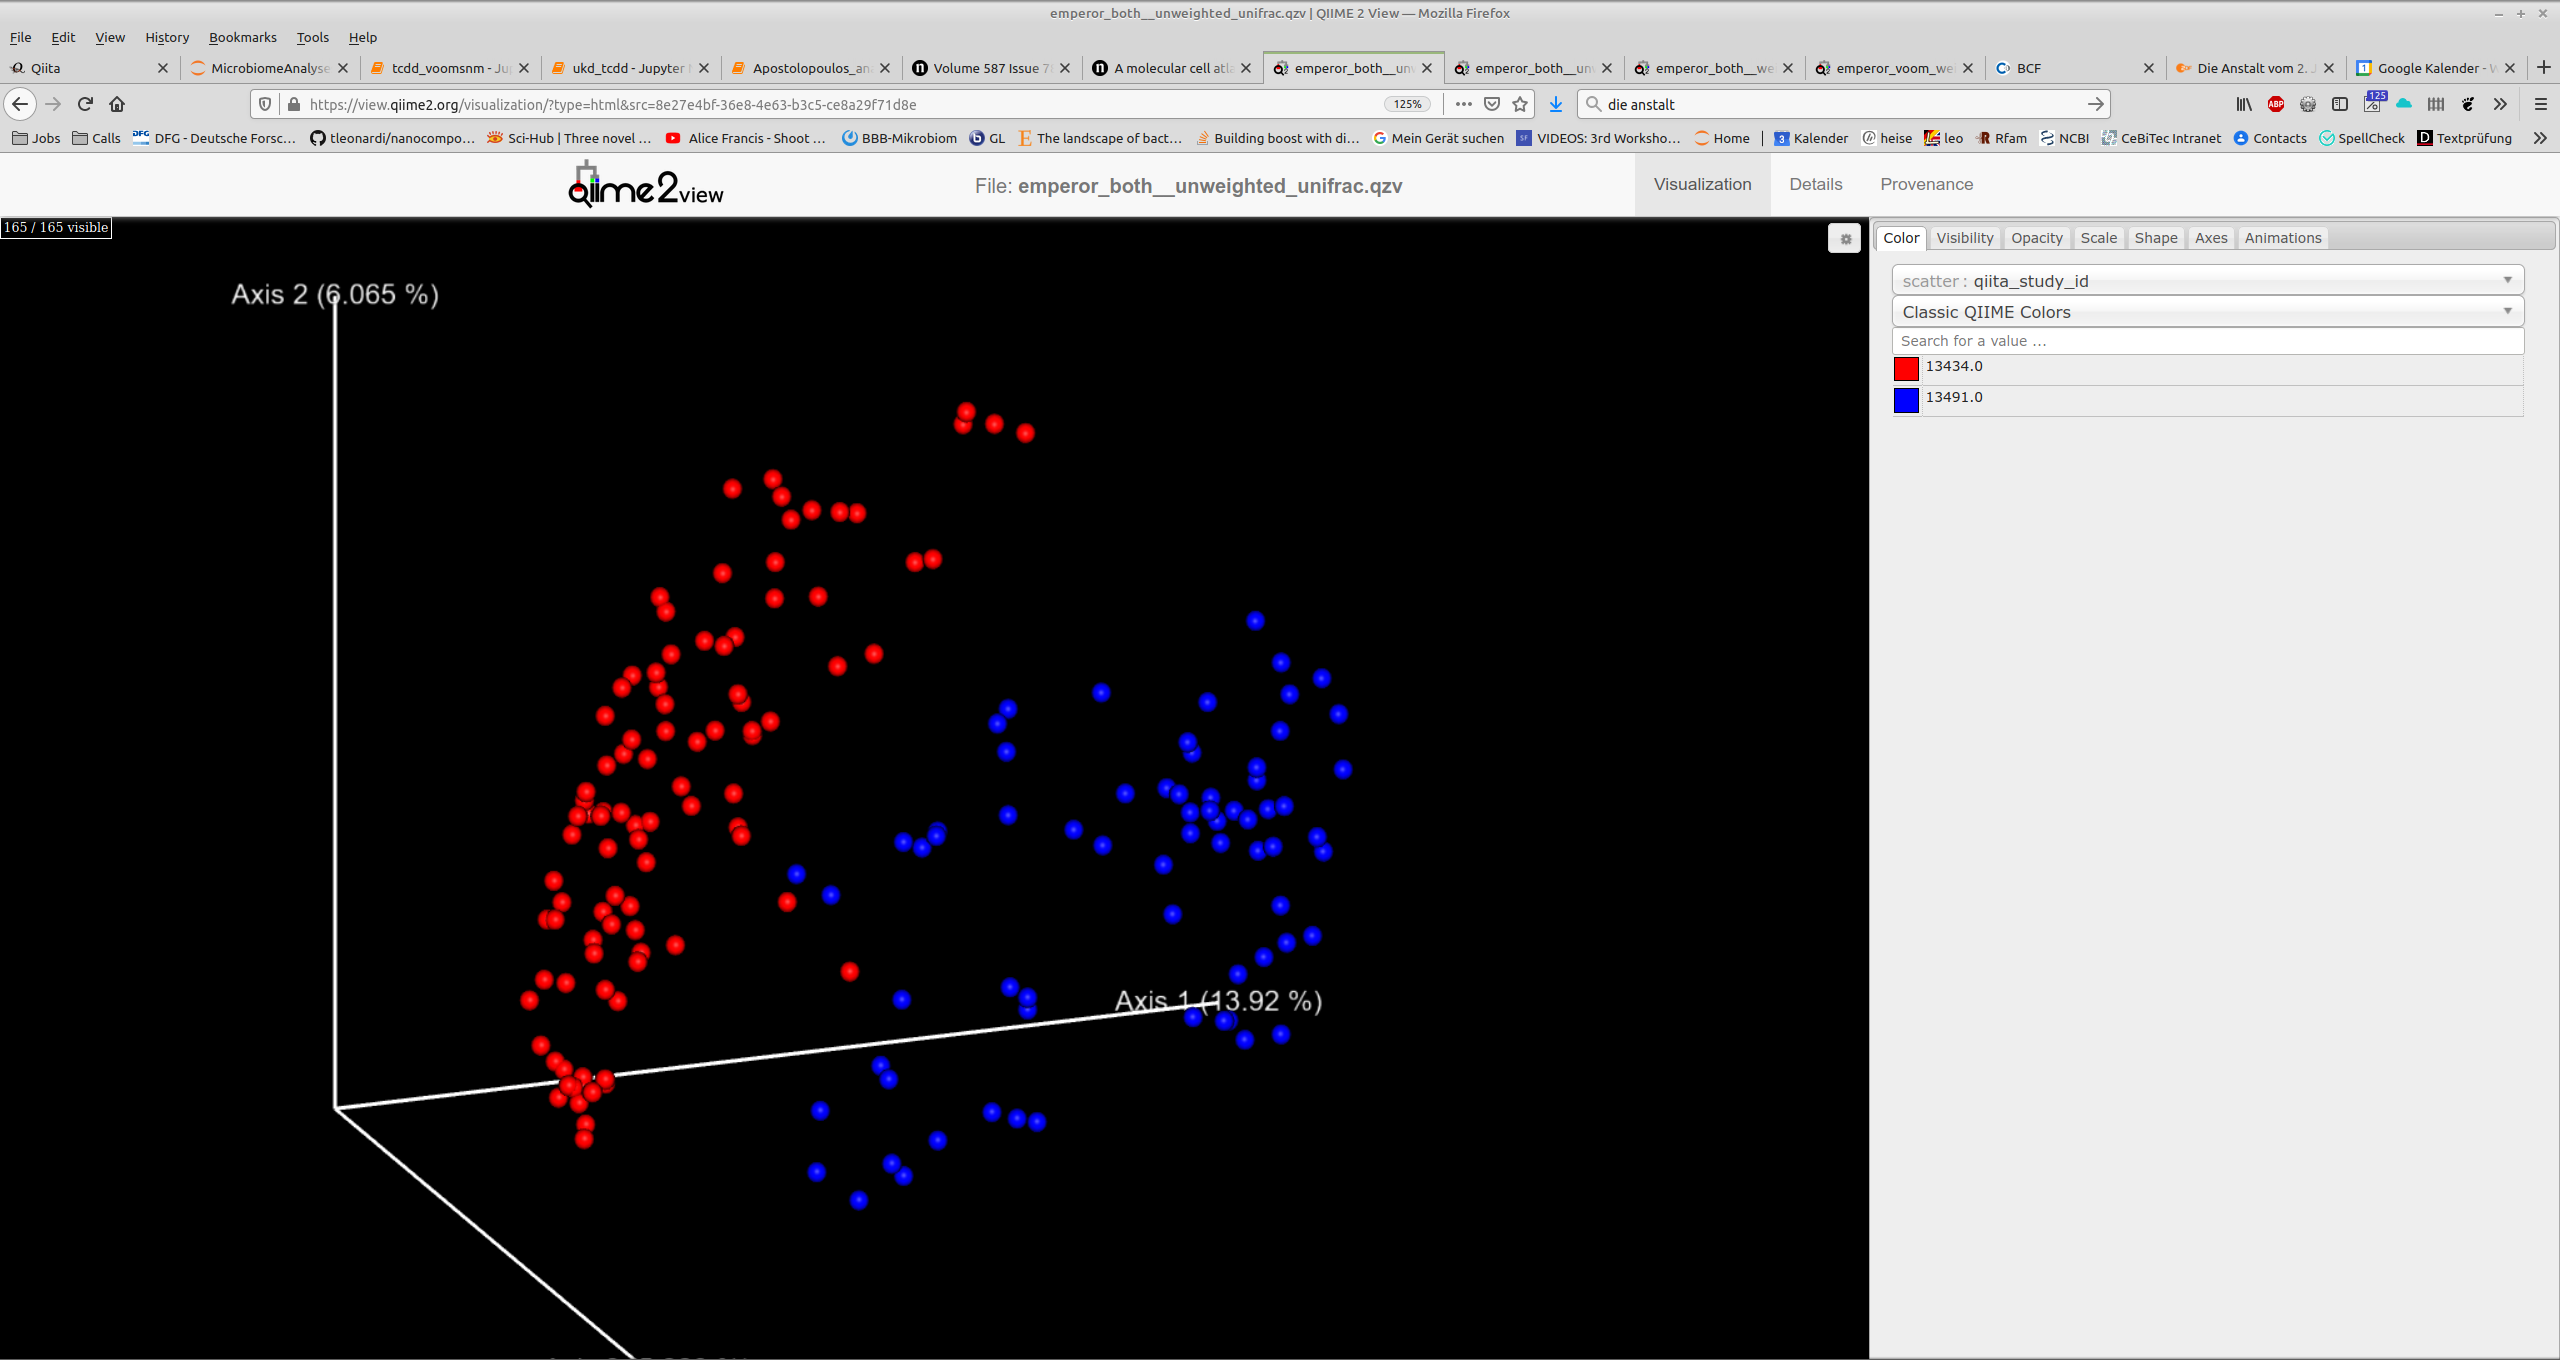

## ClosedRef Silva 11.9
Similar to GG13.8: too few surviving samples

In [ ]:
counts_both_silva = pd.concat([biom2pandas('FromQiita/103121_otu_table.biom'), biom2pandas('FromQiita/103139_otu_table.biom')], sort=False, axis=1).fillna(0)
taxonomy = pd.read_csv('/homes/sjanssen/MicrobiomeAnalyses/References/Silva119_release/taxonomy/97/taxonomy_97_7_levels.txt', sep="\t", header=None, dtype=str).set_index(0)

# filter < 10 taxa
counts_both_silva = counts_both_silva[counts_both_silva.sum(axis=1) >= 10]

# filter chloro/mito
counts_both_silva_taxonomy = counts_both_silva.merge(taxonomy, left_index=True, right_index=True, how='left')
idx_chloroplast_mitochondria = counts_both_silva_taxonomy[1].apply(lambda lineage: 'c__Chloroplast' in lineage or 'f__mitochondria' in lineage)
idx_chloroplast_mitochondria = idx_chloroplast_mitochondria[idx_chloroplast_mitochondria].index
counts_both_silva = counts_both_silva.loc[sorted(list(set(counts_both_silva.index) - set(idx_chloroplast_mitochondria))), :]

res_both_silva = dict()
res_both_silva['rarefaction_curves'] = rarefaction_curves(counts_both_silva, reference_tree='/homes/sjanssen/MicrobiomeAnalyses/References/Silva119_release/97_FastTree_trees/Silva_119_rep_set97_aligned_pfiltered_rooted.tre', dry=False, wait=False, use_grid=True, fix_zero_len_branches=True, dirty=True, nocache=True)
#res_both_silva['rarefaction'] = rarefy(counts_both_silva, rarefaction_depth=2000, dry=False, wait=False, use_grid=True)
#res_both_silva['beta_diversity'] = beta_diversity(res_both_silva['rarefaction']['results'].fillna(0), reference_tree='/homes/sjanssen/MicrobiomeAnalyses/References/Silva119_release/97_FastTree_trees/Silva_119_rep_set97_aligned_pfiltered.tre', dry=False, wait=False, use_grid=True, fix_zero_len_branches=True)
#res_both_silva['emperor'] = emperor(meta_both, res_both_silva['beta_diversity']['results'], fp_generated+'/Emperor/', infix='_bothsilva_', dry=False, wait=False, use_grid=True, walltime='00:20:00', pmem='8GB')

# Tasks from Stefanie (3.3.2021)

Hallo Stefan, nach vielen hin und her würde ich gerne von dir folgend Beiträge einbauen die sich auf die unten genannten zwei Reviewer Kommentare beziehen: rot markiert im docx


Ich würde gerne den SilvaNGS Datensatz und die Primären Analysen für Neos Doktorarbeit erhalten... Auch wenn mich seine Abbldungen etc, nicht glücklich machen.
Das meiste hattest du ja bestätigt und die anderen Analysen hatten wir entsprechend diskutiert.
Die Reviewer hatten nicht nach Rarification gefragt daher würde ich das Fass nicht aufmachen aber wir konnten ja zeigen das das Ganze grob zum gleichen Ergebnis führt.

Kommentar 1
"forward step redundancy analysis with generalized linear models " - dies betrifft wenn ich es richtig verstanden habe die Metadaten (Achtung hier war ja noch der Fehler in dem Metadatensheet - siehe Email gestern).

oder welche Daten müsste man einbauen?

Bzgl. dem zweiten Reviewerkommentar unten:
hier hattest du gesagt das ich meine Pairwisen T-test durch die anzahl der durchgeführten t-texts teilen müsste und würde dann richtig gearbeitet haben. Was muss ich dazu dann schreiben?
Oder welche Daten sollte ich einbauen? Austauschen?


Könntest du mir ggf. Material und methoden und Text passagen einbauen bzw. zur verfügung stellen?

Ich bin telefonisch unter 0171 6924483 erreichbar.
Viele Grüße, Stefanie

### Reviewer 2
<font color='darkblue'>
I found the authors’ approach of testing variables (disease state, body site, etc.) singly rather than in a multi-factor model an uncommon choice, and I think the paper needs either a revised statistical approach or a strong a priori explanation and justification of this choice.

For the alpha diversity metrics and microbial community composition, I am not convinced that the approach of testing factors singly (body site, allergic state) is the most appropriate choice. Why not a more traditional 2-factor or 3-factor test or a linear mixed model (to account for samples from the same animal), followed pairwise testing as appropriate? As written, it is difficult to compare the relative importance of body site and allergic status in alpha diversity or community composition, which in my opinion is an interesting question.
    
<font color='orange'>
I agree. My recommendation is to first to forward step redundancy analysis with generalized linear models and from thereon stratefy by major effect sizes.
</font>

<font color='darkblue'>
For differential abundance of specific taxa, it appears that not all taxa were tested, i.e., there was some selection process applied to the taxa. I think this section needs at minimum a more explicit explanation and justification for how the taxa for testing were selected, or (preferably) a method such as ANCOM (Mandal et al 2015, Microbial Ecology in Health and Disease), gneiss (Morton et al 2017, mSystems), corncob (Martin et al 2020, Annals of Applied Statistics), or similar, that accounts for the characteristics of microbiome data and tests all taxa. Also, there is no language here (lines 242-244) about multiple test correction where multiple taxa were tested, was this applied? If not, it absolutely should be.</font>

<font color='orange'>    
A qualified reviewer :-) He/She is absolutely right. There is no good reason to limit rel. abundance tests to just the four most dominant taxa. I cannot think of a reason why only those dominant guys should tend to be different. ANCOM is relatively conservative, I therefore choose discrete false discovery rate (https://msystems.asm.org/content/2/6/e00092-17.short), which is basically a multiple hypthesis testing correction + t-tests per feature
</font>

In [128]:
usegrid = False

res_silva_norare = dict()

res_silva_norare['beta_diversity'] = beta_diversity(silvangs_counts.fillna(0), dry=False, wait=False, metrics=['bray_curtis'], use_grid=usegrid)
res_silva_norare['alpha_diversity'] = alpha_diversity(silvangs_counts.fillna(0), rarefaction_depth=None, dry=False, wait=False, metrics=ALPHA_METRICS[1:], use_grid=usegrid)

_ = emperor(meta, res_silva_norare['beta_diversity']['results'], '%s/emperor' % fp_generated, infix="_silvangs-norarefaction_", dry=False, wait=True, walltime='00:20:00', pmem='8GB', use_grid=usegrid)

found matching working dir "/tmp/17828.1.jupyter.q/ana_bdiv_lpn33c8z"
 Was removed.
found matching working dir "/tmp/17828.1.jupyter.q/ana_adiv_qqwq2k5_"
 Was removed.
Working directory is '/homes/sjanssen/TMP/ana_emperor_9k03hcf3', cachefile is '.anacache/9cda32804100cb89e395d649c7f7d0c8.emperor'. 
Waiting for cluster job 882211 to complete: ... finished. Was removed.


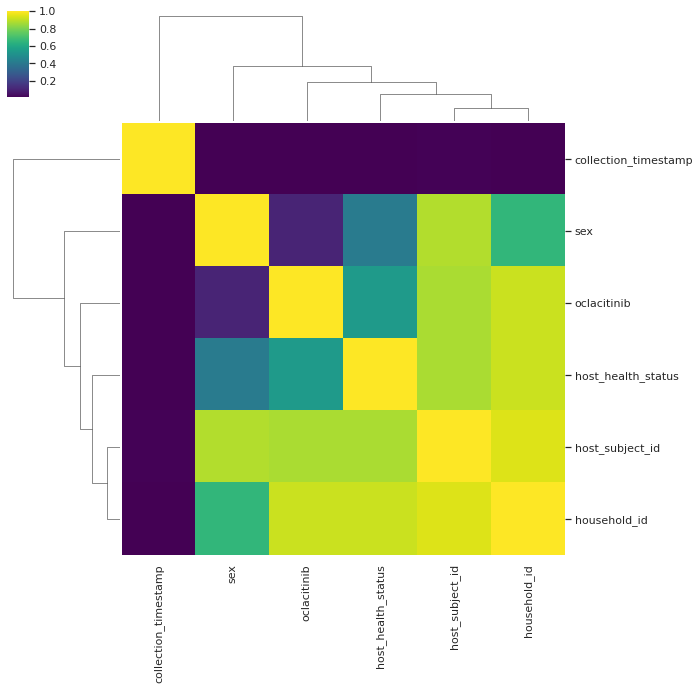

In [155]:
heatmap, correlations, cluster = correlate_metadata(
    meta[['household_id', 'oclacitinib', 'sex', 'host_health_status', 'host_subject_id', 'collection_timestamp']].fillna('NaN'),
    categorials=['household_id', 'oclacitinib', 'sex', 'host_health_status', 'host_subject_id'],
    ordinals=dict(),
    intervals=[],
    dates={'collection_timestamp': '%Y-%m-%d'},
)
_savefig(heatmap, 'metadata-correlation')

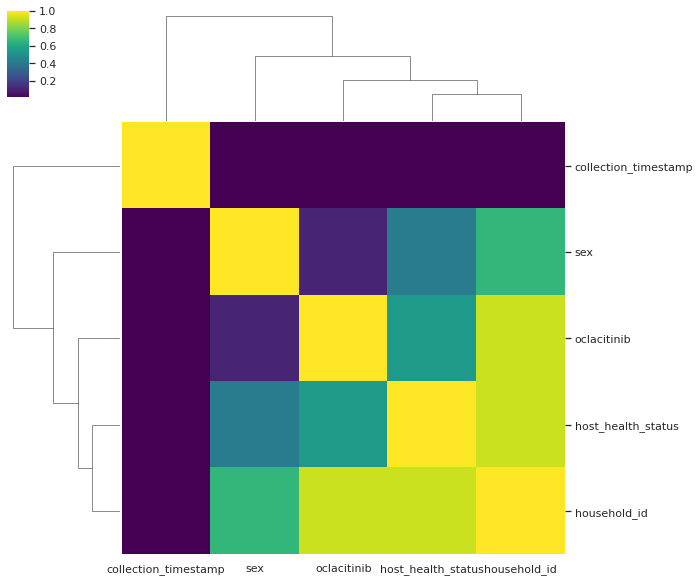

In [154]:
heatmap, correlations, cluster = correlate_metadata(
    meta[['household_id', 'oclacitinib', 'sex', 'host_health_status', 'collection_timestamp']].fillna('NaN'),
    categorials=['household_id', 'oclacitinib', 'sex', 'host_health_status'],
    ordinals=dict(),
    intervals=[],
    dates={'collection_timestamp': '%Y-%m-%d'},
)
_savefig(heatmap, 'metadata-correlation-nohsid')

By systematically testing metadata fields for correlation with alpha- (using the fife metrics 'shannon', 'gini_index', 'observed_features', 'chao1', 'dominance') or beta-diversity (using metric 'Bray-Curtis' [Bray, J. R. and J. T. Curtis. 1957. An ordination of upland forest communities of southern Wisconsin. Ecological Monographs 27:325-349.]) via Kruskal-Wallis [William H Kruskal and W Allen Wallis. Use of ranks in one-criterion variance analysis. Journal of the American statistical Association, 47(260):583–621, 1952.], Spearman- [Charles Spearman. The proof and measurement of association between two things. The American journal of psychology, 15(1):72–101, 1904.] and Pearson-correlation [Karl Pearson. Note on regression and inheritance in the case of two parents. Proceedings of the Royal Society of London, 58:240–242, 1895.] (for alpha diversity) and PERMANOVA [Anderson, Marti J. “A new method for non-parametric multivariate analysis of variance.” Austral Ecology 26.1 (2001): 32-46.] and Anosim [Clarke, KR. “Non-parametric multivariate analyses of changes in community structure.” Australian journal of ecology 18.1 (1993): 117-143.] (for beta diversity), we found that the following fields were significant in at least one of the tests: 'collection_timestamp', 'sex', 'ocalcitinib', 'host_health_status', 'host_subject_id' and 'household_id'. 

To illustrate covariance among these metadata fields, we examined the correlation between individual metadata variables. Categorical metadata fields (all but 'collection_timestamp') were compared using a modified CramérV statistic [Cramér H. 1946. Mathematical methods of statistics (PMS-9). Princeton University Press, Princeton, NJ.]). Continuous ('collection_timestamp') and categorical covariates were compared with a Welchttest [Cramér H. 1946. Mathematical methods of statistics (PMS-9). Princeton University Press, Princeton, NJ.]. Resulting correlation ratios were visualized as a heat map.

Using existing results from '.anacache/c8d024ca1d048fe2a121b4d6bd9966aa.fRDAalpha'. 
Using existing results from '.anacache/484e09b1f0e76f83326299030bb504bf.fRDAalpha'. 
Using existing results from '.anacache/8ba9159c236f9073da2a4356c8d2643a.fRDAalpha'. 
Using existing results from '.anacache/41795289e727204cc890b97caaf46f63.fRDAalpha'. 
Using existing results from '.anacache/689f6658f1305587857320acb4909f36.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/ce4dd2bb0248abf4dac9fc2cd0216258.fRDAbeta'. 


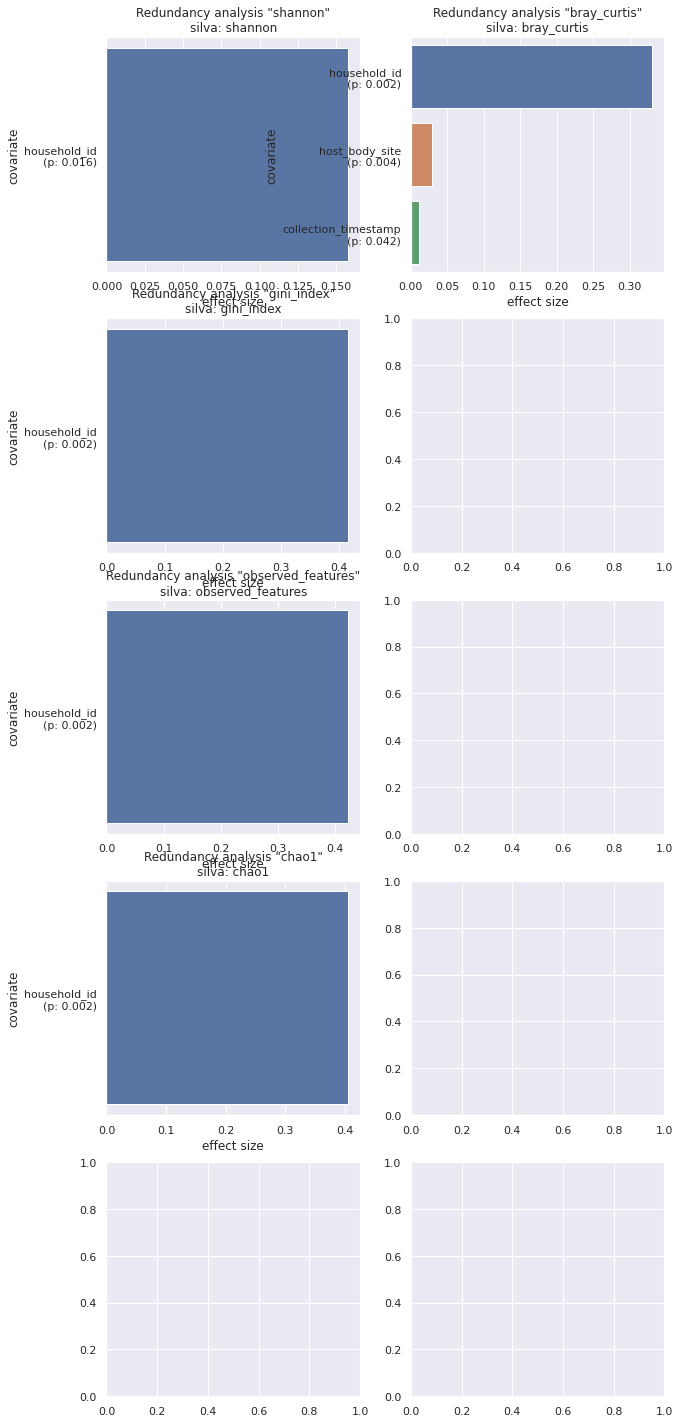

In [149]:
c_cat = ['host_health_status', 
         # host_subject_id overshadows the signal, thus I exclude it here 'host_subject_id', 
         'household_id', 
         'host_body_site',
         'sex',
         'oclacitinib'
        ]
c_int = []
c_dat = {
    'collection_timestamp': '%Y-%m-%d'
}

max_rows = max(len(res_silva_norare['alpha_diversity']['results'].keys()), len(res_silva_norare['beta_diversity']['results'].keys()))
fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
for i, metric in enumerate(res_silva_norare['alpha_diversity']['results'].keys()):
    redundancy_analysis_alpha(meta, res_silva_norare['alpha_diversity']['results'][metric],
                              categorials=c_cat, intervals=c_int, dates=c_dat,
                              ax=axes[i][0], title='silva: %s' % metric,
                              dry=False, wait=False, use_grid=usegrid)
for i, metric in enumerate(res_silva_norare['beta_diversity']['results'].keys()):
    redundancy_analysis_beta(meta, res_silva_norare['beta_diversity']['results'][metric], metric,
                             categorials=c_cat, intervals=c_int, dates=c_dat,
                             ax=axes[i][1], title='silva: %s' % metric,
                             dry=False, wait=False, use_grid=usegrid)
_savefig(fig, 'fsra_mainmodel')

Using existing results from '.anacache/7631e5eb5d71956fcdb71d7739ba9c32.fRDAalpha'. 
Using existing results from '.anacache/ae8252dd5187c1b0d7bb593986133931.fRDAalpha'. 
Using existing results from '.anacache/29b00b83b8aad5f2097843fdbf6484dc.fRDAalpha'. 
Using existing results from '.anacache/d178b1846fd6a3b8114ae3943b9e486b.fRDAalpha'. 
Using existing results from '.anacache/2ea038c5cdad244223d09a191965a1ad.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/8af9cd6c8410e5368864f35f863e8379.fRDAbeta'. 


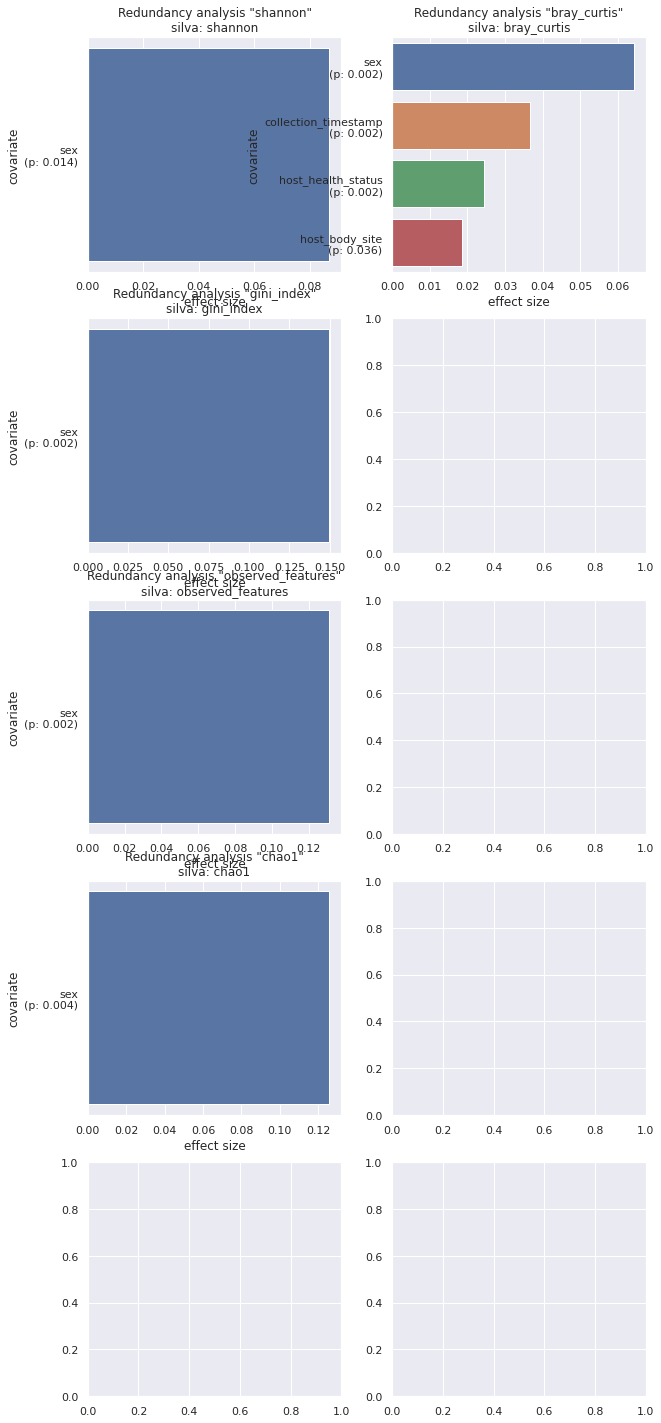

In [148]:
c_cat = ['host_health_status', 
         # host_subject_id overshadows the signal, thus I exclude it here 'host_subject_id', 
         #'household_id', 
         'host_body_site',
         'sex',
         'oclacitinib'
        ]
c_int = []
c_dat = {
    'collection_timestamp': '%Y-%m-%d'
}

max_rows = max(len(res_silva_norare['alpha_diversity']['results'].keys()), len(res_silva_norare['beta_diversity']['results'].keys()))
fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
for i, metric in enumerate(res_silva_norare['alpha_diversity']['results'].keys()):
    redundancy_analysis_alpha(meta, res_silva_norare['alpha_diversity']['results'][metric],
                              categorials=c_cat, intervals=c_int, dates=c_dat,
                              ax=axes[i][0], title='silva: %s' % metric,
                              dry=False, wait=False, use_grid=usegrid)
for i, metric in enumerate(res_silva_norare['beta_diversity']['results'].keys()):
    redundancy_analysis_beta(meta, res_silva_norare['beta_diversity']['results'][metric], metric,
                             categorials=c_cat, intervals=c_int, dates=c_dat,
                             ax=axes[i][1], title='silva: %s' % metric,
                             dry=False, wait=False, use_grid=usegrid)
_savefig(fig, 'fsra_submodel')

We quantified the effect size of multiple metadata fields by combining them in a linear model and perform forward step redundancy analysis (RDA) as previously done in https://www.nature.com/articles/s41467-020-19793-8#Sec8,  with the rda and ordiR2step functions in vegan package in R 3.6.1 [vegan: Community Ecology Package. R package version 2.4–6. Vegan 2.4-5 (2017).].

RDA is a direct gradient analysis technique which summarizes the linear relationships between components of response variables that are “redundant” with (i.e., explained by) a set of explanatory variables. Automatic forward procedure was applied to RDA to select a subset of explanatory variables (i.e., non-redundant covariates) with a two-step procedure to prevent a highly inflated type I error and an overestimation of the amount of explained variance [Blanchet, F. G., Legendre, P. & Borcard, D. Forward selection of explanatory variables. Ecology 89, 2623–2632 (2008).]. First, a global test using all explanatory variables was done prior to forward selection. Second, forward selection was carried out with permutation test (1000 permutations) using two stopping criteria: (1) the usual significance level alpha (prespecified as 0.05) and (2) the adjusted coefficient of multiple determination (R^2). This analysis estimates the linear cumulative and independent effect size (based on adjusted R^2) of each non-redundant covariate on microbiome composition variation [Falony, G. et al. Population-level analysis of gut microbiome variation. Science 352, 560–564 (2016).]. Beta diversity analysis included principal coordinates analysis (PCoA) on Bray Curtis and PERMANOVA tests with multiple testing correction of the Benjamini—Hochberg (BH) FDR procedure, to identify covariates that explain a significant variation of β-diversity [Benjamini, Y. & Hochberg, Y. Controlling the false discovery rate: a practical and powerful approach to multiple testing. J. R. Stat. Soc. Series B Stat. Methodol. 57, 289–300 (1995).]. All the BH-FDR corrected p-values are denoted as q-values. Because distance-based redundancy analysis with automatic stepwise model selection procedure that prevents inflated type 1 error is not available when applying RDA to β-diversity, we used the first 10 principal coordinates from PCoA on Bray-Curtis that provided a low dimensional approximation to the original β-diversity distance matrix.